In [1]:
import numpy as np
import math
import scipy.linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.stats import binom
import scipy
from scipy.special import jv

In [2]:
def tuple_sum(a,b):
    output = ()
    for i in range(len(a)):
        output = output + ((a[i]+b[i]),)
    return output

def create_next_set(set_ini):
    v = set_ini.pop()
    set_ini.add(v)
    N = len(v)
    idty = np.eye(N,dtype=int)
    output = set()
    for i in set_ini:
        for j in idty:
            j = tuple(j)
            output.add(tuple_sum(i,j))
    return output

def create_whole_set(N,Ns):
    ini_vec = tuple((0 for _ in range (Ns)))
    ini_set = set()
    ini_set.add(ini_vec)
    for _ in range(N):
        ini_set = create_next_set(ini_set)
    return ini_set

def create_whole_basis(Na,Nb,Ns):
    set_a = create_whole_set(Na,Ns)
    set_b = create_whole_set(Nb,Ns)
    basis = []
    
    for i in (set_a):
        for j in (set_b):
            #current_vector = np.array((Ns,2))
            current_vector = []
            for k in range(Ns):
                secondary_vector = [i[k],j[k]]
                current_vector.append(secondary_vector)
            current_vector = np.array(current_vector)
            basis.append(current_vector)
            
    return basis
                


In [3]:

def summation(test_tup):
    test = list(test_tup)
    count = 0
    for i in test:
        count += i
    return count


def tuple_sum_fermions(a,b):
    output = ()
    for i in range(len(a)):
        output = output + (((a[i]+b[i]))%2,)
    return output

def create_next_set_fermions(set_ini):
    v = set_ini.pop()
    set_ini.add(v)
    N = len(v)
    idty = np.eye(N,dtype=int)
    output = set()
    for i in set_ini:
        for j in idty:
            j = tuple(j)
            output.add(tuple_sum_fermions(i,j))
    return output

def create_whole_set_fermions(N,Ns):
    ini_vec = tuple((0 for _ in range (Ns)))
    ini_set = set()
    ini_set.add(ini_vec)
    #print("ini vec is ",ini_vec)
    #print("ini set is ",ini_set)
    for _ in range(N):
        ini_set = create_next_set_fermions(ini_set)
        
    ini_set2 = ini_set.copy()
    for _ in ini_set2:
        if (summation(_) != N):
            ini_set.remove(_)
    return ini_set

def create_whole_basis_fermions(Na,Nb,Ns):
    set_a = create_whole_set_fermions(Na,Ns)
    set_b = create_whole_set_fermions(Nb,Ns)
    basis = []
    
    for i in (set_a):
        for j in (set_b):
            #current_vector = np.array((Ns,2))
            current_vector = []
            for k in range(Ns):
                secondary_vector = [i[k],j[k]]
                current_vector.append(secondary_vector)
            current_vector = np.array(current_vector)
            basis.append(current_vector)
            
    return basis

Definition of Operators

In [4]:
def c(ket,i,species):
    outket = ket.copy()

    if (i>(len(ket)-1)):
        k = i - len(ket)
    elif (i<0):
        k = i + len(ket)
    else:
        k=i
        
    if ket[k,species] > 0:
        outfactor = math.sqrt(outket[k,species])
        outket[k,species] = outket[k,species] - 1
    elif ket[k,species] <= 0:
        outfactor = 0
        outket[k,species] = 0
    return outfactor, outket

def c_dagger(ket,i,species):
    outket = ket.copy()
    if (i>(len(ket)-1)):
        outfactor = math.sqrt(outket[i-len(ket),species]+ 1)
        outket[i-len(ket),species] = outket[i-len(ket),species] + 1
    elif (i<0):
        outfactor = math.sqrt(outket[i+len(outket),species]+ 1)
        outket[i+len(outket),species] = outket[i+len(outket),species] + 1
    else:
        outfactor = math.sqrt(outket[i,species]+ 1)
        outket[i,species] = outket[i,species] + 1
    return outfactor,outket

def hopping_right(i,species,ket):
    outket = ket.copy()
    #if (i == len(ket)-1):
        #factor1, outket = c(outket,i,species)
        #factor2, outket = c_dagger(outket,i+1,species)
    #elif (i<(len(ket)-1)):
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i+1,species)
    outfactor = factor1*factor2  
    return outfactor, outket

def hopping_left(i,species,ket):
    outket = ket.copy()
    #if (i == 0):
     #   factor1, outket = c(outket,i,species)
      #  factor2, outket = c_dagger(outket,i-1,species)
    #elif (i>0):
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i-1,species)
    outfactor = factor1*factor2  
    return outfactor, outket

def n(i,species,ket):
    outket = ket.copy()
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i,species)
    outfactor = factor1*factor2
    return outfactor, outket


def superexchange_hopping_right(i,species,ket):
    outket = ket.copy()
    factor0, outket = n(i+1,species,outket)
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i+2,species) 
    outfactor = factor0*factor1*factor2  
    return outfactor, outket

def superexchange_hopping_left(i,species,ket):
    outket = ket.copy()
    factor0, outket = n(i-1,species,outket)
    factor1, outket = c(outket,i,species)
    factor2, outket = c_dagger(outket,i-2,species)
    outfactor = factor0*factor1*factor2  
    return outfactor, outket

In [5]:
def H_hopping_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_l,outket_l = hopping_left(i,alpha,ket)
        outfactor_r,outket_r = hopping_right(i,alpha,ket)
        if np.array_equal(bra,outket_l):
            output = output - outfactor_l
        if np.array_equal(bra,outket_r):
            output = output - outfactor_r
    return output


def total_H_hopping_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_hopping_element_single_site(bra,ket,i)
    return output

def build_H_hopping(basis):
    H = np.zeros((len(basis), len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_hopping_element(bra,ket)
    return H


def H_contact_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_c, outket_c = n(i,alpha,ket)    
        if np.array_equal(bra,outket_c):
            output = output + outfactor_c*(outfactor_c-1)*1/2       
    return output


def total_H_contact_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_contact_element_single_site(bra,ket,i)
    return output

def build_H_contact(basis):
    #H = np.zeros((len(basis), len(basis)))
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        #print(i)
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_contact_element(bra,ket)
    return H



def H_fn_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_1, outket_1 = n(i,alpha,ket)
        outfactor_2, outket_2 = n(i+1,alpha,outket_1)
        if np.array_equal(bra,outket_2):
            output = output + outfactor_1*outfactor_2     
    return output


def total_H_fn_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_fn_element_single_site(bra,ket,i)
    return output

def build_H_fn(basis):
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_fn_element(bra,ket)
    return H


def H_dipolar_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_1, outket_1 = n(i,alpha,ket)
        for j in range(len(ket)):
            if (j != i):
                outfactor_2, outket_2 = n(j,alpha,outket_1)
                if np.array_equal(bra,outket_2):
                    output = output + (outfactor_1*outfactor_2)/(distance(i,j,len(ket))**3)
                    
    return output


def total_H_dipolar_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_dipolar_element_single_site(bra,ket,i)
    return output

def build_H_dipolar(basis):
    H = np.zeros((len(basis),len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_dipolar_element(bra,ket)
            
    return H



def H_SE_hopping_element_single_site(bra,ket,i):
    output = 0
    
    for alpha in range(2):
        outfactor_l,outket_l = superexchange_hopping_left(i,alpha,ket)
        outfactor_r,outket_r = superexchange_hopping_right(i,alpha,ket)
        if np.array_equal(bra,outket_l):
            output = output + outfactor_l
        if np.array_equal(bra,outket_r):
            output = output + outfactor_r
    return output


def total_H_SE_hopping_element(bra,ket):
    output = 0
    for i in range(len(bra)):
        output = output + H_SE_hopping_element_single_site(bra,ket,i)
    return output

def build_H_SE_hopping(basis):
    H = np.zeros((len(basis), len(basis)))
    for i in range(len(basis)):
        for j in range(len(basis)):
            bra = basis[i]
            ket = basis[j]
            H[i,j] = total_H_SE_hopping_element(bra,ket)
    return H


In [6]:
def distance(i,j,length):
    check = np.abs(i-j)
    if (np.abs(check) <= int(length/2)):
        return check
    else:
        return np.abs(length - check)

In [ ]:
U = 1
Nb = 0
Ns = 5
Na = Ns - 1
basis = create_whole_basis(Na,Nb,Ns)
print(len(basis))

HJ = build_H_hopping(basis)

HU = build_H_contact(basis)

H_D = build_H_fn(basis)
#H_D = build_H_dipolar(basis)

J = np.linspace(0,5,300)
V = [0.4]
plot_energies = np.zeros((len(basis),len(V), len(J)))

print("Len HJ is", len(HJ))

print("Len HU is", len(HU))




for j in range(len(J)):
    for v in range(len(V)): 
        H = HJ*J[j] + U*HU + V[v]*H_D
        vaps, veps = LA.eigh(H)
        for i in range(len(vaps)):
            plot_energies[i,v,j] = vaps[i]

In [ ]:
'''
for level in range(Ns):
    for v in range(len(V)):
        if (level == 2) or (level == 3):
        
            if v==0:
                plt.plot(J,plot_energies[level,v], label = "V = "+str(V[v])+", n = "+str(level), color = "red")
            elif v==1:
                plt.plot(J,plot_energies[level,v], label = "V = "+str(V[v])+", n = "+str(level), color = "blue")
            elif v == 2:
                plt.plot(J,plot_energies[level,v], label = "V = "+str(V[v])+", n = "+str(level), color = "green")
'''        
        
        
for level in range(Ns):
    for v in range(len(V)):
        plt.plot(J,plot_energies[level,v], label = "V = "+str(V[v])+", n = "+str(level))

plt.xlabel("J", fontsize = 16)
plt.ylabel("E", fontsize = 16)
#plt.xlim([0.1,0.2])
#plt.xlim([0,1])
#plt.ylim([0.75,1])
plt.title(r"First neighbor interaction. $U=1$, $N_s = 5$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
U = 1
V = U/2 + 0.001

Na = 3
Nb = 0
Ns = 4

J = np.linspace(0,1,700)
#print(J)

basis_bosons = create_whole_basis(Na,Nb,Ns)
basis_fermions = create_whole_basis_fermions(Na,Nb,Ns)



HJ_ex = build_H_hopping(basis_bosons)
HU_ex = build_H_contact(basis_bosons)
H_FN_ex = build_H_fn(basis_bosons)

HJ_eff = build_H_hopping(basis_fermions)
H_SE_eff = build_H_SE_hopping(basis_fermions)
H_FN_eff = build_H_fn(basis_fermions)

#print(basis_fermions)

#print(HJ_eff)
#print((HJ_eff + H_SE_eff + H_FN_eff).T - (HJ_eff + H_SE_eff + H_FN_eff))
plot_ex = np.zeros((len(basis_bosons),len(J)))
plot_eff = np.zeros((len(basis_fermions),len(J)))

for j in range(len(J)):
    H_ex = J[j]*HJ_ex + U*HU_ex + V*H_FN_ex
    H_eff = J[j]*HJ_eff + 2*J[j]**2/(2*V-U)*H_SE_eff + 4*J[j]**2/(V-U)*H_FN_eff #+ V*np.eye(len(HJ_eff))
    #H_eff = H_eff + V*(Ns-2)*np.eye(len(H_eff))
    
    vaps_ex, veps_ex = LA.eigh(H_ex)
    vaps_eff, veps_eff = LA.eigh(H_eff)
    for i in range(len(basis_bosons)):
        plot_ex[i,j] = vaps_ex[i]
    for k in range(len(basis_fermions)):
        plot_eff[k,j] = vaps_eff[k] + V*(Ns-2)
        

    
    
    
    

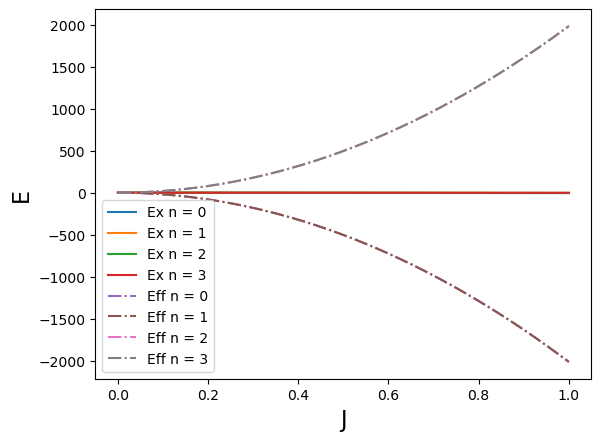

In [14]:
p = 0
for i in range(p,p+4):
    plt.plot(J,plot_ex[i], label = r"Ex n = "+str(i))#, color = "red")
    
for k in range(len(basis_fermions)):
    plt.plot(J,plot_eff[k], label = r"Eff n = "+str(k), ls = "-.")#, color = "green")
    
plt.xlabel("J", fontsize = 16)
plt.ylabel("E", fontsize = 16)
plt.legend()
#plt.xlim([0,0.15])
#plt.ylim([0,1])
plt.show()

In [13]:
def H_eff_mott_matrixelement(n,m,Ns,J,U):
    
    def delta(i,j):
        if (i == j):
            return 1
        elif (i != j):
            return 0
        
    return -J*(delta(n,m-1)*(1+0.00000001j) + delta(n,m+1)*(1+0.00000001j)) - 2*(Ns-2)*((2*J**2)/U)*delta(n,m) - (2*J**2/U)*(delta(n,m+2) + delta(n,m-2))

def H_eff_mott(Ns,J,U):
    H = np.zeros((Ns,Ns), dtype = complex)
    for i in range(Ns):
        for j in range(-2,Ns+2):
            element = H_eff_mott_matrixelement(i,j,Ns,J,U)
            if (j < 0):
                j = j + Ns
            elif (j > (Ns-1)):
                j = j - Ns
            H[i,j] = H[i,j] + element
    return H

In [ ]:
import time

Na = 3
Nb = 0
Ns = 4
U = 1
J = 1
plot_ex = []
plot_eff = []
average_ex = []
average_eff = []
tries = 10

N = np.arange(4,12)
for ns in N:
    print(ns)
    basis_bosons = create_whole_basis(ns-1,0,ns)

    HJ_ex = build_H_hopping(basis_bosons)
    HU_ex = build_H_contact(basis_bosons)
    
    H_ex = J*HJ_ex + U*HU_ex
    H_eff = H_eff_mott(ns,J,U)
    
    for i in range(tries):
        t0_ex = time.time()
        vaps_ex,veps_ex = LA.eigh(H_ex)
        t1_ex = time.time()
        T_ex = t1_ex - t0_ex
        average_ex.append(T_ex)
        
        t0_eff = time.time()
        vaps_eff,veps_eff = LA.eigh(H_eff)
        t1_eff = time.time()
        T_eff = t1_eff - t0_eff
        average_eff.append(T_eff)
        
    plot_ex.append(np.mean(average_ex))
    plot_eff.append(np.mean(average_eff))
    
    

plt.plot(N, plot_ex, label = "Full Hamiltonian")
plt.plot(N, plot_eff, label = "Effective Hamiltonian")
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

    

In [17]:
def time_evolution(vector,H,t):
    outvector = vector.copy()
    outvector = outvector.astype(complex)
    #print(outvector)
    out = LA.expm(-1j*H*t)@outvector
    return out

def time_evolution_operator(H,t):
    out = LA.expm(-1j*H*t)
    return out


def time_evolution_taylor(vector,H,t):
    outvector = vector.copy()
    outvector = outvector.astype(complex)

    U = 0
    U = complex(U)
    #print("U = ", U)
    #M = np.eye(len(H))
    for i in range(100):
        U = U + (np.linalg.matrix_power(H,i)*(-1j*t)**i)/math.factorial(i)
    out = U@outvector
    return out


def density_operator(Ns,site):
    out = np.zeros((Ns,Ns))
    out[site,site] = 1
    return out

def density(ket,site):
    #print(ket)
    ket_column = ket.T
    ket_row = np.conj(ket)
    return np.real(ket_row@density_operator(len(ket),site)@ket_column)


In [9]:
def canonical_to_fock(basis,vector):
    output_vectors = []
    output_factors = []
    for i in range(len(vector)):
        if (vector[i] != 0):
            output_vectors.append(basis[i])
            output_factors.append(vector[i])
    return output_factors, output_vectors

def density_fock_state(state,site):
    op_state = state.copy()
    dens = 0
    for species in range(2):
        factor, vector = n(site,species,op_state)
        dens = dens + factor
    return dens


def density_of_state_canonical(basis, state, site):
    output_factors, output_vectors = canonical_to_fock(basis,state)
    dens = 0
    for i in range(len(output_factors)):
        ket = output_vectors[i]
        factor = output_factors[i]
        
        occupation = density_fock_state(ket,site)
        
        dens = dens + np.abs(factor)**2*occupation
    
    dens = dens.real
    return dens

def get_site_from_fock(state):
    for i in range(len(state)):
        if (state[i,0] != 0):
            site = i
    return site
            
    
def get_distribution_from_canonical(basis, canonical_vector):
    output_factors, output_vectors = canonical_to_fock(basis,canonical_vector)
    out = np.zeros((len(canonical_vector),2))
    for i in range(len(output_factors)):
        factor = output_factors[i]
        fock_state = output_vectors[i]
        site = get_site_from_fock(fock_state)
        out[site,0] = site
        out[site,1] = factor
    return out

def parabola(x, a, b, c):
    return a*(x**2) + b*(x**1) + c

def straight_line(x,a,b):
    return a*x + b

In [75]:
Ns = 11


J = 1
U = 10

H = H_eff_mott(Ns,J,U)

dT = 0.01
Tmax = 4

T = np.arange(0,Tmax + dT,dT)

v0 = np.zeros((Ns), dtype = complex)
v0[Ns//2] = 1


time_ev = time_evolution_operator(H,dT)


plot = np.zeros((Ns,len(T)))

for i in range(Ns):
    plot[i,0] = np.real(np.conj(v0)@density_operator(Ns, i)@v0)

for t in range(1,len(T)):
    v0 = time_ev@v0
    v0 = v0/LA.norm(v0)
    for i in range(Ns):
        plot[i,t] = np.real(np.conj(v0)@density_operator(Ns, i)@v0)
    

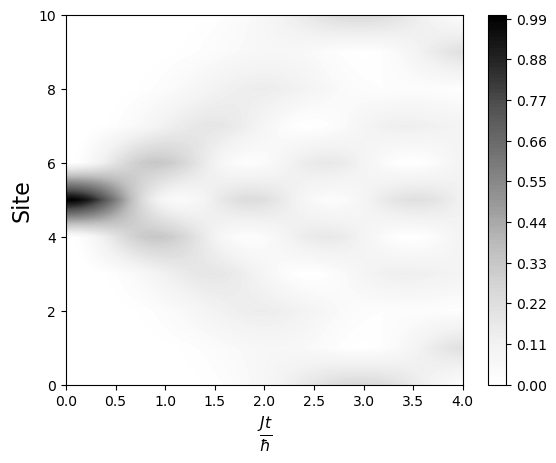

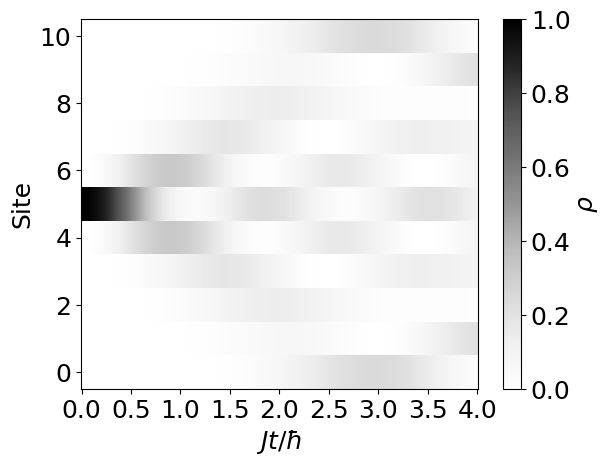

In [86]:
N = np.arange(Ns)

#plt.contourf(T[:len(T)//4],N[len(N)//2-5:len(N)//2+6],plot[len(N)//2-5:len(N)//2+6,:len(T)//4],levels = 100, cmap = "Greys")
plt.contourf(T,N,plot,levels = 100, cmap = "Greys")
plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel("Site", fontsize = 16)
#plt.xlim([0,4])
plt.colorbar()

plt.show()

fig, ax0 = plt.subplots(nrows=1)

im = ax0.pcolormesh(T,N,plot, cmap = "Greys")
cb = fig.colorbar(im, ax=ax0)#, label = r"$\rho$")
#ax0.set_title('pcolormesh with levels')
im.figure.axes[1].tick_params(axis="y", labelsize=18)
cb.set_label(label=r'$\rho$',weight='bold', size = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel(r"$Jt/\hbar$", fontsize = 18)
plt.ylabel("Site", fontsize = 18)

# contours are *point* based plots, so convert our bound into point
# centers
#cf = ax1.contourf(x[:-1, :-1] + dx/2.,
 #                 y[:-1, :-1] + dy/2., z, levels=levels,
                 # cmap=cmap)



# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
#fig.tight_layout()

plt.show()

In [50]:
Ns = 7
Nb = 0
Na = 6
Nsites = np.arange(0,Ns)

basis = create_whole_basis(Na,Nb,Ns)
#print((basis_sp))
J = 1
#HJ = J*build_H_hopping(basis)
#print(HJ)

Tmax = 3
dT = 0.005
T = np.arange(0,Tmax + dT,dT)

Us = np.array([5,10,20,50,80,200])

basis_dict1 = {}
basis_dict2 = {}
for i in range(len(basis)):
    basis_dict1[i] = basis[i]
    basis_dict2[str(basis[i])] = i




v0 = np.ones((Ns,2))
x0 = Ns//2

for i in range(Ns):
    v0[i,1] = 0

v0[x0,0] = 0

for i in range(len(basis)):
    if np.array_equal(basis[i],v0):
        result = i


HJ = create_H_J_sparse(basis_dict1,basis_dict2)
HU = create_H_U_sparse(basis_dict1,basis_dict2)

plot = np.zeros((len(T),Ns, len(Us)))

for u in range(len(Us)):
    
    v0_canonical = np.zeros((len(basis)), dtype = complex)
    v0_canonical[result] = 1
    v0_canonical = v0_canonical.T

    H = HJ + Us[u]*HU
    H = H.todense()

    U_t = time_evolution_operator(H,dT)




    for site in range(Ns):
        plot[0,site,u] = density_of_state_canonical(basis,v0_canonical,site)



    for t in range(1,len(T)):
        if t%50 == 0:
            print(t)
        v0_canonical = U_t@v0_canonical
        v0 = v0_canonical/LA.norm(v0_canonical)

        for site in range(Ns):
            plot[t,site,u] = density_of_state_canonical(basis,v0_canonical,site)



50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350
400
450
500
550
600


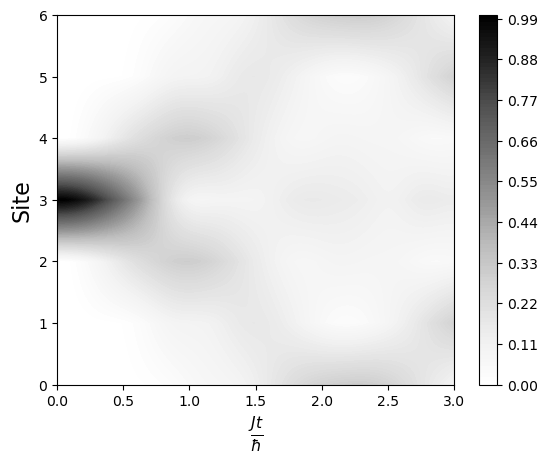

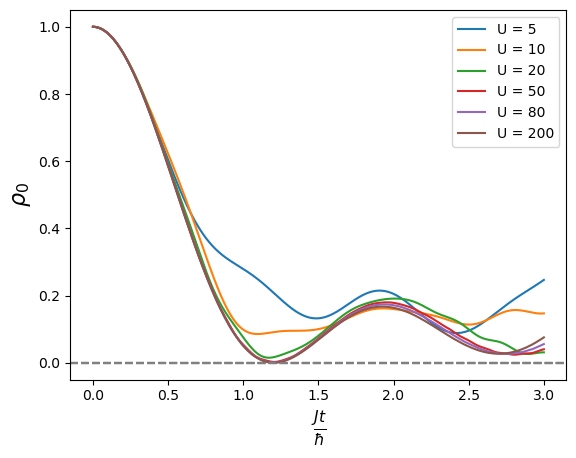

In [51]:
plt.contourf(T,Nsites,1 - plot[:,:,1].T,levels=100,cmap = "Greys")
plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel("Site", fontsize = 16)
#plt.xlim([0,6])
plt.colorbar()
plt.show()


for u in range(len(Us)):
    plt.plot(T,(1 - plot[:,Ns//2,u]), label = r"U = "+str(Us[u]))
    plt.axhline(y = 0,ls = "--" ,color = "Gray")
#plt.xlim([0,3])


plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel(r"$\rho_0a$", fontsize = 16)
plt.legend()

    
plt.show()

In [ ]:
N = np.arange(0,Ns)
#T = np.array(T)
g = [1, 1, 1]
values, cov = curve_fit(parabola, T, plot_r2_exact, g)





print(values)


print(plot_r2_exact[0])
print(plot_r2_exact[-1])
plt.plot(T,parabola(T, values[0], values[1], values[2]), ls = "--", lw = 3, color = "Gray", label = r"$0.07t^2 + 637.4$")
plt.plot(T,plot_r2_exact,label = "Exact", ls = "-")

plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel(r"$\langle r^2 \rangle$", fontsize = 16)
plt.legend()
plt.show()


plt.title("Density at initial site")
plt.plot(T,density_at_0,label = "Density initial site")
#plt.plot(T, jv(0, 2*T)**2, label = r"$\left|J_0\right|^2$")
#plt.plot(T,time_ev(T), ls = "--", lw = 3, color = "Gray", label = r"$1-2t^2 + \frac{3}{2}t^4 - \frac{5}{9}t^6$")
#plt.xlim([0,1.5])
#plt.ylim([-0.2,1.1])
plt.xlabel(r"$\frac{Jt}{\hbar}$")
plt.ylabel(r"$\rho_0$")
plt.legend()
plt.show()

plt.contourf(T,N,plot.T,levels=100,cmap = "Greys")
plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel("Site", fontsize = 16)
plt.title("Exact")
plt.colorbar()
plt.show()

plt.contourf(np.linspace(0,50,1000),N,plot_easy.T,levels=100,cmap = "Greys")
plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel("Site", fontsize = 16)
plt.title("Approx")
plt.colorbar()
plt.show()
'''
plt.contourf(T,N,plot_taylor.T,levels=100,cmap = "Greys")
plt.xlabel(r"$\frac{Jt}{\hbar}$", fontsize = 16)
plt.ylabel("Site", fontsize = 16)
plt.title("Taylor")
plt.colorbar()
plt.show()'''

deltat = int((len(T)-1)/5)

for k in range(6):
    plt.plot(N,plot[int(k*deltat)],label = "t = "+str(round(T[int(k*deltat)])))
plt.xlabel("N")
plt.title("Exact")
#plt.xlim([15,35])
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

'''
for k in range(6):
    plt.plot(N,plot_taylor[int(k*deltat)],label = "t = "+str(round(T[int(k*deltat)])))
plt.xlabel("N")
plt.title("Taylor")
#plt.xlim([15,35])
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()'''


In [9]:
def gaussian(x,x0,sigma,p):
    return np.exp(-(x-x0)**2/(2*sigma**2))*np.exp(-1j*p*x)

def canonical_vector_gaussian_local(x0,basis,sigma):
    canonical_out = np.zeros((Ns))
    for i in range(len(basis)):
        fock_state = basis[i]
        for k in range(len(fock_state)):
            if (fock_state[k,0] != 0):
                canonical_out[i] = gaussian(k,x0,sigma)
                
    return canonical_out

def canonical_vector_gaussian_local_holes(x0,p,Ns,sigma):
    out = np.zeros((Ns), dtype = complex)
    for i in range(Ns):
            out[i] = gaussian(i,x0,sigma,p)
    return out

In [11]:
def permutations(n,J,U):
    total = 0       
    for nplus1 in range(n+1):
        for nminus1 in range(n+1):
                if(nplus1 + nminus1 <= n) and ((n/2 - 1/4*(3*nplus1 + nminus1))%1 == 0):
                    if ((nplus1%2 == 0) and (nminus1%2 == 0)) or ((nplus1%2 != 0) and (nminus1%2 != 0)):
                        binom1 = scipy.special.binom(n, nplus1+nminus1)
                        binom2 = scipy.special.binom(nplus1+nminus1, nplus1)
                        #binom3 = scipy.special.binom(n-(nplus1+nminus1), nplus2+nminus2)
                        binom3 = scipy.special.binom(n - nplus1 - nminus1, n/2 - 1/4*(3*nplus1 + nminus1))
                        total = total + binom1*binom2*binom3*(-J)**(nplus1 + nminus1)*(-2*J**2/U)**(n - nplus1 - nminus1)#*binom4*(-J)**(nplus1 + nminus1)*(-2J**2/U)**(nplus2 + nminus2)
    return total


def density_over_time(t,J,U):
    out = 0
    for i in range(0,70):
        out = out + (-1j*t)**i*(1/math.factorial(i))*permutations(i,J,U)
        
    return np.abs(out)**2


In [ ]:
J = 1
T = np.linspace(0,15,500)
Ns = 50

Us = np.array([5,10,20])

plot_exponent = np.zeros((len(T), len(Us)), dtype = complex)
#plot_analytical = np.zeros((len(T), len(Us)), dtype = complex)





v0 = np.zeros(Ns, dtype = complex)
'''
for i in range(len(v0)):
    v0[i] = (-1)**(i) + 0j¡'''

v0[int(len(v0)/2)] = 1+0j
v0 = v0/LA.norm(v0)

print("Initial density is: ",density(v0,int(len(v0)/2)))







for t in range(len(T)):
    #print(t)
    for u in range(len(Us)):
        H_eff = H_eff_mott(Ns,1,Us[u])
        v1 = time_evolution(v0,H_eff,T[t])
        
        plot_exponent[t,u] = round(np.real(density(v1,int(len(v0)/2))),3)


In [18]:
def H_eff_mott_matrixelement2(n,m,Ns,J,U):
    
    def delta(i,j):
        if (i == j):
            return 1
        elif (i != j):
            return 0
        
    return - 2*(Ns-2)*((2*J**2)/U)*delta(n,m) - (2*J**2/U)*(delta(n,m+2) + delta(n,m-2))

def H_eff_mott2(Ns,J,U):
    H = np.zeros((Ns,Ns))
    for i in range(Ns):
        for j in range(-2,Ns+2):
            element = H_eff_mott_matrixelement2(i,j,Ns,J,U)
            if (j < 0):
                j = j + Ns
            elif (j > (Ns-1)):
                j = j - Ns
            H[i,j] = H[i,j] + element
    return H


Ns = 250
J = 1

time_spacing = 0.005
max_time = 60



T = np.arange(0,max_time + time_spacing,time_spacing)

'''T2 = np.zeros((2*len(T)))
for i in range(1,len(T)):
    T2[i-1] = -1*T[-i]
    T2[i+len(T)] = T[i]'''
    
    
    
'''
#Us = np.arange(7,10)

#Us = np.array([5,6,7,8,9,10])
Us = np.arange(40,10,-2)
Us2 = np.arange(10,3.5,-0.5)
Us = np.concatenate((Us,Us2))
#Us_negative = np.arange(-40,-5,2)
Us_negative1 = np.arange(-4,-10.5,-0.5)
Us_negative = np.arange(-12,-42,-2)
Us_negative = np.concatenate((Us_negative1,Us_negative))
print(Us_negative)
Us = np.concatenate((Us_negative,Us))
print(Us)'''

Us = np.array([4,8,20])

ratios = np.linspace(-0.25,0.25,80)
Us = 1/ratios

#Us = np.array([10])
plot_overleaf = np.zeros((len(Us), len(T)))



for u in range(len(Us)):
    v0 = np.zeros(Ns, dtype = complex)
    v0[int(len(v0)/2)] = 1+0j
    v0 = v0/LA.norm(v0)
    #print("Initial density is: ",density(v0,int(len(v0)/2)))
    
    print(u)
    H = H_eff_mott(Ns,J,Us[u])
    time_ev = time_evolution_operator(H,time_spacing)
    plot_overleaf[u,0] = (round(np.real(density(v0,int(len(v0)/2))),3))
    for t in range(1,len(T)-1):
        v0 = time_ev@v0
        v0 = v0/LA.norm(v0)
        plot_overleaf[u,t] = (round(np.real(density(v0,int(len(v0)/2))),3))
        
        
#plt.plot(T,plot_overleaf[0,:])
#plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [19]:
Ns = 100
J = 1

time_spacing = 0.1
max_time = 30


T = np.arange(0,max_time + time_spacing,time_spacing)

Us = np.array([10])


#Sigmas = np.array([5,10,20])
#plot_overleaf = np.zeros((len(Us), len(T),Ns))


Qs = np.array([0,np.pi/2,np.pi])
overlaps = np.zeros((2,Ns, len(Qs), len(Us)))



#v0 = np.zeros(Ns, dtype = complex)
#v0[int(len(v0)/2)] = 1+0j
#v0 = v0/LA.norm(v0)


k = -(2)*np.pi/Ns



for q in range(len(Qs)):
    v1 = canonical_vector_gaussian_local_holes(Ns//2,Qs[q],Ns,20)
    v1 = v1/LA.norm(v1)
    v0 = np.zeros((Ns),dtype = complex)
    v0[len(v0)//2] = 1+0j
    #v0[0] = 1+0j
    for u in range(len(Us)):
        H = H_eff_mott(Ns,J,Us[u])
        vaps, veps = LA.eigh(H)
        veps = veps.T
        #print(vaps)
        '''new_veps = []
        
        new_veps.append(veps[0])
        for i in range(1,Ns-1,2):
            new_veps.append(1/2*(veps[i] + 1j*veps[i+1]))
            new_veps.append(1/2*(veps[i] - 1j*veps[i+1]))   
        new_veps.append(veps[-1])
        
        new_veps = np.array(new_veps, dtype = complex)
        
        for i in range(len(new_veps)):
            new_veps[i] = new_veps[i]/LA.norm(new_veps[i])'''
        
        #plt.plot(np.real(veps[1]), label = "real")
        #plt.plot(np.imag(veps[1]), label = "imag")
        #plt.plot(np.arange(0,Ns),1/np.sqrt(Ns)*np.exp(1j*k*np.arange(0,Ns)), label = "analytical")
        #plt.plot(np.arange(0,Ns),np.imag(1/np.sqrt(Ns)*np.exp(1j*k*np.arange(0,Ns))), label = "analytical imag")
        #plt.legend()
        #plt.show()
        for level in range(Ns):
            overlaps[0,level,q,u] = np.abs(np.dot(np.conj(v0),veps[level]))**2         
            overlaps[1,level,q,u] = np.abs(np.dot(np.conj(v1),veps[level]))**2


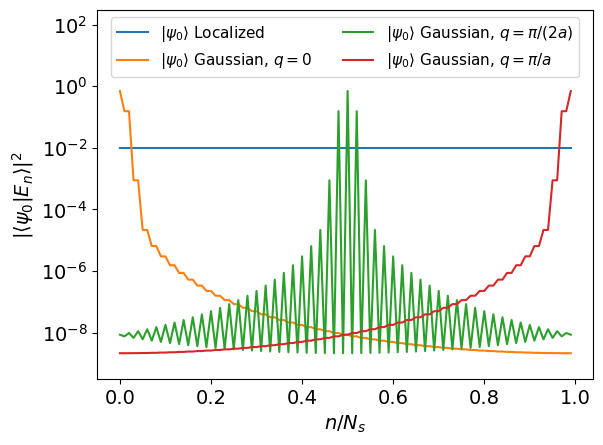

In [37]:
'''for u in range(len(Us)):
    print(g)
    for g in range(2):
        for q in range(len(Qs)):
            if (g == 0):
                plt.plot(np.arange(0,Ns)/Ns,overlaps[g,:,0,u], label = r"$ |\psi_0 \rangle localized$")
            elif (g==1):
                if (q == 0):
                    plt.plot(np.arange(0,Ns)/Ns,overlaps[g,:,q,u], label = r"$ |\psi_0 \rangle$ gaussian, $q = 0$")
                if (q == 1):
                     plt.plot(np.arange(0,Ns)/Ns,overlaps[g,:,q,u], label = r"$ |\psi_0 \rangle$ gaussian, $q = \frac{\pi}{2}$")
                if (q == 2):
                    plt.plot(np.arange(0,Ns)/Ns,overlaps[g,:,q,u], label = r"$ |\psi_0 \rangle$ gaussian, $q = \pi$")'''
                    
for u in range(len(Us)):
    #for i in range(Ns):
        #overlaps[0,i,0,u]
    plt.plot(np.arange(0,Ns)/Ns,overlaps[0,:,0,u], label = r"$ |\psi_0 \rangle$ Localized")                    
    plt.plot(np.arange(0,Ns)/Ns,overlaps[1,:,0,u], label = r"$ |\psi_0 \rangle$ Gaussian, $q = 0$")
    plt.plot(np.arange(0,Ns)/Ns,overlaps[1,:,1,u], label = r"$ |\psi_0 \rangle$ Gaussian, $q = \pi/(2a)$")
    plt.plot(np.arange(0,Ns)/Ns,overlaps[1,:,2,u], label = r"$ |\psi_0 \rangle$ Gaussian, $q = \pi/a$")   
    plt.xlabel(r"$n/N_s$", fontsize = 14)
    plt.ylabel(r"$\left|\langle\psi_0|E_n\rangle\right|^2$", fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(ncol = 2, loc = "upper center", fontsize = 11)
    plt.ylim([3e-10,300])
    plt.yscale("log")
    #plt.xlim([85,100])
    #plt.title(r"$U = $"+str(Us[u]))
    plt.show()

In [20]:
def ft_analytical(X):
    if np.abs(x)<4:
        return scipy.special.ellipk(1-x**2/16)
    else:
        return 0

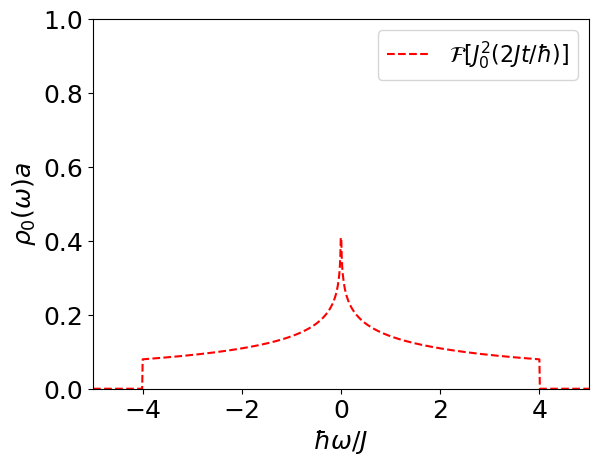

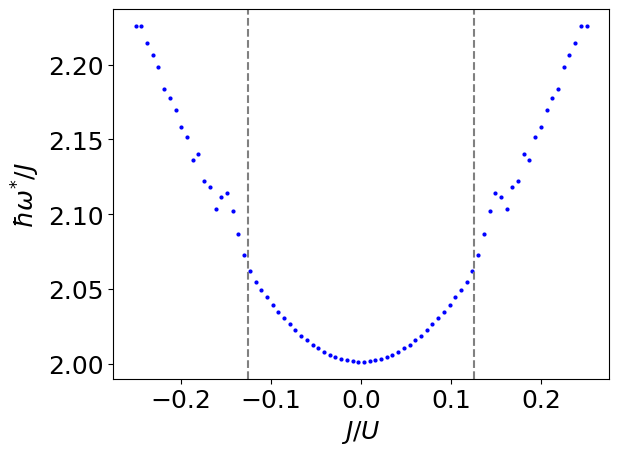

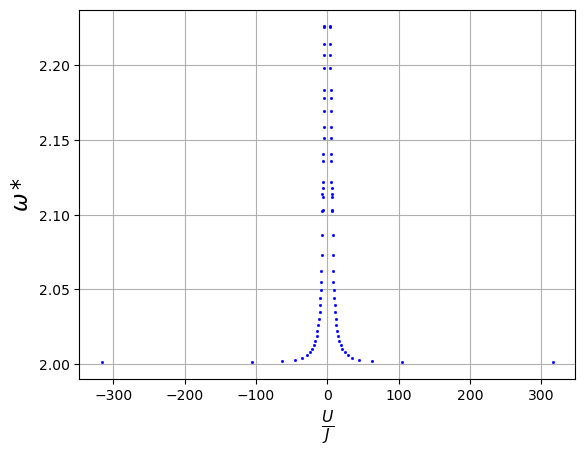

In [26]:
time_spacing = 0.005
max_time = 60



T = np.arange(0,max_time + time_spacing,time_spacing)

ratios = np.linspace(-0.25,0.25,80)
Us = 1/ratios


T2 = np.zeros((2*len(T)-1))
for i in range(1,len(T)):
    T2[-i] = T[-i]
    T2[i-1] = -T[-i]
    
new_plot = np.zeros((2*len(plot_overleaf[0]),len(T2))) 
for u in range(len(Us)):
    for i in range(1,len(plot_overleaf[u])):
        new_plot[u,-i] = plot_overleaf[u,-i]
        new_plot[u,i-1] = plot_overleaf[u,-i]
    new_plot[u,len(new_plot[u])//2] = 1

    
plot_omega2 = []
ratios = []

markers = np.array(["g^" , "bo" , "ys", "y^", "c^", "m^"])
colors = ["cyan", "orange", "green", "black", "blue", "lime"]
for i in range(len(Us)):

    #values = plot_overleaf[i]
    values = new_plot[i]
    x,y = fourier_transform(T2,values)

    y = np.abs(y)
    #print("J/U = ", 1/Us[i], "Norm = ", integrate.cumtrapz(y, x, initial=0))
    norm = my_integration(x,y)
    y = y/norm


    w2 = my_integration(x,x*x*y)
    ratios.append(1/Us[i])
    plot_omega2.append(np.sqrt(w2))
    #if (i == 5):
    #if (i == 2)or(i == 1)or(i == 0)or(i == 3):

    #print("zeros values are:", y[3*len(y)//4])
    #if (i == 6):
    #if (Us[i] < 0):
    #plt.plot(x,y, "^",color = colors[i],markersize = 4, label = r"$U = $"+str(Us[i]))
    #plt.plot(x,y,markers[i],markersize = 4, label = r"$U/J = $"+str(Us[i]))
    #else:
     #   plt.plot(x,y, "^",color = colors[i],markersize = 2, label = r"$U = $"+str(Us[i]))

x,y = fourier_transform(T2,jv(0,2*T2)**2)
y = np.abs((np.real(y)))
norm = my_integration(x,y)
y = y/norm

sorting = np.argsort(x)
x = x[sorting]
y = y[sorting]



X = np.linspace(-5,5,1000)

ft_analytical_vector = np.zeros((1000))

for i in range(len(ft_analytical_vector)):
    x = X[i]
    ft_analytical_vector[i] = ft_analytical(x)
    
norm = my_integration(X,ft_analytical_vector)


#plt.plot(np.linspace(-10,10,100),scipy.special.ellipk(x)/(np.sqrt(2)*np.pi**(3/2))/norm)
plt.plot(X,ft_analytical_vector/norm, ls = "--", color = "red", label = r"$\mathcal{F}[J_0^2(2Jt/\hbar)]$")





#plt.plot(x,np.real(y), ls = "-", color = "red" ,markersize = 3, label = r"$\mathcal{F}(J_0^2)$")


#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 8)
plt.legend(fontsize = 16, markerscale=2)
    #plt.xlim([-0.05,0.05])
plt.xlim([-5,5])
plt.ylim([0,1])
plt.xlabel(r"$\hbar\omega/J$", fontsize = 18)
plt.ylabel(r"$\rho_0(\omega)a$", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.grid("on")
#plt.savefig('U'+str(round(Us[i],1))+'.png')
plt.show()
    
    
    



plt.plot(ratios,plot_omega2,"bo", markersize = 2)
plt.xlabel(r"$J/U$", fontsize = 18)
#plt.grid("on")
plt.ylabel(r"$\hbar\omega^{*}/J$", fontsize = 18)
plt.axvline(x=1/8, color = "Gray", ls = "--")
plt.axvline(x=-1/8, color = "Gray", ls = "--")
#plt.axvline(x=1/8)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()



plt.plot(Us,plot_omega2, "bs", markersize = 1)
plt.xlabel(r"$\frac{U}{J}$", fontsize = 16)
plt.grid("on")
plt.ylabel(r"$\omega*$", fontsize = 16)
plt.show()

In [15]:
time_spacing = 0.001
max_time = 8



T = np.arange(0,max_time + time_spacing,time_spacing)
Us = np.array([5,10,20])
plot_analytical = np.zeros((len(Us),len(T)))



for u in range(len(Us)):
    for i in range(len(T)):
        plot_analytical[u,i] = order_n(1,Us[u],T[i],16)


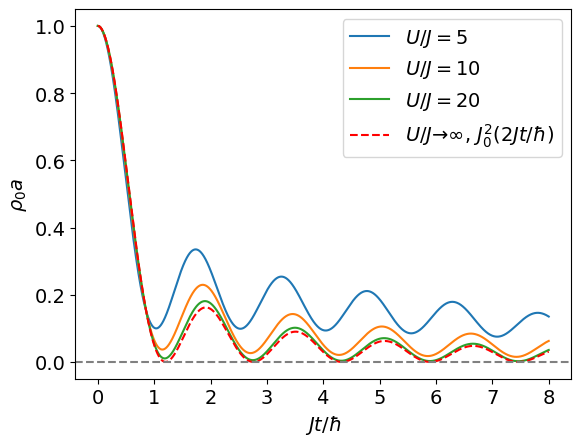

In [23]:
for u in range(len(Us)):
    plt.plot(T,plot_analytical[u,:], label = r"$U/J = $"+str(Us[u]))
    
plt.plot(T,np.abs(jv(0,2*T))**2, label = r"$U/J \to \infty$, $J_0^2(2Jt/\hbar)$", color = "red", ls = "--")
plt.axhline(y=0, ls = "--", color = "Gray")



#plt.ylim([0,1.05])
#plt.xlim([0,20])

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.yscale("log")
plt.legend(fontsize = 14)
plt.xlabel(r"$Jt/\hbar$", fontsize = 14)
plt.ylabel(r"$\rho_0a$", fontsize = 14)
plt.show()

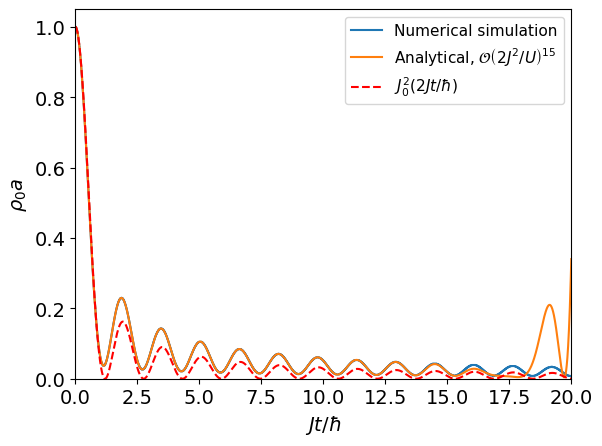

In [115]:
plt.plot(T,plot_overleaf[0], label = r"Numerical simulation")
plt.plot(T,plot_analytical[0,:], label = r"Analytical, $\mathcal{O}\left(2J^2/U\right)^{15}$")

plt.plot(T,jv(0,2*T)**2, label = r"$J_0^2\left(2Jt/\hbar\right)$", color = "red", ls = "--")

plt.ylim([0,1.05])
plt.xlim([0,20])

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.yscale("log")
plt.legend(fontsize = 11)
plt.xlabel(r"$Jt/\hbar$", fontsize = 14)
plt.ylabel(r"$\rho_0a$", fontsize = 14)
plt.show()

In [ ]:
#def order2(x,J,U):
 #   return jv(2*x)**2










T2 = np.zeros((2*len(T)-1))
for i in range(1,len(T)):
    T2[-i] = T[-i]
    T2[i-1] = -T[-i]

new_plot = np.zeros((2*len(plot_overleaf[0]),len(T2))) 

#plot_derivatives = np.zeros((len(U)))



'''
for u in range(len(Us)):
    for i in range(1,len(plot_overleaf[u])):
        new_plot[u,-i] = plot_overleaf[u,-i]
        new_plot[u,i-1] = plot_overleaf[u,-i]
    new_plot[u,len(new_plot[u])//2] = 1'''
    #print(new_plot[u,len(new_plot[u])//2])

plot_roots = []



                            
  
                            

for i in range(len(Us)):
    #if (i == 2) or (i == 3) or (i == 4):
    plt.plot(T, plot_overleaf[i], label = "Exponentiation, U = "+str(Us[i]))

    #plt.plot(T,plot_analytical, label = "Analytical order 4")

    plt.xlim([0,10])
    plt.ylim([0,1])
    '''plt.xlabel(r"t", fontsize = 16)
    plt.ylim([-0.5,1])
    plt.xlim([0,2])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid("on")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)'''
    
    

    
#plt.plot(T,derivative(T,jv(0,2*T)**2),ls = "--",color = "red",lw = 2,label = r"$J_0(2t)^2$")
plt.legend(fontsize = 11)
plt.show()


#plt.legend()

#plt.plot(Us,plot_roots)
#plt.show()

In [ ]:
Ns = 300
J = 1

time_spacing = 0.01
max_time = 80


T = np.arange(0,max_time + time_spacing,time_spacing)

Us = np.linspace(3,40,80)
print(Us)
#Us = np.array([5,8,10,20])





plot = np.zeros((len(Us), len(T)))



for u in range(len(Us)):
    v0 = np.zeros(Ns, dtype = complex)
    v0[int(len(v0)/2)] = 1+0j
    v0 = v0/LA.norm(v0)
    print("Initial density is: ",density(v0,int(len(v0)/2)))
    
    print(u)
    H = H_eff_mott(Ns,J,Us[u])
    time_ev = time_evolution_operator(H,time_spacing)
    plot[u,0] = (round(np.real(density(v0,int(len(v0)/2))),3))
    for t in range(1,len(T)-1):
        v0 = time_ev@v0
        v0 = v0/LA.norm(v0)
        plot[u,t] = (round(np.real(density(v0,int(len(v0)/2))),3))

In [ ]:
for i in range(len(Us)):
    #if (i == 1) or (i == 2) or (i==3) or ( i == 0):
    plt.plot(T, plot[i])#, label = r"$\frac{J}{U} = $"+str(1/Us[i]))
    
#plt.xlim([0,10])
#plt.legend()

plt.plot(T,jv(0,2*T)**2,ls = "--",color = "red",lw = 2,label = r"$J_0(2t)^2$")
plt.ylabel(r"$\rho_0(t)$",fontsize = 16)
plt.legend()
plt.xlabel(r"t", fontsize = 16)
plt.show()

In [23]:
def fourier_transform(x, y):
    from scipy.fft import fft, fftfreq
    #T = vector_times.copy()
    #y = vector_function.copy()
    dt = np.diff(x)[0]
    xf = fftfreq(len(x), dt)
    FT_y_real = np.real((fft(y, norm = "ortho")))
    xf = 2*np.pi*xf
    return xf, FT_y_real


def rsquared(x,y):
    r = x.copy()
    #dx = x[10]-x[9]
    #print(x)
    out = integrate.trapz((r**2)*y,x=None,dx = x[10]-x[9])
    return out

def my_integration(X,Y):
    dx = np.diff(X)[0]
    out = 0
    
    '''for y in range(len(Y)):
        if np.abs(Y[y]) < 0.001:
            Y[y] = 0'''
    
    for y in range(len(Y)):
        if np.abs(X[y]) < 4.5:
            out = out + Y[y]*dx
        
    return out

def my_integration2(X,Y):
    dx = np.diff(X)[0]
    out = 0
    
    for y in range(len(Y)):
        out = out + Y[y]*dx
        
    return out

In [29]:
from scipy.fft import fft, fftfreq
T = np.arange(0,max_time + time_spacing,time_spacing)

Us = np.array([5,8,10,20])
markers = ["b^" , "g^" , "k^"]
#ratios = []
#Rs = []

for i in range(len(Us)):

    values = plot_overleaf[i]
    x,y = fourier_transform(T,values)

    
    #print("J/U = ", 1/Us[i], "Norm = ", integrate.cumtrapz(y, x, initial=0))
    norm = my_integration(x,y)
    y = y/norm
    
    #print("this should be one", my_integration(x,y))
    #y = y/norm
    #print((x[100]))
    #print(y[100])
    #print("diff is", np.diff(x)[3])
    #print("J/U = ", 1/Us[i], "Norm = ", integrate.trapz(y,x = None ,dx=np.diff(x)[0]))
    #print("J/U = ", 1/Us[i], "Norm = ", integrate.trapz(y, x))
    #print("self_made: ", my_integration(x,y))
    r2 = my_integration(x,x*x*y)
    ratios.append(1/Us[i])
    Rs.append(np.sqrt(r2))
    plt.plot(x,y,markers[i],markersize = 3)#, label = r"$\frac{J}{U} = $"+str(round(1/Us[i],2)))
    #print(max(y))

x,y = fourier_transform(T,jv(0,2*T)**2)
norm = my_integration(x,y)
y = y/norm
#plt.plot(x,np.real(y), ls = "--", color = "red", lw = 4, label = r"$\mathcal{F}(J_0^2)$")
plt.plot(x,np.real(y), "ro",markersize = 3, label = r"$\mathcal{F}(J_0^2)$")
#print(max(np.real(y)))
#print()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)
plt.legend(fontsize = 16)
plt.xlim([-5,5])
plt.ylim([0,1])
plt.xlabel(r"$\omega$", fontsize = 16)
plt.ylabel(r"$\hat{\rho}_0(\omega)$", fontsize = 16)
plt.show()


plt.plot(Us,Rs)
plt.xlabel(r"$\frac{U}{J}$", fontsize = 16)
plt.grid("on")
plt.ylabel(r"$\omega*$", fontsize = 16)
plt.show()

C:\Users\davri\AppData\Local\Temp\ipykernel_14276\2702967075.py:17: RuntimeWarning: invalid value encountered in divide
  y = y/norm


ValueError: operands could not be broadcast together with shapes (301,) (301,110) 

In [ ]:
Ns = 300
J = 1

time_spacing = 0.01
max_time = 40


T = np.arange(0,max_time + time_spacing,time_spacing)

#Us = np.linspace(3,40,80)
Us = np.array([10])
print(Us)
#Us = np.array([5,8,10,20])





plot = np.zeros((len(Us), Ns,len(T)))



for u in range(len(Us)):
    v0 = np.zeros(Ns, dtype = complex)
    v0[len(v0)//2] = 1+0j
    v0 = v0/LA.norm(v0)
    
    print("Initial density is: ",density(v0,int(len(v0)/2)))
    print(u)
    
    H = H_eff_mott(Ns,J,Us[u])
    time_ev = time_evolution_operator(H,time_spacing)
    for site in range(Ns):
        plot[u,site,0] = round(np.real(density(v0,site)),3)
    for t in range(1,len(T)):
        v0 = time_ev@v0
        v0 = v0/LA.norm(v0)
        for site in range(Ns):  
            plot[u,site,t] = round(np.real(density(v0,site)),3)

In [ ]:
N = np.arange(0,Ns)

plt.plot(N,plot[0].T[3999])
plt.show()

In [28]:
Ns = 200
J = 1


#Us = np.linspace(5,12,10)


Us_negative = np.arange(-20,-3.8,0.2)
#print(Us_negative)
#np.flip(Us_negative,axis = 1)
Us_negative = Us_negative[::-1]
#print(Us_negative)
Us_negative_2 = np.arange(-80,-15,5)

Us_negative_2 = Us_negative_2[::-1]
#np.flip(Us_negative_2)
Us_negative = np.concatenate((Us_negative,Us_negative_2))


Us_positive = -1*Us_negative[::-1]

Us = np.concatenate((Us_negative,Us_positive))
Us = np.array([-20,-8, 8, 20])
#Us = np.array([-8])
#print(Us)


#new_ratios = np.linspace(-0.3,0.3,40)


#Us = 1/new_ratios

print(Us)

time_spacing = 0.05
max_time = 60

T = np.arange(0,max_time + time_spacing,time_spacing)
Qs = np.array([0,np.pi])
#q = 0

Nsites = np.arange(0,Ns)

sigma = 20
print(Us)

X = Nsites - Ns//2

plot = np.zeros((len(T),len(Us),len(Qs),Ns))
plot_r2 = np.zeros((len(T),len(Qs),len(Us)))

for q in range(len(Qs)):
    print("q = ", Qs[q])
    for u in range(len(Us)):
        x0 = Ns//2
        v0 = canonical_vector_gaussian_local_holes(x0,Qs[q],Ns,sigma)
        v0 = v0/LA.norm(v0)


        print(u)
        H = H_eff_mott(Ns,J,Us[u])
        time_ev = time_evolution_operator(H,time_spacing)

        for site in range(Ns):
            plot[0,u,q,site] = density(v0,site)

        plot_r2[0,q,u] = np.sqrt(2*my_integration2(Nsites,plot[0,u,q]*X**2))


        for t in range(1,len(T)):
            v0 = time_ev@v0
            v0 = v0/LA.norm(v0)

            for site in range(Ns):
                plot[t,u,q,site] = density(v0,site)

            if (t == 1):
                print("This should be 1:", my_integration2(Nsites,plot[t,u,q]))
            plot_r2[t,q,u] = np.sqrt(2*my_integration2(Nsites,plot[t,u,q]*X**2))

[-20  -8   8  20]
[-20  -8   8  20]
q =  0.0
0
This should be 1: 1.0000000000000002
1
This should be 1: 1.0000000000000002
2
This should be 1: 1.0
3
This should be 1: 0.9999999999999999
q =  3.141592653589793
0
This should be 1: 1.0000000000000002
1
This should be 1: 1.0000000000000002
2
This should be 1: 0.9999999999999997
3
This should be 1: 1.0000000000000007


In [19]:
def function_rsquared(T,a,m):
    return np.sqrt((a**2 + ((T)/(m))**2)/a)

def sigma_mass(xdata,ydata,sigma):
    epsilon = 0.001
    values, cov = curve_fit(sigma_sp, xdata, ydata,bounds=((-np.inf,sigma-epsilon), (np.inf,sigma+epsilon)))

    return values[0], values[1]


def J_eff(m):
    return 1/(2*m)


def sigma_sp(t,m,sigma):
    return np.sqrt(sigma**2 + (t/(sigma*m))**2)


def linear_mass_q0(ratio):
    return (2+16*ratio)

def linear_mass_qpi(ratio):
    return (-2+16*ratio)

def linear_mass_qpihalves(ratio):
    return np.abs(-16*ratio)


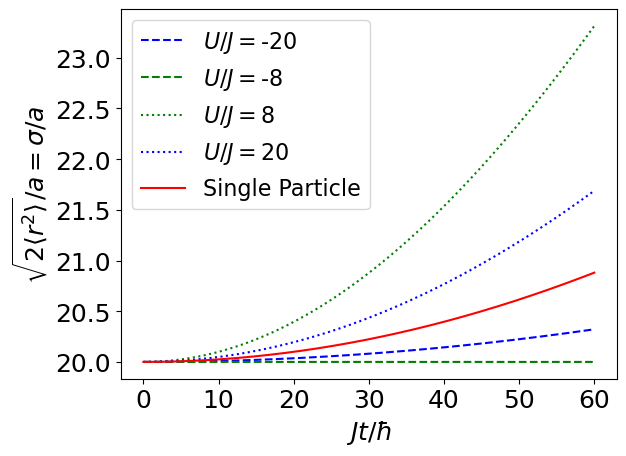

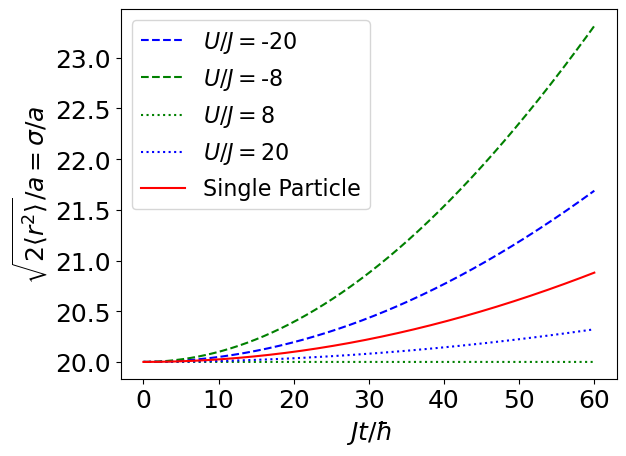

'\n\n\n\nplot_m_eff = np.zeros((len(Us), len(Qs)))\n#plot_sigmas = np.zeros((len(Us)))\nratios = np.zeros((len(Us)))\nfor q in range(len(Qs)):\n    for u in range(len(Us)):\n        \n        if (q == 2):\n            ydata = plot_r2[:len(T)//2,q,u]\n            xdata = T[:len(T)//2]\n        else:\n            xdata = T\n            ydata = plot_r2[:,q,u]\n        m_eff, sigma_eff = sigma_mass(xdata,ydata,sigma)\n        #print("Sigma is:", sigma_eff)\n        plot_m_eff[u,q] = m_eff\n        #plot_sigmas[u] = sigma0\n        ratios[u] = 1/Us[u]\n    \n    \n\n\n\n#for q in range(len(Qs)):  \nplt.plot(new_ratios,np.abs(1/plot_m_eff[:,0]),"bo",label = r"$q = 0$")\nplt.plot(new_ratios,np.abs(1/plot_m_eff[:,1]),"ro", lw = 2,label = r"$q = \\pi/a$")\n#plt.plot(new_ratios,np.abs(1/plot_m_eff[:,2]),"go", lw = 2,label = r"$q = \x0crac{\\pi}{2}$")\nplt.plot(np.linspace(-0.3,0.3,2000),np.abs(linear_mass_q0(np.linspace(-0.3,0.3,2000))), color = "blue", lw = 2,label = r"Analytical $m^{*}$, $q = 

In [31]:
'''for u in range(len(Us)):
    for i in range(len(T)):
        if (i%20000 == 0):
            if (u == 0):
                plt.plot(Nsites,plot[i,u,q], label = "t = "+str(round(T[i],2)))



    plt.xlabel("Site", fontsize = 16)
    plt.ylabel(r"$\rho$", fontsize = 16)
    plt.title("U = "+str(Us[u]))
    #plt.xlim([Ns//2 - 10,Ns//2 +10])
    plt.legend()    
    plt.show()

for i in range(len(T)):
    if (i%2000 == 0):
        plt.plot(Nsites,plot[i,len(Us)//4*3], label = "t = "+str(round(T[i],2)))
        
        

plt.xlabel("Site", fontsize = 16)
plt.ylabel(r"$\rho$", fontsize = 16)
plt.title("U = "+str(Us[len(Us)//4*3]))
plt.legend()    
plt.show()'''

colours = ["blue", "green"]
for q in range(len(Qs)):
    
    for u in range(len(Us)):
        if (u < len(Us)//2):
            plt.plot(T,plot_r2[:,q,u],ls = "--", label = "$U/J = $"+str(Us[u]), color = colours[u])
        else:
            plt.plot(T,plot_r2[:,q,u],ls = ":", label = "$U/J = $"+str(Us[u]), color = colours[-1+len(Us)//2-u])

    plt.plot(T,sigma_sp(T,1/2,sigma),label = "Single Particle", ls = "-", color = "red")  
    #plt.axhline(y=sigma, ls = "-")

    plt.xlabel("$Jt/\hbar$", fontsize = 18)
    plt.ylabel(r"$\sqrt{2\langle r^2 \rangle}/a = \sigma/a$", fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xticks(fontsize = 18)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(fontsize = 16)
    #plt.ylim([19.8,20.2])
    #plt.title("q = "+str(Qs[q]))
    plt.show()

'''



plot_m_eff = np.zeros((len(Us), len(Qs)))
#plot_sigmas = np.zeros((len(Us)))
ratios = np.zeros((len(Us)))
for q in range(len(Qs)):
    for u in range(len(Us)):
        
        if (q == 2):
            ydata = plot_r2[:len(T)//2,q,u]
            xdata = T[:len(T)//2]
        else:
            xdata = T
            ydata = plot_r2[:,q,u]
        m_eff, sigma_eff = sigma_mass(xdata,ydata,sigma)
        #print("Sigma is:", sigma_eff)
        plot_m_eff[u,q] = m_eff
        #plot_sigmas[u] = sigma0
        ratios[u] = 1/Us[u]
    
    



#for q in range(len(Qs)):  
plt.plot(new_ratios,np.abs(1/plot_m_eff[:,0]),"bo",label = r"$q = 0$")
plt.plot(new_ratios,np.abs(1/plot_m_eff[:,1]),"ro", lw = 2,label = r"$q = \pi/a$")
#plt.plot(new_ratios,np.abs(1/plot_m_eff[:,2]),"go", lw = 2,label = r"$q = \frac{\pi}{2}$")
plt.plot(np.linspace(-0.3,0.3,2000),np.abs(linear_mass_q0(np.linspace(-0.3,0.3,2000))), color = "blue", lw = 2,label = r"Analytical $m^{*}$, $q = 0$")
plt.plot(np.linspace(-0.3,0.3,2000),np.abs(linear_mass_qpi(np.linspace(-0.3,0.3,2000))), color = "red",lw = 2, label = r"Analytical $m^{*}$, $ q = \pi/a$")
#plt.plot(np.linspace(-0.3,0.3,2000),linear_mass_qpihalves(np.linspace(-0.3,0.3,2000)), color = "green",lw = 2, label = r"Analytical $m^{*}$, $ q = \frac{\pi}{2}$")
plt.xlabel(r"$J/U$",fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
#plt.ylabel(r"$\frac{1}{J|m^{*}|}$",fontsize = 16, rotation = 0, labelpad = 20)
plt.ylabel(r"$\hbar^2/(a^2J|m^{*}|)$",fontsize = 16, rotation = 90, labelpad = 20)
plt.legend(loc = "upper center", fontsize = 11)

plt.show()



plt.plot(Us,plot_sigmas)
plt.xlabel(r"$\frac{U}{J}$")
plt.ylabel(r"$\sigma_0$")
plt.show()'''

In [11]:
def H_eff_mott_fn_matrixelement(n,m,Ns,J,U,V):
    
    def delta(i,j):
        if (i == j):
            return 1
        elif (i != j):
            return 0
        
    
    factor1_idty = 4*J**2*Ns/(V-U)
    factor2_idty = -16*J**2/(V-U)
    factor3_idty = -4*J**2/U
    factor4_idty = 4*J**2/(2*V-U)
    
    total_factor_idty = factor1_idty+factor2_idty+factor3_idty+factor4_idty
    
    factor_SE = 2*J**2/(2*V-U)
        
    return -J*(delta(n,m-1) + delta(n,m+1)) + total_factor_idty*delta(n,m) + factor_SE*(delta(n,m+2) + delta(n,m-2))

def H_eff_mott_fn(Ns,J,U,V):
    H = np.zeros((Ns,Ns), dtype = complex)
    for i in range(Ns):
        for j in range(-2,Ns+2):
            element = H_eff_mott_fn_matrixelement(i,j,Ns,J,U,V)
            if (j < 0):
                j = j + Ns
            elif (j > (Ns-1)):
                j = j - Ns
            H[i,j] = H[i,j] + element
    return H

In [ ]:
Ns = 4
Na = 3
Nb = 0
basis = create_whole_basis(Na,Nb,Ns)

HJ = build_H_hopping(basis)
HU = build_H_contact(basis)
HFN = build_H_fn(basis)

J = np.linspace(0,1,100)
V = 4
U = 10

plot_ex = np.zeros((len(basis),len(J)))
plot_eff = np.zeros((Ns,len(J)))


for j in range(len(J)):
    H_ex = J[j]*HJ + U*HU + V*HFN
    H_eff = H_eff_mott_fn(Ns,J[j],U,V)
    
    vaps_ex,veps_ex = LA.eigh(H_ex)
    vaps_eff,veps_eff = LA.eigh(H_eff)
    
    veps_ex = veps_ex.T
    veps_eff = veps_eff.T
    for i in range(len(basis)):
        plot_ex[i,j] = vaps_ex[i]
        
    for i in range(Ns):
        plot_eff[i,j] = vaps_eff[i] + 2*V
        

    
    
    



In [ ]:

for i in range(4):
    plt.plot(J,plot_ex[i],label = "Ex, n = "+str(i), ls = "--")
    plt.plot(J,plot_eff[i], label = "Eff, n = "+str(i))

plt.legend()
plt.show()

0.10710257638801406
1.0
[0.0276599  0.02800567 0.02836176 0.02872866 0.02910692 0.02949711
 0.02989985 0.03031579 0.03074567 0.03119025 0.03165035 0.03212687
 0.03262079 0.03313316 0.03366513 0.03421794 0.03479296 0.03539168
 0.03601573 0.03666692 0.03734722 0.03805885 0.03880424 0.03958611
 0.0404075  0.04127182 0.04218292 0.04314515 0.04416347 0.04524357
 0.04639198 0.04761629 0.04892534 0.05032956 0.05184132 0.0534755
 0.05525013 0.05718741 0.05931509 0.06166842 0.06429321 0.06725046
 0.07062395 0.07453324 0.07915761 0.08478414 0.09191702 0.10157503
 0.11638312 0.14847719 0.14847719 0.11638312 0.10157503 0.09191702
 0.08478414 0.07915761 0.07453324 0.07062395 0.06725046 0.06429321
 0.06166842 0.05931509 0.05718741 0.05525013 0.0534755  0.05184132
 0.05032956 0.04892534 0.04761629 0.04639198 0.04524357 0.04416347
 0.04314515 0.04218292 0.04127182 0.0404075  0.03958611 0.03880424
 0.03805885 0.03734722 0.03666692 0.03601573 0.03539168 0.03479296
 0.03421794 0.03366513 0.03313316 0.032

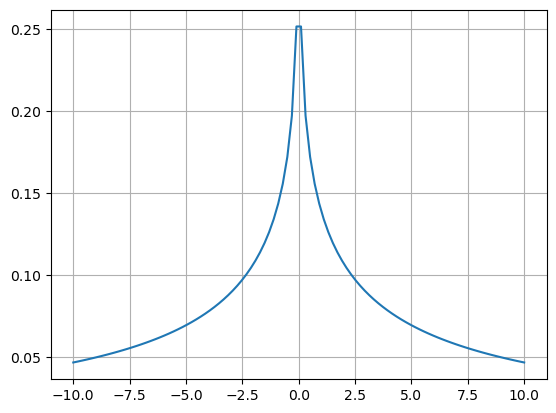

In [48]:
x = 1-np.linspace(-10,10,100)**2/16


plt.plot(np.linspace(-10,10,100),scipy.special.ellipk(x)/(np.sqrt(2)*np.pi**(3/2))/norm)
plt.grid("on")

print(scipy.special.ellipk(1-2**2/16)/(np.sqrt(2)*np.pi**(3/2))/norm)

norm = my_integration2(np.linspace(-10,10,100),scipy.special.ellipk(x)/(np.sqrt(2)*np.pi**(3/2)))

print(my_integration2(np.linspace(-10,10,100),scipy.special.ellipk(x)/(np.sqrt(2)*np.pi**(3/2)))/norm)



print(scipy.special.ellipk(x)/(np.sqrt(2)*np.pi**(3/2))/norm)

In [ ]:
def derivative(X,Y):
    dx = np.diff(X)[4]
    '''out = np.zeros((len(Y)))
    
    out[0] = (Y[1]-Y[0])/dx
    out[-1] = (Y[-1]-Y[-2])/dx
    for i in range(1,len(Y)-1):
        out[i] = (Y[i+1]-Y[i-1])/(2*dx)'''
    
    out = np.gradient(Y,dx)
        
    return out


def find_first_zeros(X,Y):
    roots = []
    dx = np.diff(X)[0]
    for i in range(1,len(Y)):
        norm = np.abs(Y[i]-Y[i-1])
        if (Y[i]*Y[i-1] < 0):
            #print(i)
            roots.append(X[i-1]+np.abs(Y[i-1])*dx/norm)
    return roots
        

In [12]:
def order_3(J,U,T):
    lbda = 2*J**2/U
    
    out = jv(0,2*T)
    out = out - lbda*2j*T*jv(2,2*T)
    out = out - (lbda*T)**2*(jv(4,2*T)+jv(0,2*T))
    out = out + (lbda*T)**3*(jv(2,2*T)+jv(6,2*T)/3)*1j
    
    return out


def order_4(J,U,T):
    lbda = 2*J**2/U
    
    out = jv(0,2*T)
    out = out - lbda*2j*T*jv(2,2*T)
    out = out - (lbda*T)**2*(jv(4,2*T)+jv(0,2*T))
    out = out + (lbda*T)**3*(jv(2,2*T)+jv(6,2*T)/3)*1j
    out = out + (lbda*T)**4*(1/1)*(1*jv(0,2*T)+1*jv(4,2*T)+jv(8,2*T))
    
    return out


def order_n(J,U,T,n):
    lbda = 2*J**2/U
    out = 0
    for k in range(n):
        factor = (-1j*lbda*T)**k
        out2 = 0
        for i in range(k+1):
            out2 = out2 + 1/(math.factorial(k-i)*math.factorial(i))*jv(2*np.abs(k-2*i),2*T)
        out = out + factor*out2
        
    return np.abs(out)**2

def find_minimum(X,Y):
    for i in range(1,len(Y)-1):
        if (Y[i]<=Y[i-1]) and (Y[i] <= Y[i+1]):
            return X[i], Y[i]
        

In [96]:
T = np.linspace(0,4,500)
#Us = np.linspace(6,50,500)
Us = np.array([5,10,20])
plot_analytical_order3 = np.zeros((len(Us),len(T)))
plot_root = []
plot_height = []
for u in range(len(Us)):
    if (u%40 == 0):
        print(u)
    for t in range(len(T)):
        plot_analytical_order3[u,t] = order_n(1,Us[u],T[t],4)
    Y = plot_analytical_order3[u]
    
    t0, y0 = find_minimum(T,Y)
    
    plot_root.append(t0)
    plot_height.append(y0)
        



0


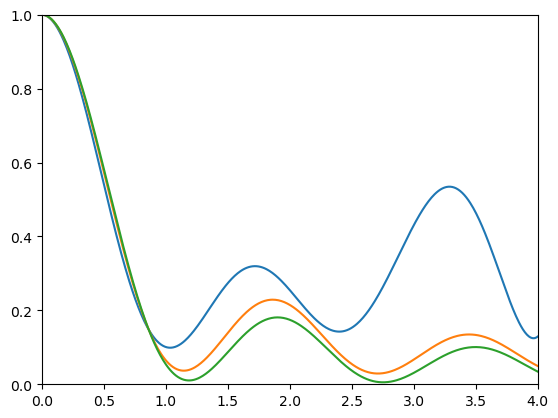

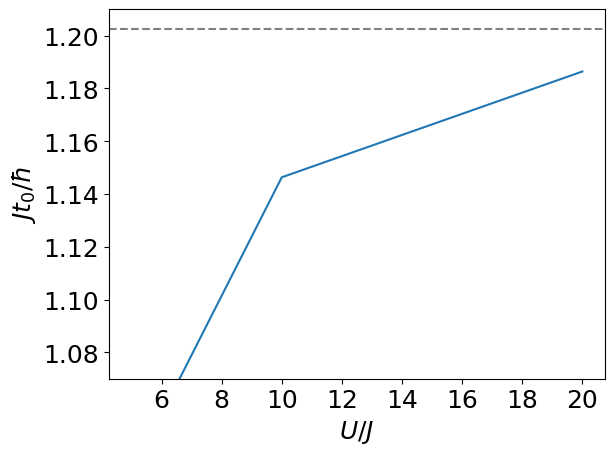

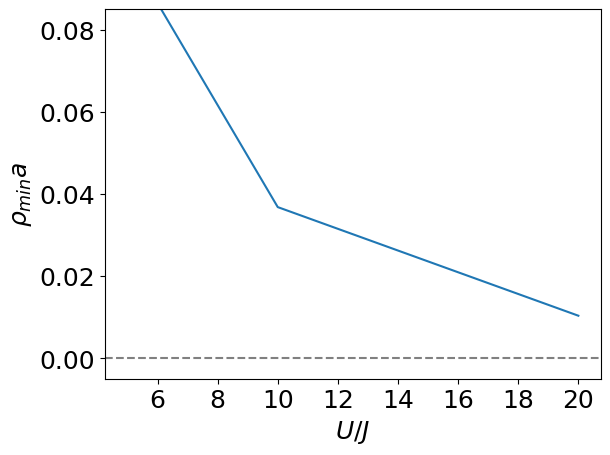

In [97]:
#print(find_minimum(T,plot_analytical_order3))


for u in range(len(Us)):
    plt.plot(T,plot_analytical_order3[u], label = "U = "+str(Us[u]))
plt.ylim([0,1])
plt.xlim([0,4])
#plt.legend()
plt.show()

plt.plot(Us,plot_root)

plt.xlabel(r"$U/J$", fontsize = 18)
plt.ylabel(r"$Jt_0/\hbar$", fontsize = 18)
plt.axhline(y=1.202412, color='gray', linestyle='--', label = r"$U \to \infty$")
plt.ylim([1.07,1.21])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.legend(fontsize = 14)
#plt.ylim([1.18,1.2])
#plt.yticks(np.arange(1.1875, 1.2, step=0.003))
plt.show()

plt.plot(Us,plot_height)

plt.xlabel(r"$U/J$", fontsize = 18)
plt.ylabel(r"$\rho_{min}a$", fontsize = 18)
plt.axhline(y=0, color='gray', linestyle='--', label = r"$U \to \infty$")
plt.ylim([-0.005,0.085])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.legend(fontsize = 14)
#plt.ylim([1.18,1.2])
#plt.yticks(np.arange(1.1875, 1.2, step=0.003))
plt.show()



In [33]:
def create_H_contact_sparse(basis_dict1,basis_dict2,J,U):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        #print(i)
        #print("Basis element",i)
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            #print("Site: ", site)
            for species in range(2):                  
                factor, newket = hopping_left(site,species,ket)
                key = basis_dict2.get(str(newket), -1)

                if ((key) != -1):
    
                    H[key,i] = H[key,i] + factor*(-J)   
                factor, newket = hopping_right(site,species,ket)
                key = basis_dict2.get(str(newket), -1)

                if ((key) != -1):
   
                    H[key,i] = H[key,i] + factor*(-J)
                    
                factor, newket = n(site,species,ket)

                key = basis_dict2.get(str(newket), -1)
         
                if (key != -1):
                 
                    H[key,i] = H[key,i] + factor*(factor-1)*U/2

    return H


def canonical_to_fock2(basis,vector):
    output_vectors = []
    output_factors = []
    for i in range(len(vector)):
        if (vector[i] != 0):
            output_vectors.append(basis[i])
            output_factors.append(vector[i])
    return output_factors, output_vectors

def density_fock_state2(state,site):
    op_state = state.copy()
    dens = 0
    
    factor, vector = n_alternative(site,0,op_state)
    dens = dens + factor
    return dens


def density_of_state_canonical2(basis, state, site):
    output_factors, output_vectors = canonical_to_fock2(basis,state)
    dens = 0
    for i in range(len(output_factors)):
        ket = output_vectors[i]
        factor = output_factors[i]
        
        occupation = density_fock_state2(ket,site)
        
        dens = dens + np.abs(factor)**2*occupation
    
    dens = dens.real
    return dens

def n_alternative(i,species,ket):
    outket = ket.copy()
    
    if (i < 0):
        i = i + len(outket)
    if (i > len(outket)-1):
        i = i - len(outket)
    if (ket[i,0] != 0):
        factor = 0
    if (ket[i,0] == 0):
        factor = 1
    return factor, outket


In [88]:
Ns = 7
Na = 6
Nb = 0

basis = create_whole_basis(Na,Nb,Ns)

J = 1

time_spacing = 0.01
max_time = 3


T = np.arange(0,max_time + time_spacing,time_spacing)



    

Us = np.array([5,10,20,50,80,200])
Us = np.array([10])


plot = np.zeros((len(Us), len(T)))
plot_each_site = np.zeros((len(Us), len(T), Ns))
overlaps = np.zeros((len(Us),len(basis)))

for u in range(len(Us)):
    '''
    #single particle case:
    v0 = np.zeros((Ns,2))
    v0[Ns//2,0] = 1'''

    #single hole case:
    v0 = np.ones((Ns,2))
    for i in range(len(v0)):
        v0[i,1] = 0
    v0[Ns//2,0] = 0

    for i in range(len(basis)):
        if np.array_equal(basis[i],v0):
            result = i


    basis_dict1 = {}
    basis_dict2 = {}
    for i in range(len(basis)):
        basis_dict1[i] = basis[i]
        basis_dict2[str(basis[i])] = i

    v0_canonical = np.zeros((len(basis)), dtype = complex)
    v0_canonical[result] = 1
    
    #print("v0 canonical is", v0_canonical)
    print(basis[result])
    v0_canonical = v0_canonical.T
    
    H = create_H_contact_sparse(basis_dict1,basis_dict2,1,Us[u])
    H = H.todense()
    #H[0,1] = H[0,1]*(1 + 0.0000001j)
    #H[1,0] = H[1,0]*(1 - 0.0000001j)
    #print(H)
    print("I already built H")
    print("Initial density is: ",density_of_state_canonical2(basis, v0_canonical, Ns//2))
    #vaps, veps = LA.eigh(H)
    
    #veps = veps.T

    #for i in range(len(veps)):
     #   overlaps[u,i] = np.abs(np.dot(np.conj(v0_canonical),veps[i]))**2

    
    time_ev = time_evolution_operator(H,time_spacing)
    plot[u,0] = (round(np.real(density_of_state_canonical(basis, v0_canonical, Ns//2)),3))
    for site in range(Ns):
        plot_each_site[u,0,site] = round(np.real(density_of_state_canonical(basis, v0_canonical, site)),3)
    for t in range(1,len(T)):
        if (t%(max_time/time_spacing/10) == 0):
            print(t)
        v0_canonical = time_ev@v0_canonical
        v0_canonical = v0_canonical/LA.norm(v0_canonical)
        plot[u,t] = (round(np.real(density_of_state_canonical(basis, v0_canonical, Ns//2)),3))
        for site in range(Ns):
            plot_each_site[u,t,site] = round(np.real(density_of_state_canonical(basis, v0_canonical, site)),3)
        
        


[[1 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]]
I already built H
Initial density is:  1.0
30
60
90
120
150
180
210
240
270
300


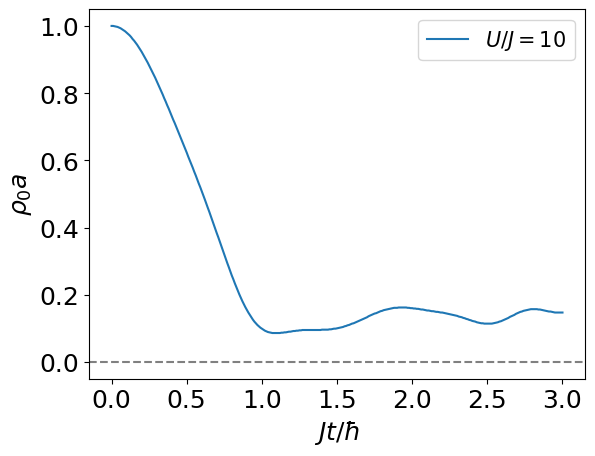

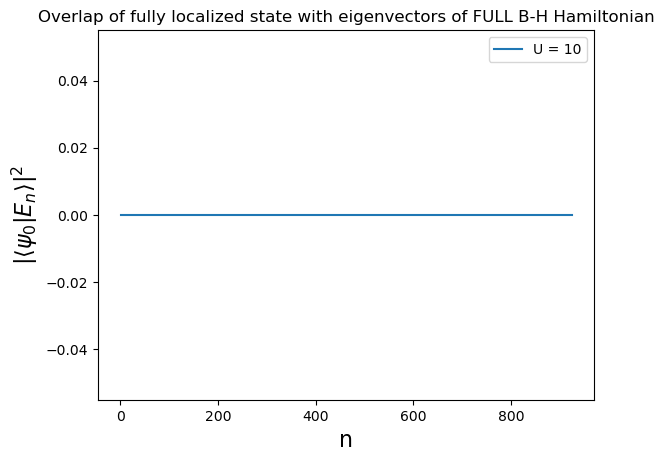

In [89]:
for u in range(len(Us)):
    plt.plot(T,1-plot[u], label = r"$U/J = $"+str(Us[u]))
    
    
#plt.xlim([-0.005,0.4])
plt.axhline(y=0, ls = "--", color = "Gray")
plt.xlabel(r"$Jt/\hbar$", fontsize = 18)
plt.ylabel(r"$\rho_0a$", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 15)
#plt.title(r"$N_s = 7$")
plt.show()


for u in range(len(Us)):
    plt.plot(np.arange(1,len(basis)+1),overlaps[u], label = "U = "+str(Us[u]))
    
    
plt.legend()
plt.xlabel("n", fontsize = 16)
plt.ylabel(r"$\left|\langle\psi_0|E_n\rangle\right|^2$", fontsize = 16)
plt.title("Overlap of fully localized state with eigenvectors of FULL B-H Hamiltonian")
plt.show()

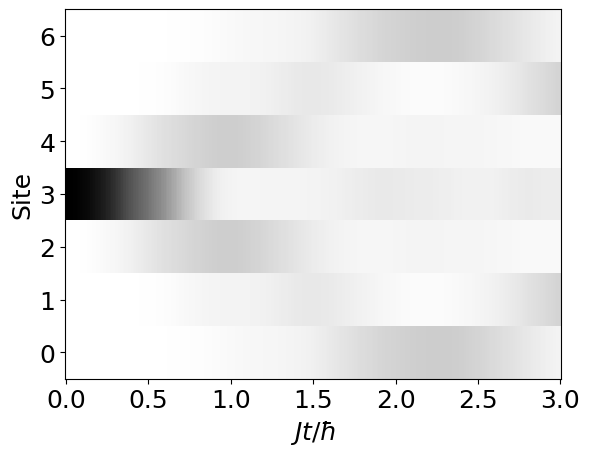

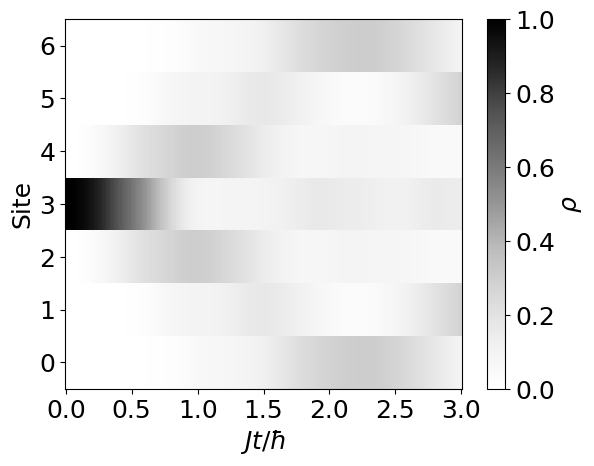

In [92]:
Nsites = np.arange(0,Ns)
#for u in range(len(Us)):
for u in range(1):
    #plt.contourf(T,Nsites,1-plot_each_site[u].T,levels=100,cmap = "Greys")
    plt.pcolormesh(T,Nsites,1-plot_each_site[u].T,cmap = "Greys")
    #plt.show()
    plt.xlabel(r"$Jt/\hbar$", fontsize = 18)
    plt.ylabel("Site", fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    #plt.xlim([0,0.1])
    #plt.title(r"$\rho(x,t)$, $N_s = 7$, $U = $"+str(Us[u]))
    
    #plt.colorbar_tick_params(fontsize = 18)
    #plt.colorbar()
    #cbar.tick_params(labelsize = 14)
    #plt.tick_params(labelsize=14)
    #plt.tick_params(size = 16)
    #cbar.ax.tick_params(labelsize=10) 
    plt.show()
    
#print(plot_each_site[1,:])




fig, ax0 = plt.subplots(nrows=1)

im = ax0.pcolormesh(T,Nsites,1-plot_each_site[u].T,cmap = "Greys")
cb = fig.colorbar(im, ax=ax0)
#ax0.set_title('pcolormesh with levels')
#im.figure.axes[1].tick_params(axis="y", labelsize=18)


im.figure.axes[1].tick_params(axis="y", labelsize=18)
cb.set_label(label=r'$\rho$',weight='bold', size = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel(r"$Jt/\hbar$", fontsize = 18)
plt.ylabel("Site", fontsize = 18)

# contours are *point* based plots, so convert our bound into point
# centers
#cf = ax1.contourf(x[:-1, :-1] + dx/2.,
 #                 y[:-1, :-1] + dy/2., z, levels=levels,
                 # cmap=cmap)



# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
#fig.tight_layout()

plt.show()

In [ ]:
def one_over_m_positive(H,Ns):
    vaps,veps = LA.eigh(H)
    veps = veps.T
    
    dq = 2*np.pi/Ns
    
    return 2*(vaps[1]-vaps[0])/dq**2

def one_over_m_negative(H,Ns):
    vaps,veps = LA.eigh(H)
    veps = veps.T
    
    dq = 2*np.pi/Ns
    
    return 2*(-vaps[-Ns]+vaps[-(Ns-1)])/dq**2





Ns = 8
Na = 7
Nb = 0

basis = create_whole_basis(Na,Nb,Ns)

J = 1


ratios1 = np.linspace(-1,0.3,140)
ratios2 = np.linspace(0.3,8,50)
#ratios3 = np.linspace(0.75,8,15)

#print(ratios1)
#print(ratios2)
#ratios2 = np.linspace(1,10,20)
#ratios = np.concatenate((ratios1,ratios2))
#print(new_ratios)
ratios = np.concatenate((ratios1,ratios2))
Us = 1/ratios



print(ratios)
print(Us)

#Us = np.array([1000])


#Us = np.linspace(3,10.5,14)




basis_dict1 = {}
basis_dict2 = {}
for i in range(len(basis)):
    basis_dict1[i] = basis[i]
    basis_dict2[str(basis[i])] = i

    
inverse_masses = []
    
for u in range(len(Us)):
    H = create_H_contact_sparse(basis_dict1,basis_dict2,1,Us[u])
    H = H.todense()
    print(u)
    if (Us[u] < 0): 
        inverse_masses.append(one_over_m_negative(H,Ns))
    elif (Us[u] > 0): 
        inverse_masses.append(one_over_m_positive(H,Ns))






In [ ]:
#print(inverse_masses)
inverse_masses = np.array(inverse_masses)
#print(inverse_masses)

#print(1/inverse_masses)
plt.plot(ratios,inverse_masses,"bs",markersize = 3, label = r"$\frac{2(E_1 - E_0)}{dq^2}$")


plt.plot(np.linspace(-0.5,0.5,2000),np.abs(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "green", lw = 2,label = r"Analytical $\frac{1}{|m^{*}|}$, $q = 0$, $H_{eff}$")
plt.plot(np.linspace(-0.5,0.5,2000),(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "red", lw = 2,label = r"Analytical $\frac{1}{m^{*}}$, $q = 0$, $H_{eff}$")
plt.axhline(y=2, ls = "--", color = "Gray")
plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
plt.axvline(x=-1/8, ls = "--", color = "Gray")
plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
plt.ylabel(r"$\frac{1}{Jm^{*}}$", fontsize = 16)
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylim([-2,7])
plt.legend()
plt.xlim([-0.5,0.8])
plt.ylim([-0.5,6])
plt.show()



plt.plot(ratios,1/inverse_masses,  "bs",markersize = 3,label = r"$\frac{2(E_1 - E_0)}{dq^2}$")


plt.plot(np.linspace(-10,10,20000),1/np.abs(linear_mass_q0(np.linspace(-10,10,20000))), color = "red", lw = 2,label = r"$\left|\frac{1}{2J + \frac{16J^2}{U}}\right|$, $q = 0$, $H_{eff}$")
plt.axhline(y=1/2, ls = "--", color = "Gray")
plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
plt.axvline(x=-1/8, ls = "--", color = "Gray")
plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
plt.ylabel(r"$m^{*}$", fontsize = 16)
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylim([-2,7])
plt.legend()
plt.xlim([-0.4,0.5])
plt.ylim([-0,2])
plt.show()

In [6]:
def create_H_J_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor1, newket1 = hopping_left(site,species,ket)
                key = basis_dict2.get(str(newket1), -1)
                if ((key) != -1):
                    H[key,i] = H[key,i] + factor1*(-1)
                    
                factor2, newket2 = hopping_right(site,species,ket)
                key = basis_dict2.get(str(newket2), -1)
                if ((key) != -1):
                    H[key,i] = H[key,i] + factor2*(-1)
    #H = H.todense()
    return H


def create_H_U_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor, newket = n(site,species,ket)
                key = basis_dict2.get(str(newket), -1)
                if (key != -1):
                    H[key,i] = H[key,i] + factor*(factor-1)*1/2
                    
    #H = H.todense()
    return H


def create_H_V_sparse(basis_dict1,basis_dict2):
    H = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    #H = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    for i in basis_dict1:
        ket = basis_dict1[i]
        for site in range(len(basis_dict1[0])):
            for species in range(2):                  
                factor1, newket = n(site,species,ket)
                factor2, newket = n(site+1,species,newket)
                key = basis_dict2.get(str(newket), -1)
                if (key != -1):
                    H[key,i] = H[key,i] + factor1*factor2
                    
    #H = H.todense()
    return H


def one_over_m_positive(H,Ns):
    #vaps,veps = LA.eigh(H)
    
    vaps_GS = eigs(H, k = Ns, which='SR', return_eigenvectors = False)
    #veps = veps.T
    vaps_GS = np.real(vaps_GS)
    vaps_GS = np.sort(vaps_GS)
    #print(vaps_GS)
    dq = 2*np.pi/Ns
    
    return 2*(vaps_GS[1]-vaps_GS[0])/dq**2
    #return 2*(vaps_GS[1]-vaps_GS[0])/np.sin(dq)**2


def one_over_m_negative(H,Ns):
    #vaps,veps = LA.eigh(H)
    vaps_ES, veps = eigs(H, k = Ns, which='LR')
    #veps = veps.T
    vaps_ES = np.real(vaps_ES)
    vaps_ES = np.sort(vaps_ES)
    #print(vaps_ES)
    dq = 2*np.pi/Ns
    
    #return 2*(vaps_ES[1]-vaps_ES[0])/dq**2
    return 2*(vaps_ES[-1]-vaps_ES[-2])/dq**2
    #return 2*(vaps_ES[1]-vaps_ES[0])/np.sin(dq)**2


Ns now is 3
0
19
38
57
76
95
114
133
152
171
190


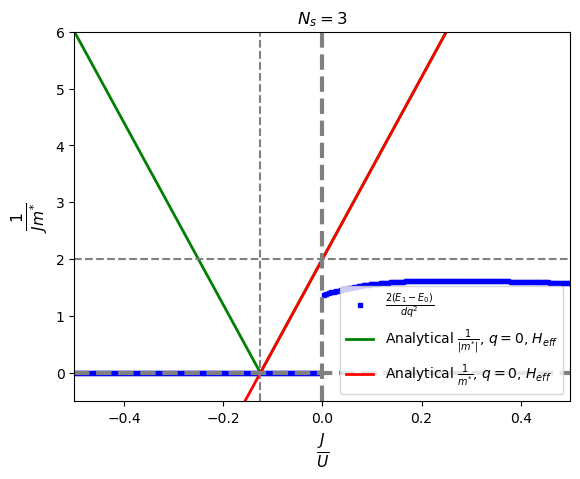

Ns now is 4
0
19
38
57
76
95
114
133
152
171
190


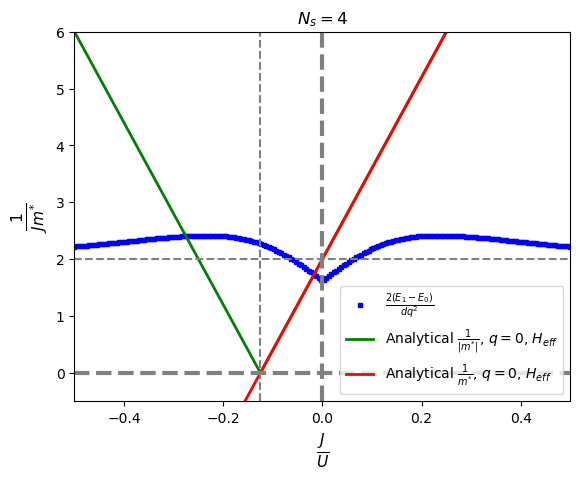

Ns now is 5
0
19
38
57
76
95
114
133
152
171
190


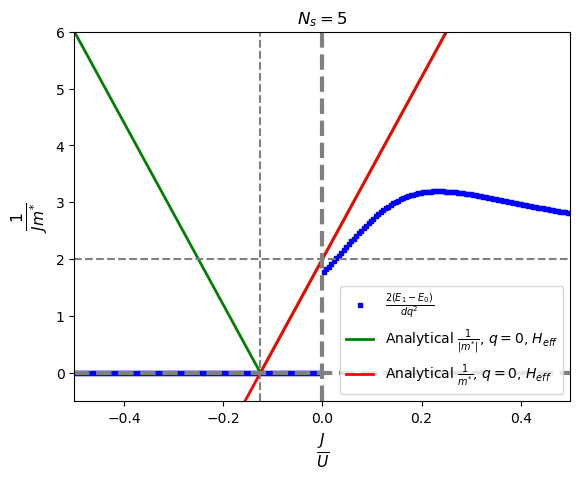

Ns now is 6
0
19
38
57
76
95
114
133
152
171


KeyboardInterrupt: 

In [143]:
J = 1
NS = np.arange(3,12)

#ratios1 = np.linspace(-8,0.3,140)
#ratios2 = np.linspace(0.3,8,50)
#ratios = np.concatenate((ratios1,ratios2))

ratios = np.linspace(-0.5,0.5,200)
Us = 1/ratios



inverse_masses = np.zeros((len(NS),len(Us)))

#print(inverse_masses)

for k in range(len(NS)):

    Ns = NS[k]
    Na = Ns-1
    Nb = 0
    print("Ns now is", Ns)
    basis = create_whole_basis(Na,Nb,Ns)

    basis_dict1 = {}
    basis_dict2 = {}
    for i in range(len(basis)):
        basis_dict1[i] = basis[i]
        basis_dict2[str(basis[i])] = i



    HJ = create_H_J_sparse(basis_dict1,basis_dict2)
    HU =  create_H_U_sparse(basis_dict1,basis_dict2)

    #print(HJ)
    for u in range(len(Us)):
        
        H = J*HJ + Us[u]*HU
        
        if (u%19 == 0):
            print(u)
            
        if (Us[u] < 0):
            #print(u)
            inverse_masses[k,u] = one_over_m_negative(H,Ns)
            
            #inverse_masses2.append(one_over_m_negative(H,Ns))
        elif (Us[u] > 0):
            inverse_masses[k,u] = one_over_m_positive(H,Ns)
            #inverse_masses2.append(one_over_m_positive(H,Ns))
            
    plt.plot(ratios,inverse_masses[k],"bs",markersize = 3, label = r"$\frac{2(E_1 - E_0)}{dq^2}$")
    plt.plot(np.linspace(-0.5,0.5,2000),np.abs(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "green", lw = 2,label = r"Analytical $\frac{1}{|m^{*}|}$, $q = 0$, $H_{eff}$")
    plt.plot(np.linspace(-0.5,0.5,2000),(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "red", lw = 2,label = r"Analytical $\frac{1}{m^{*}}$, $q = 0$, $H_{eff}$")
    plt.axhline(y=2, ls = "--", color = "Gray")
    plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
    plt.axvline(x=-1/8, ls = "--", color = "Gray")
    plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
    plt.ylabel(r"$\frac{1}{Jm^{*}}$", fontsize = 16)
    plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
    plt.title(r"$N_s = $"+str(NS[k]))
    #plt.ylim([-2,7])
    plt.legend()
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,6])
    plt.show()
    



In [ ]:
for k in range(len(NS)):
    plt.plot(ratios,inverse_masses[k],"bs",markersize = 3, label = r"$\frac{2(E_1 - E_0)}{dq^2}$")
    plt.plot(np.linspace(-0.5,0.5,2000),np.abs(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "green", lw = 2,label = r"Analytical $\frac{1}{|m^{*}|}$, $q = 0$, $H_{eff}$")
    plt.plot(np.linspace(-0.5,0.5,2000),(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "red", lw = 2,label = r"Analytical $\frac{1}{m^{*}}$, $q = 0$, $H_{eff}$")
    plt.axhline(y=2, ls = "--", color = "Gray")
    plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
    plt.axvline(x=-1/8, ls = "--", color = "Gray")
    plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
    plt.ylabel(r"$\frac{1}{Jm^{*}}$", fontsize = 16)
    plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
    plt.title(r"$N_s = $"+str(NS[k]))
    #plt.ylim([-2,7])
    plt.legend()
    plt.xlim([-1,1])
    plt.ylim([-0.5,8])
    plt.show()

In [144]:
#print(inverse_masses)
inverse_masses2 = np.array(inverse_masses2)
#print(inverse_masses)

#print(1/inverse_masses)
plt.plot(ratios,inverse_masses2,"bs",markersize = 3, label = r"$\frac{2(E_1 - E_0)}{dq^2}$")
plt.plot(np.linspace(-0.5,0.5,2000),np.abs(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "green", lw = 2,label = r"Analytical $\frac{1}{|m^{*}|}$, $q = 0$, $H_{eff}$")
plt.plot(np.linspace(-0.5,0.5,2000),(linear_mass_q0(np.linspace(-0.5,0.5,2000))), color = "red", lw = 2,label = r"Analytical $\frac{1}{m^{*}}$, $q = 0$, $H_{eff}$")
plt.axhline(y=2, ls = "--", color = "Gray")
plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
plt.axvline(x=-1/8, ls = "--", color = "Gray")
plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
plt.ylabel(r"$\frac{1}{Jm^{*}}$", fontsize = 16)
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylim([-2,7])
plt.legend()
#plt.xlim([-0.5,0.8])
plt.ylim([-0.5,6])
plt.show()



plt.plot(ratios,1/inverse_masses2,  "bs",markersize = 3,label = r"$\frac{2(E_1 - E_0)}{dq^2}$")


plt.plot(np.linspace(-10,10,20000),1/np.abs(linear_mass_q0(np.linspace(-10,10,20000))), color = "red", lw = 2,label = r"$\left|\frac{1}{2J + \frac{16J^2}{U}}\right|$, $q = 0$, $H_{eff}$")
plt.axhline(y=1/2, ls = "--", color = "Gray")
plt.axhline(y=0, ls = "--", color = "Gray", lw = 3)
plt.axvline(x=-1/8, ls = "--", color = "Gray")
plt.axvline(x=0, ls = "--", color = "Gray", lw = 3)
plt.ylabel(r"$m^{*}$", fontsize = 16)
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylim([-2,7])
plt.legend()
plt.xlim([-0.4,0.5])
plt.ylim([-0,2])
plt.show()

NameError: name 'inverse_masses2' is not defined

In [ ]:
Ns = 5
Na = 4
Nb = 0

J = 1

basis = create_whole_basis(Na,Nb,Ns)


basis_dict1 = {}
basis_dict2 = {}
for i in range(len(basis)):
    basis_dict1[i] = basis[i]
    basis_dict2[str(basis[i])] = i



HJ = create_H_J_sparse(basis_dict1,basis_dict2)
HU = create_H_U_sparse(basis_dict1,basis_dict2)

ratios = np.linspace(-4,4,1000)
Us = 1/ratios

plot = np.zeros((len(basis),len(ratios)))

print(ratios)

plot_U_negative = np.zeros((Ns,len(ratios)))
plot_U_positive = np.zeros((Ns,len(ratios)))

inverse_masses = []

for u in range(len(Us)):
    
    #H = H_eff_mott(Ns,J,Us[u])
    
    H = J*HJ + Us[u]*HU
    
    #vaps,veps = LA.eigh(H)
    if (Us[u] < 0):
        vaps_ES = eigs(H, k = Ns, which='LR',return_eigenvectors = False)
        vaps_ES = np.real(vaps_ES)
        vaps_ES = np.sort(vaps_ES)
        for i in range(Ns):
            plot_U_negative[i,u] = vaps_ES[i]
            
        inverse_masses.append(2*(plot_U_negative[-1,u]-plot_U_negative[-2,u])/(2*np.pi/Ns)**2)
    if (Us[u] > 0):
        vaps_GS = eigs(H, k = Ns, which='SR', return_eigenvectors = False)
        vaps_GS = np.real(vaps_GS)
        vaps_GS = np.sort(vaps_GS)
        for i in range(Ns):
            plot_U_positive[i,u] = vaps_GS[i]
        
        inverse_masses.append(2*(plot_U_positive[1,u]-plot_U_positive[0,u])/(2*np.pi/Ns)**2)
        
inverse_masses = np.array(inverse_masses)

In [ ]:
#print(Us[len(Us)//2-1])


print(2*(plot_U_positive[1,-1]-plot_U_positive[0,-1])/(2*np.pi/Ns)**2)
print(2*(plot_U_negative[-1,0]-plot_U_negative[-2,0])/(2*np.pi/Ns)**2)



#for i in range(Ns):
 #   plt.plot(ratios,plot_U_positive[i], label = "n = "+str(i))
  #  plt.plot(ratios,plot_U_negative[i], label = "n = "+str(i-Ns))
    
plt.plot(ratios[len(ratios)//2:],plot_U_positive[0,len(ratios)//2:], label = "n = "+str(0))
plt.plot(ratios[len(ratios)//2:],plot_U_positive[1,len(ratios)//2:], label = "n = "+str(1))
plt.plot(ratios[:len(ratios)//2],plot_U_negative[-1,:len(ratios)//2], label = "n = max")
plt.plot(ratios[:len(ratios)//2],plot_U_negative[-2,:len(ratios)//2], label = "n = max - 1")
    
plt.xlabel(r"$\frac{J}{U}$")
plt.ylabel("E")
plt.grid("on")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-10,10])
plt.xlim([-4,4])
plt.show()



plt.plot(ratios,inverse_masses)
plt.xlabel(r"$\frac{J}{U}$")
plt.ylabel("E")
plt.xlim([-0.5,0.5])
plt.show()

In [ ]:

#for i in range(0,20,4):
        #plt.plot(ratios[len(ratios)//2:],plot[i,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i), ls = "--")
        #plt.plot(ratios[len(ratios)//2:],plot[i+1,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i+1), ls = "--")
        #plt.plot(ratios[len(ratios)//2:],plot[i+2,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i+2), ls = "--")
        #plt.plot(ratios[len(ratios)//2:],plot[i+3,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i+3), ls = "--")
        #plt.plot(ratios[len(ratios)//2:],plot[i+3,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i+3), ls = "--")
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+1)))
        
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+6),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+6)))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+5),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+5)))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+4),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+4)))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+3),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+3)))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+2),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+2)))
i = 0    
plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2], label = "n = "+str(-(i+1)))
plt.plot(ratios[:len(ratios)//2],plot[-(i+2),:len(plot[i])//2], label = "n = "+str(-(i+2)))
plt.plot(ratios[:len(ratios)//2],plot[-(i+3),:len(plot[i])//2], label = "n = "+str(-(i+3)))
plt.plot(ratios[:len(ratios)//2],plot[-(i+4),:len(plot[i])//2], label = "n = "+str(-(i+4)))
plt.plot(ratios[:len(ratios)//2],plot[-(i+5),:len(plot[i])//2], label = "n = "+str(-(i+5)))
plt.plot(ratios[:len(ratios)//2],plot[-(i+6),:len(plot[i])//2], label = "n = "+str(-(i+6)))

        
        #plt.plot(ratios[len(ratios)//2:],plot[i,len(plot[i])//2:], label = "n = "+str(i), ls = "--")
        #plt.plot(ratios[len(ratios)//2:],plot[i+3,len(plot[i])//2:], label = "n = "+str(i+3), ls = "--")
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2], label = "n = "+str(-(i+1)))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+3+1),:len(plot[i])//2], label = "n = "+str(-(i+3+1)))
        
        #plt.plot(ratios[len(ratios)//2:],plot[i,len(plot[i])//2:], label = "n = "+str(i))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2], label = "n = "+str(-(i+1)))
        
        
        
        #plt.plot(ratios,plot[i]*ratios, label = "n = "+str(-(i+1)))
    
    
    
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylabel(r"$\frac{E}{U}$", fontsize = 16)
plt.ylabel(r"E", fontsize = 16)
plt.ylim([-2,8])
plt.xlim([-2,0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:

for i in range(0,20,4):
        plt.plot(ratios[len(ratios)//2:],plot[i,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i), ls = "--")
        plt.plot(ratios[len(ratios)//2:],plot[i+3,len(plot[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i+3), ls = "--")
        plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+1)))
        plt.plot(ratios[:len(ratios)//2],plot[-(i+3+1),:len(plot[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(-(i+3+1)))
        
        #plt.plot(ratios[len(ratios)//2:],plot[i,len(plot[i])//2:], label = "n = "+str(i))
        #plt.plot(ratios[:len(ratios)//2],plot[-(i+1),:len(plot[i])//2], label = "n = "+str(-(i+1)))
        
        
        
        #plt.plot(ratios,plot[i]*ratios, label = "n = "+str(-(i+1)))
    
    
    
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
#plt.ylabel(r"$\frac{E}{U}$", fontsize = 16)
plt.ylabel(r"E", fontsize = 16)
plt.ylim([-5,5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
Ns = 4
Na = 3
Nb = 0

J = 1

#basis = create_whole_basis(Na,Nb,Ns)

#HJ = build_H_hopping(basis)
#HU = build_H_contact(basis)

ratios = np.linspace(-0.7,0.7,8000)
Us = 1/ratios

#plot_ex = np.zeros((len(basis),len(ratios)))

plot_eff = np.zeros((Ns,len(ratios)))




print(Us)

for u in range(len(Us)):
    
    H = H_eff_mott(Ns,J,Us[u])
    
    #H = J*HJ + Us[u]*HU
    vaps,veps = LA.eigh(H)
    
    for i in range(Ns):
        plot_eff[i,u] = vaps[i]

In [ ]:
for i in range(0,4,3):
        plt.plot(ratios[len(ratios)//2:],plot_eff[i,len(plot_eff[i])//2:]*(ratios[len(ratios)//2:]), label = "n = "+str(i))
        plt.plot(ratios[:len(ratios)//2],plot_eff[i,:len(plot_eff[i])//2]*(ratios[:len(ratios)//2]), label = "n = "+str(i))
        
        #plt.plot(ratios[len(ratios)//2:],plot_eff[i,len(plot_eff[i])//2:], label = "n = "+str(i))
        #plt.plot(ratios[:len(ratios)//2],plot_eff[i,:len(plot_eff[i])//2], label = "n = "+str(i))
        
        
        
        #plt.plot(ratios,plot[i]*ratios, label = "n = "+str(-(i+1)))
    
    
    
plt.xlabel(r"$\frac{J}{U}$")
plt.ylabel(r"$\frac{E}{U}$")

plt.legend()
plt.show()

In [ ]:
def plane_wave_2particles(k1,k2,basis):
    out = np.zeros((len(basis)), dtype = complex)
    Ns = len(basis[0])
    vector_Ks = np.array([k1,k2])
    
    
    for i in range(len(basis)):
        fock_state = basis[i]
        #print("element: ",i)
        factor1 = 1
        boolean = True
        for site in range(0,Ns):
        
            if (fock_state[site,0] == 1) and (boolean == True):
                
                #print("here, site",site)
                factor1 = factor1*np.exp(1j*k1*(-(Ns-1)/2 + site))
                boolean = False
            elif (fock_state[site,0] == 1) and (boolean == False):
                #print("here, site", site)
                factor1 = factor1*np.exp(1j*k2*(-(Ns-1)/2 + site))*2
            elif (fock_state[site,0] == 2):
                #print("here just 2: ", site)
                factor1 = factor1*np.exp(1j*k1*(-(Ns-1)/2 + site))*np.exp(1j*k2*(-(Ns-1)/2 + site))*np.sqrt(2)
        
        out[i] = factor1
        
        
    out = out/LA.norm(out)
    
    return out




def plane_wave_2particles_alternative(k1,k2,basis):
    out = np.zeros((len(basis)), dtype = complex)
    Ns = len(basis[0])
    
    for i in range(Ns):
        for j in range(Ns):
            vector = np.zeros((Ns,2), dtype = int)
            vector[i,0] = vector[i,0] + 1
            vector[j,0] = vector[j,0] + 1
            
            #print("beefore checking: ", vector)
            for k in range(len(basis)):
                if np.array_equal(vector,basis[k]):
                    #print("This is reached")
                    #print(basis[k])
                    out[k] = out[k] + np.exp(1j*k1*i)*np.exp(1j*k2*j)
        
    out = out/Ns
    out = out/LA.norm(out)
    
    return out
                

In [6]:
Ns = 6
Na = Ns-1
Nb = 0

basis = create_whole_basis(Na,Nb,Ns)

HJ = build_H_hopping(basis)
HU = build_H_contact(basis)
HV = build_H_fn(basis)


In [32]:
def hopping_from_i_to_j(ket,i,j):
    in_ket = ket.copy()
    factor1, newket = c(in_ket,i,0)
    factor2, newket = c_dagger(newket,j,0)
    return factor1*factor2, newket

def create_Q_matrix(basis_dict1,basis_dict2):
    #Q = lil_matrix((len(basis_dict1),len(basis_dict1)), dtype = complex)
    Q  = np.zeros((len(basis_dict1),len(basis_dict1)), dtype = complex)
    
    Ns = len(basis_dict1[1])
    
    #print("Ns is",Ns)
    
    if (Ns%2 == 0):
        for ket_number in basis_dict1:
            ket = basis_dict1[ket_number]
            for i in range(Ns):
                for j in range(Ns):
                    factorq = 0
                    for k in range(-Ns//2,Ns//2,1):
                        q = 2*np.pi/Ns*k
                        factorq = factorq + q*np.exp(1j*q*(j - i))
                    factor_ket, newket = hopping_from_i_to_j(ket,i,j)
                    factor = factor_ket*factorq
                    key = basis_dict2.get(str(newket), -1)
                    if (key != -1):
                        Q[key,ket_number] = Q[key,ket_number] + factor
                        
    if (Ns%2 != 0):
        for ket_number in basis_dict1:
            ket = basis_dict1[ket_number]
            for i in range(Ns):
                for p in range(Ns):
                    factorq = 0
                    for k in range(-(Ns-1)//2,(Ns-1)//2+1,1):
                        q = 2*np.pi/Ns*k
                        argument = q*(i-p)
                        factorq = factorq + q*np.cos(argument) + q*np.sin(argument)*1j
                    factor_ket, newket = hopping_from_i_to_j(ket,i,p)
                    factor = factor_ket*factorq
                    key = basis_dict2.get(str(newket), -1)
                    if (key != -1):
                        Q[key,ket_number] = Q[key,ket_number] + factor

    return Q/Ns



#NS = np.arange(3,9)
NS = np.array([4,6,8])
#NS = np.arange(5,7)

#Us = np.array([-20,-10,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,20])
#Us = np.array([0,1,2,3,4,5,6,7,8,9])
#Us = np.array([0])
#ratios = np.linspace(-1,1,200)

ratios = np.linspace(-0.5,0.5,21)
#print(ratios)
#print(ratios)
print(ratios)
Us = 1/(ratios+0.00001)
#print(Us)
#Us = np.linspace(0,50,51)
#Us = np.arange(0,26,1)
#Us = np.array([0])
#Us1 = np.array([0,0.1,0.2,0.3,0.4,0.5])
#Us2 = np.arange(1,11)
#Us2 = np.append(Us2,200)
#Us = np.concatenate((Us1,Us2))

#Us = np.array([20])
#Us = np.array([0,1,4,5,8,10,15,20,50,100])
#Us = np.array([1,2,3])

#Us = np.array([3,10,20,-3,-10,-20])
#Us = np.array([0.3,-0.3,3,-3,10,-10,0])
#Us = np.array([-3.3,3.3])
#Vs = np.array([-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10])
#Us = np.array([-10,-8,-6,-4,-2,-1,1,2,4,6,8,10])
#Vs = np.array([3,-3,10,-10,20,-20,0])
#Vs = np.array([0,-0.5,-1,-1.5])
#Vs = np.linspace(-1.5,0,20)
Vs = np.array([0])
#Us = np.array([-3.6])
#Us = np.linspace(-4,4,40)

plot_diff_NS = []
plot_eff_masses = np.zeros((len(Us),len(Vs)))

Inverse_masses = np.zeros((len(Us),len(Vs), 2))
Sound_speeds = np.zeros((len(Us),len(Vs), 2))
Shifts = np.zeros((len(Us),len(Vs), 2))
#plot_bands = np.zeros((len(Us)))


for ns in range(len(NS)):
    print("Ns = ",NS[ns])
    Ns = NS[ns]
    Na = Ns-1
    Nb = 0

    basis = create_whole_basis(Na,Nb,Ns)

    basis_dict1 = {}
    basis_dict2 = {}
    for i in range(len(basis)):
        basis_dict1[i] = basis[i]
        basis_dict2[str(basis[i])] = i


    Q = create_Q_matrix(basis_dict1,basis_dict2)
    HJ = create_H_J_sparse(basis_dict1,basis_dict2)
    HU = create_H_U_sparse(basis_dict1,basis_dict2)
    HV = create_H_V_sparse(basis_dict1,basis_dict2)
    #HU = HU.todense()
    #HJ = HJ.todense()

    Second_band = np.zeros((Ns))

    

    Momenta = np.zeros((len(Us),len(Vs),len(basis)))
    Energy = np.zeros((len(Us),len(Vs),len(basis)))


    

    plot_bands = np.zeros((len(Us),len(Vs), Ns, 4))
    print("reached this")
    for __ in range(len(Vs)):
        print(__,":")
        for _ in range(len(Us)):
            print(_)
            H = 1*HJ + Us[_]*HU + Vs[__]*HV

            vaps_q, veps_q = LA.eigh(Q)

            H_Q = np.conj((veps_q).T)@H@veps_q

            vaps_q_1bz = np.zeros((len(vaps_q)))
            veps_q_1bz = np.zeros((len(veps_q)))

            for i in range(len(basis)):
                q = vaps_q[i]
                vaps_q_1bz[i] = move_to_1bz(q)


            veps_q = veps_q.T


            order = np.argsort(vaps_q_1bz)    


            H_Q_ordered = H_Q[order].T[order].T


            H_Q_ordered_imag = np.imag(H_Q_ordered)
            H_Q_ordered_real = np.real(H_Q_ordered)

            for i in range(len(H_Q_ordered_imag)):
                for j in range(len(H_Q_ordered_imag)):
                    if (np.abs(H_Q_ordered_imag[i,j]) < 1e-8):
                        H_Q_ordered_imag[i,j] = 0
                    if (np.abs(H_Q_ordered_real[i,j]) < 1e-8):
                        H_Q_ordered_real[i,j] = 0

            #H_Q_ordered_imag[np.abs(H_Q_ordered_imag) < 1e-8] = 0
            #H_Q_ordered_real[np.abs(H_Q_ordered_imag) < 1e-8] = 0


            H_Q_ordered = H_Q_ordered_real + 1j*H_Q_ordered_imag


            H_Q_ordered = lil_matrix((H_Q_ordered))
            #print(np.max(H_Q_ordered- np.conj(H_Q_ordered.T)))

            momenta = vaps_q_1bz[order]
            energies = diagonalization_per_block(momenta,H_Q_ordered)

            for i in range(len(basis)):
                Energy[_,__,i] = energies[i]
                Momenta[_,__,i] = momenta[i]
            #print(Energy[0,0])
            bands = find_EQ1_EQ2(Momenta[_,__],Energy[_,__], Ns)
            #print(bands)
            
            for nss in range(Ns):
                for k in range(4):
                    plot_bands[_,__,nss,k] = bands[nss,k]




            #Inverse_masses[_,0], Sound_speeds[_,0], Shifts[_,0] = curve_fit_bogoliubov(bands)
            #mass1, sound_speed1, shift1 = curve_fit_bogoliubov(bands)

            E0 = bands[Ns//2, 0]
            E1 = bands[Ns//2 - 1, 0]
            E2 = bands[Ns//2 - 2, 0]
            E3 = bands[Ns//2 - 3, 0]

            #print("U = ",Us[_])
            #print(E0)
            #print(E1)
            #print(E2)

            #Inverse_masses[_,1], Sound_speeds[_,1] = equation_system_ns6(E0,E1,E3)
            #Shifts[_,1] = E0

            plot_eff_masses[_,__] = Inverse_masses[_,__,0]
        
    #plot_bands = np.array((plot_bands))
    print(plot_bands)
    #np.reshape(plot_bands, (len(Vs), len(Us)))
    plot_diff_NS.append(plot_bands)

   


[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]
Ns =  4
reached this
0 :
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[[[-6.94540191e+00  4.84133358e+00 -4.00004000e+00 -4.09469001e-01]
   [-7.53212290e+00  2.10376136e+00 -3.76784691e+00 -8.03991556e-01]
   [-8.30251168e+00  8.85707485e-01 -5.36717277e+00 -4.00008000e-05]
   [-7.53212290e+00  2.10376136e+00 -3.76784691e+00 -8.03991556e-01]]]


 [[[-7.55403348e+00  4.74390641e+00 -4.22227161e+00 -6.31413088e-01]
   [-8.05838999e+00  1.95541184e+00 -4.08851674e+00 -9.19863143e-01]
   [-8.71252130e+00  7.86185148e-01 -5.69894207e+00 -2.22271606e-01]
   [-8.05838999e+00  1.95541184e+00 -4.08851674e+00 -9.19863143e-01]]]


 [[[-8.32353022e+00  4.62880634e+00 -4.50006250e+00 -9.02903789e-01]
   [-8.74367149e+00  1.78584392e+00 -4.46724340e+00 -1.07524153e+00]
   [-9.27561717e+00  6.68126329e-01 -6.08204937e+00 -5.00062502e-01]
   [-8.74367149e+00  1.785

reached this
0 :
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[[[-4.31733889e+01  1.02403378e+01 -3.30849637e+01  7.52745796e+00]
   [-4.31734753e+01  8.84651782e+00 -3.30884713e+01  6.61917548e+00]
   [-4.31736840e+01  7.80002676e+00 -3.30966922e+01  7.07480205e+00]
   [-4.31738927e+01  7.05034116e+00 -3.31046041e+01  6.39611732e+00]
   [-4.31739791e+01  6.62062235e+00 -3.31078008e+01  6.50846259e+00]
   [-4.31738927e+01  7.05034116e+00 -3.31046041e+01  6.39611732e+00]
   [-4.31736840e+01  7.80002676e+00 -3.30966922e+01  7.07480205e+00]
   [-4.31734753e+01  8.84651782e+00 -3.30884713e+01  6.61917548e+00]]]


 [[[-4.77220196e+01  9.92555039e+00 -3.62940805e+01  7.11165685e+00]
   [-4.77220658e+01  8.47779741e+00 -3.62962307e+01  6.32942403e+00]
   [-4.77221773e+01  7.40178638e+00 -3.63013280e+01  6.67856917e+00]
   [-4.77222889e+01  6.64877569e+00 -3.63063023e+01  6.03038063e+00]
   [-4.77223351e+01  6.25695817e+00 -3.63083292e+01  6.08670191e+00]
   [-4.77222889e+01  6.648775

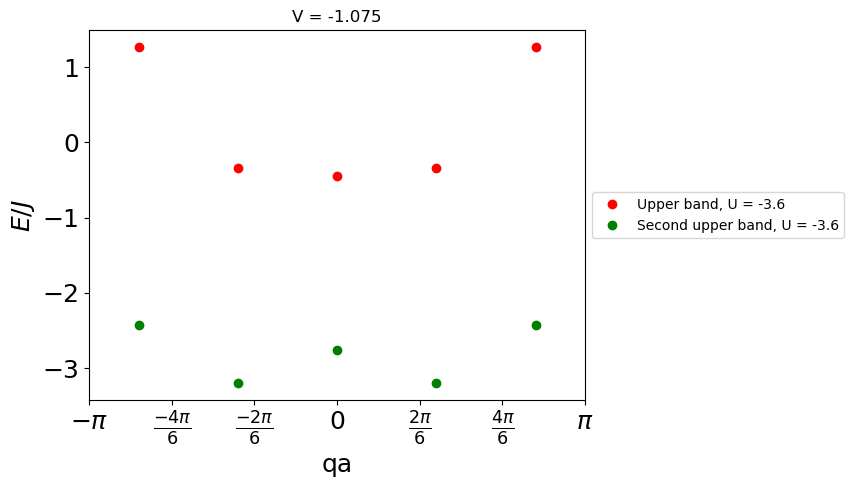

'\n#U,V,q,lower/upper band\nprint("E(q = 2pi/6, U = -0.3, V = 0) = ",plot_bands[0,0,4,1])\nprint("E(q = 0, U = -0.3, V = 0) = ",plot_bands[0,0,3,1])\nprint("difference: ",plot_bands[0,0,4,1]-plot_bands[0,0,3,1])\n\nprint("E(q = 2pi/6, U = -0.3, V = -1) = ",plot_bands[0,2,4,1])\nprint("E(q = 0, U = -0.3, V = -1) = ",plot_bands[0,2,3,1])\nprint("difference: ",plot_bands[0,2,4,1]-plot_bands[0,2,3,1])'

In [64]:
if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns  
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns


X = np.linspace(-np.pi,np.pi,200)

X1 = np.linspace(-np.pi,0,100)
X2 = np.linspace(0,np.pi,200)
    
colors = ["red", "red","green","green", "blue", "blue"]

colors = ["red", "green", "blue", "orange"]
for k in range(len(Vs)):
    for i in range(len(Us)):
        if Us[i] < 0:
            plt.plot(K1,plot_bands[i,k,:,1], "o", color = colors[0], label = r"Upper band, U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,3], "o", color = colors[1], label = r"Second upper band, U = "+str(Us[i]))
            
            #plt.plot(X, effective_dispersion_relation(X,Us[i],6), color = colors[i-1]) 
        elif Us[i] > 0:
            plt.plot(K1,plot_bands[i,k,:,0], "s", color = colors[2], label = r"Lower band, U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,2], "s", color = colors[3], label = r"Second lower band, U = "+str(Us[i]))
            #plt.plot(X, effective_dispersion_relation(X,Us[i],6), color = colors[i])

        elif Us[i] == 0:
            plt.plot(K1,plot_bands[i,k,:,0], "^", color = "orange")#, label = r"U = "+str(Us[i]))
            plt.plot(K1,plot_bands[i,k,:,1], "^", color = "orange", label = r"U = "+str(Us[i]))

            #plt.plot(X1, -3/np.pi*X1 + 7, ls = "--", color = "orange")
            #plt.plot(X2, 3/np.pi*X2 + 7, ls = "--", color = "orange")
            #plt.plot(X1, -3/np.pi*X1 -10, ls = "--", color = "orange")
            #plt.plot(X2, 3/np.pi*X2 -10, ls = "--", color = "orange")



        cosa = np.array([-np.pi,-4*np.pi/6, -2*np.pi/6,0,2*np.pi/6,4*np.pi/6, np.pi]) 

        plt.legend()
        plt.xlabel("qa", fontsize = 18)
        plt.ylabel(r"$E/J$", fontsize = 18)
        plt.xticks(cosa, [r"$-\pi$", r"$\frac{-4\pi}{6}$", r"$\frac{-2\pi}{6}$", "0", r"$\frac{2\pi}{6}$", r"$\frac{4\pi}{6}$", r"$\pi$"],fontsize = 18)
        #plt.xticks(cosa, [r"$-\pi$", r"$-4\pi/6$", r"$-2\pi/6$", "0", r"$\frac{2\pi}{6}$", r"$\frac{4\pi}{6}$", r"$\pi$"],fontsize = 18)
        plt.yticks(fontsize = 18)
        
        #plt.legend(loc='center center', bbox_to_anchor=(0.5, 1), ncol = 4, fontsize = 11)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.ylim([2.5,7.5])
    plt.title(r"V = "+str(Vs[k]))
    plt.savefig('V'+str(Vs[k])+'.png',bbox_inches = "tight")
    plt.show()
'''
#U,V,q,lower/upper band
print("E(q = 2pi/6, U = -0.3, V = 0) = ",plot_bands[0,0,4,1])
print("E(q = 0, U = -0.3, V = 0) = ",plot_bands[0,0,3,1])
print("difference: ",plot_bands[0,0,4,1]-plot_bands[0,0,3,1])

print("E(q = 2pi/6, U = -0.3, V = -1) = ",plot_bands[0,2,4,1])
print("E(q = 0, U = -0.3, V = -1) = ",plot_bands[0,2,3,1])
print("difference: ",plot_bands[0,2,4,1]-plot_bands[0,2,3,1])'''

In [33]:
plot_effective_mass = np.zeros((len(NS),len(Us),len(Vs), 2))
plot_effective_mass_order5 = np.zeros((len(NS),len(Us),len(Vs), 2))
plot_first_derivative = np.zeros((len(NS),len(Us), 2))
plot_last_try = np.zeros((len(NS), len(Us)))


for j in range(len(NS)):
    dq = 2*np.pi/NS[j]
    for i in range(len(Us)):
        for ik in range(len(Vs)):
            #if (i < len(plot_bands)//2):
            if (Us[i] < 0):
                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,1]
                fx2 = plot_diff_NS[j][i,ik,NS[j]//2-2,1]
                fx1 = plot_diff_NS[j][i,ik,NS[j]//2-1,1]
                fx0 = plot_diff_NS[j][i,ik,NS[j]//2-0,1]


                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,0]
                #fx2 = plot_diff_NS[j][i,NS[j]//2-2,0]
                #fx1 = plot_diff_NS[j][i,NS[j]//2-1,0]
                #fx0 = plot_diff_NS[j][i,NS[j]//2,0]

                plot_effective_mass_order5[j,i,0] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,0] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,0] = (-3*fx0 + 4fx1 -fx2)/dq

                #plot_last_try[j,i] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)

                plot_effective_mass[j,i,ik,0] = 2*(plot_diff_NS[j][i,ik,NS[j]//2+1,1] - plot_diff_NS[j][i,ik,NS[j]//2,1])/(2*np.pi/NS[j])**2
                plot_effective_mass[j,i,ik,1] = 2*(plot_diff_NS[j][i,ik,1,1] - plot_diff_NS[j][i,ik,0,1])/(2*np.pi/NS[j])**2

                #fx3 = plot_diff_NS[j][i,3,1]
                fx2 = plot_diff_NS[j][i,ik,2,1]
                fx1 = plot_diff_NS[j][i,ik,1,1]
                fx0 = plot_diff_NS[j][i,ik,0,1]


                plot_effective_mass_order5[j,i,ik,1] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,1] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,1] = (-3*fx0 + 4fx1 -fx2)/dq
            else:
            
                #fx3 = plot_diff_NS[j][i,NS[j]//2-3,0]
                fx2 = plot_diff_NS[j][i,ik,NS[j]//2-2,0]
                fx1 = plot_diff_NS[j][i,ik,NS[j]//2-1,0]
                fx0 = plot_diff_NS[j][i,ik,NS[j]//2-0,0]



                plot_effective_mass_order5[j,i,ik,0] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,0] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #print((2*fx0 - 5*fx1 + 4*fx2 - fx3)) 
                #plot_last_try[j,i] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)


                #print(-fx3)
                #plot_first_derivative[j,i,0] = (-3*fx0 + 4fx1 -fx2)/dq

                plot_effective_mass[j,i,ik,0] = 2*(plot_diff_NS[j][i,ik,NS[j]//2+1,0] - plot_diff_NS[j][i,ik,NS[j]//2,0])/(2*np.pi/NS[j])**2
                plot_effective_mass[j,i,ik,1] = 2*(plot_diff_NS[j][i,ik,1,0] - plot_diff_NS[j][i,ik,0,0])/(2*np.pi/NS[j])**2

                #fx3 = plot_diff_NS[j][i,3,0]
                fx2 = plot_diff_NS[j][i,ik,2,0]
                fx1 = plot_diff_NS[j][i,ik,1,0]
                fx0 = plot_diff_NS[j][i,ik,0,0]


                plot_effective_mass_order5[j,i,ik,1] = (-fx2 + 16*fx1 -30*fx0 + 16*fx1 - fx2)/(12*dq**2)
                #plot_effective_mass_order5[j,i,1] = (2*fx0 - 5*fx1 + 4*fx2 - fx3)/(dq**2)
                #plot_first_derivative[j,i,1] = (-3*fx0 + 4fx1 -fx2)/dq


    #print(plot_effective_mass_order5[0,:,0])
    #print(dq)

In [34]:
def fitting_second_derivative(ns,a,b):
    return a + b/(ns**2)

def fit(fd,Ns):
    g = [1,1]
    
    values, var = curve_fit(fitting_second_derivative,Ns,fd, g)
    
    a = values[0]
    b = values[1]
    
    return a, b
    
    

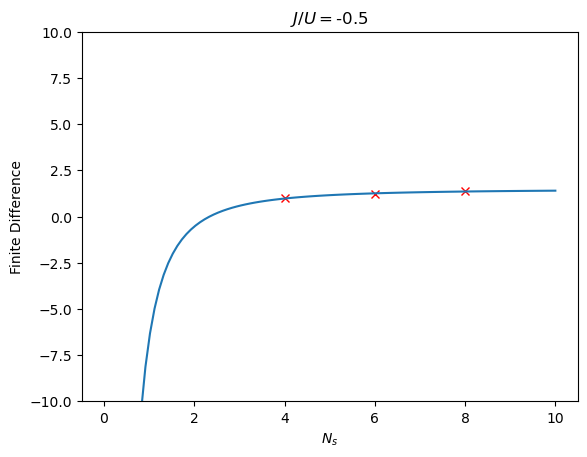

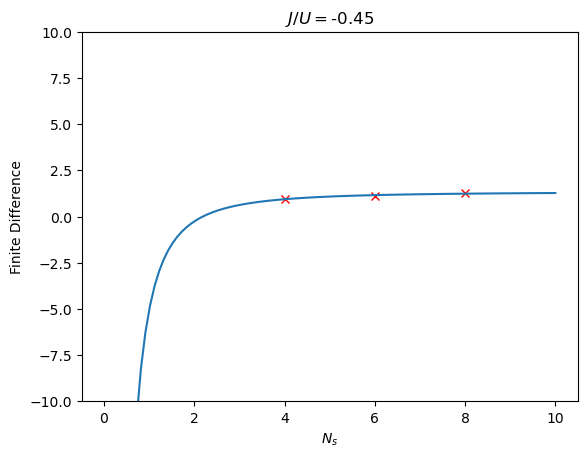

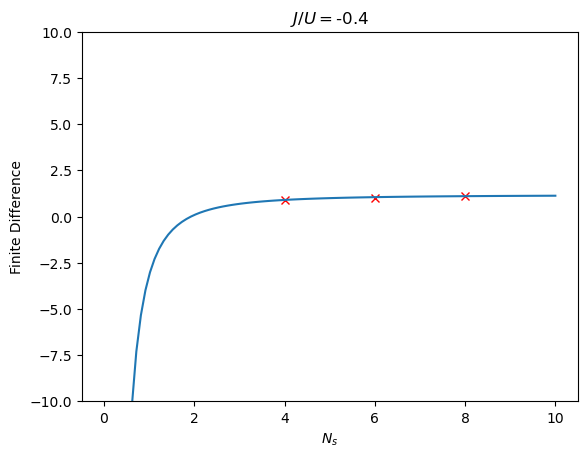

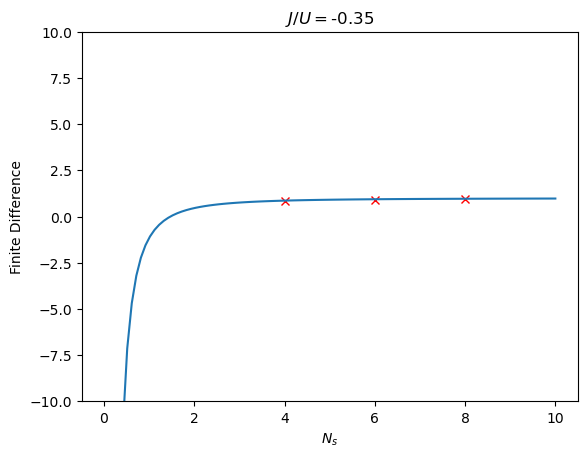

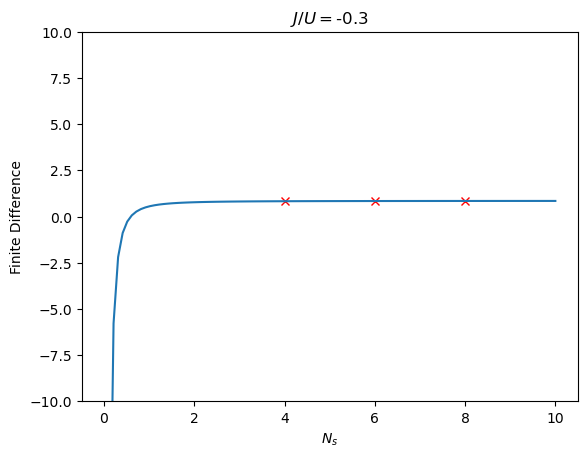

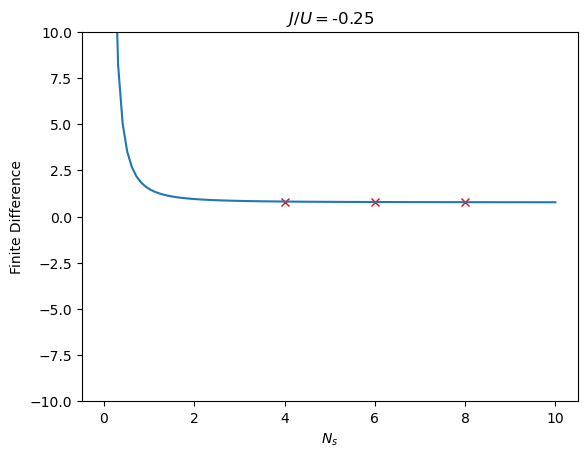

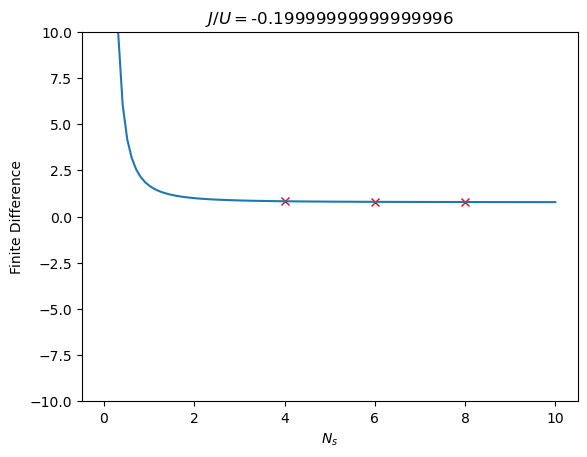

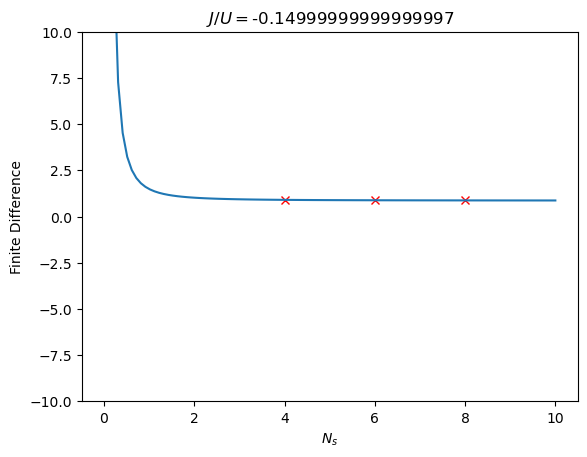

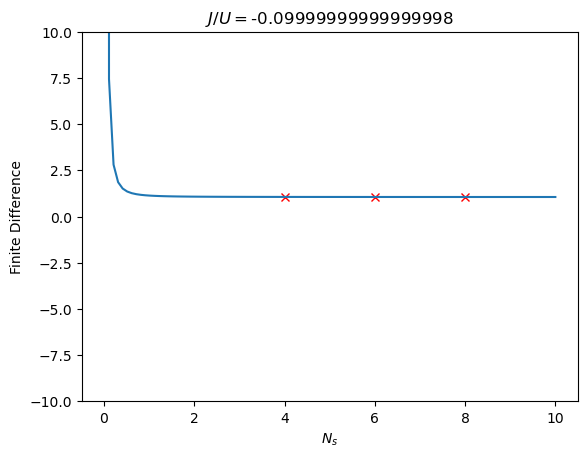

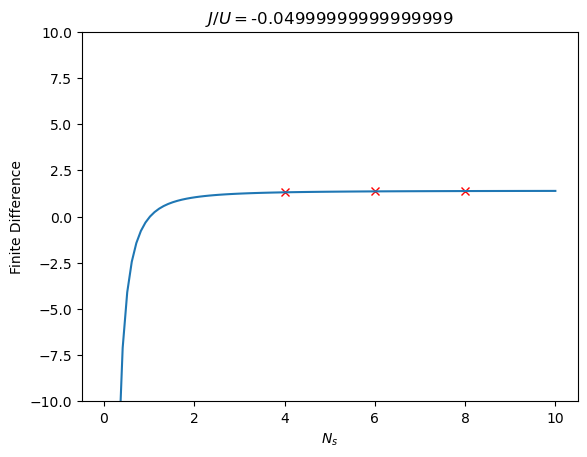

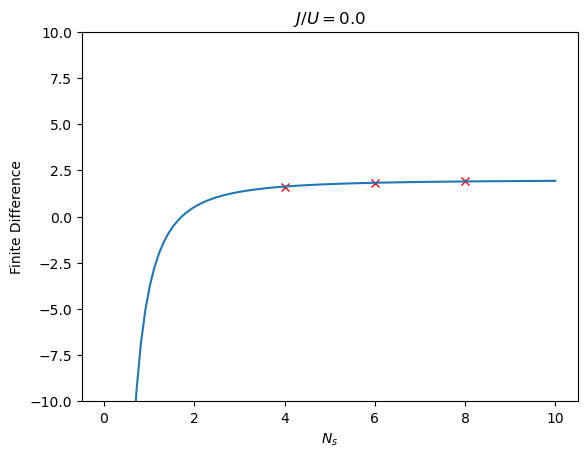

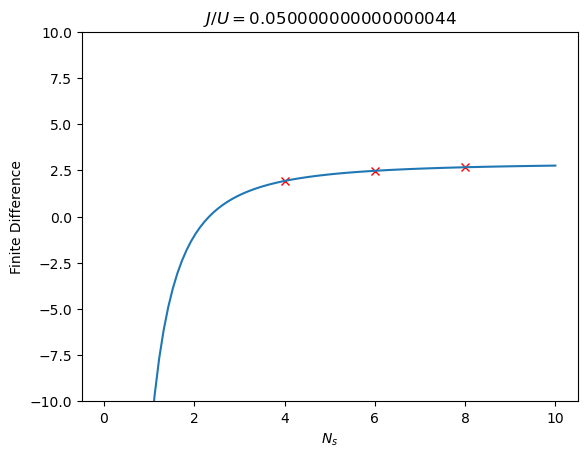

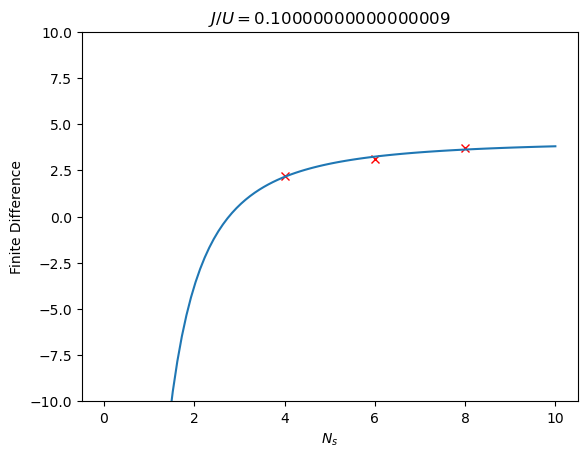

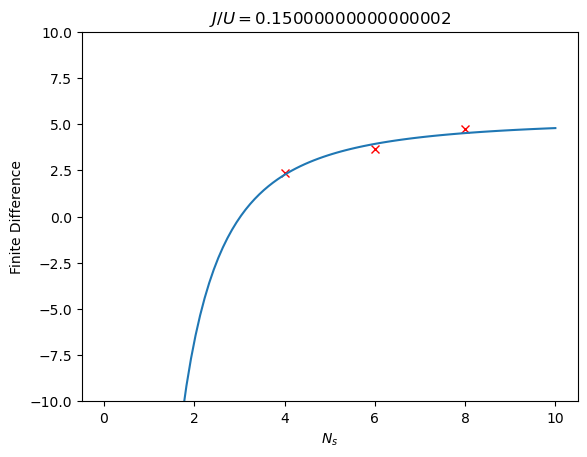

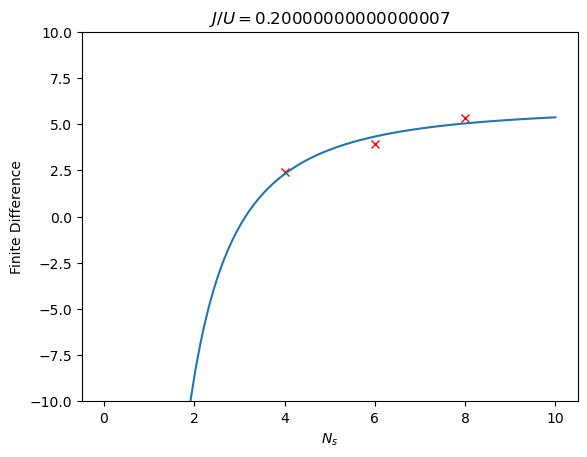

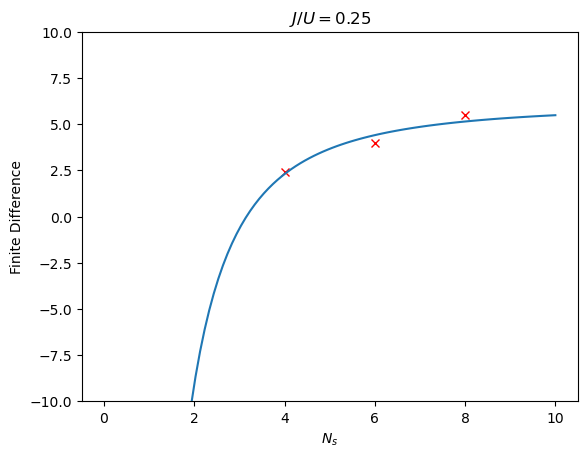

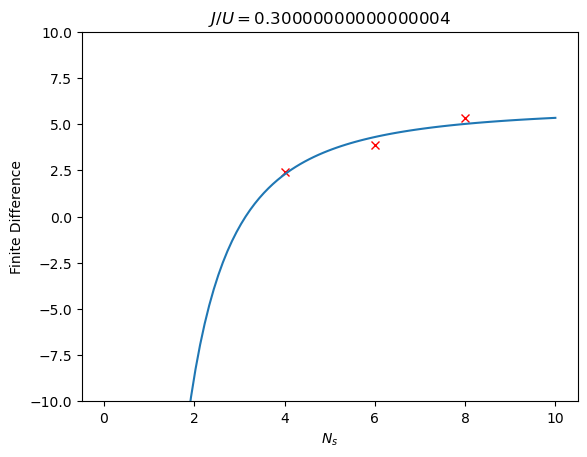

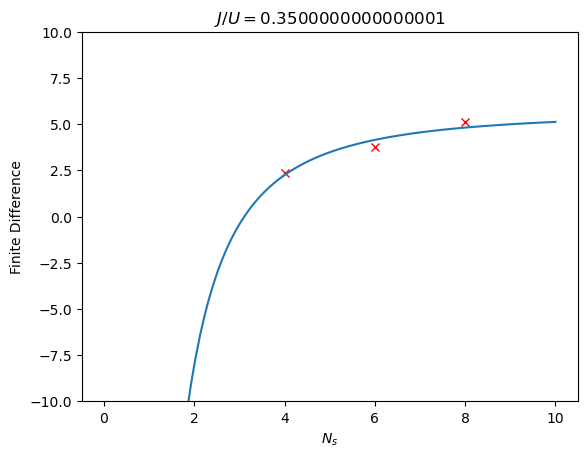

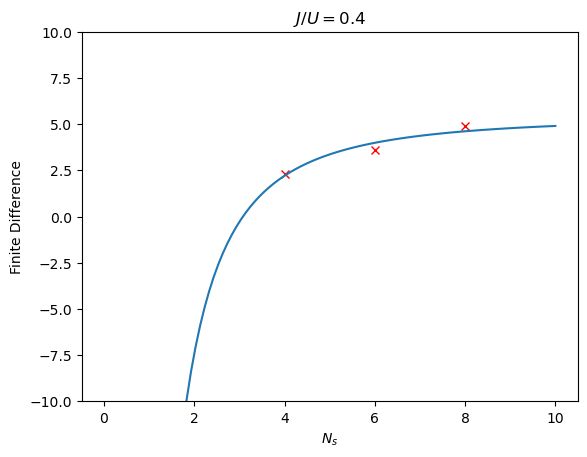

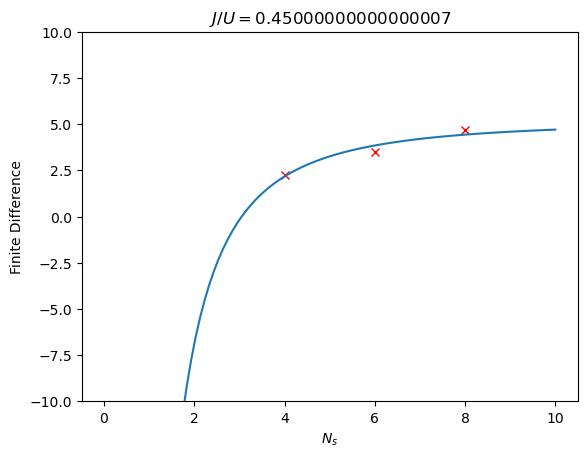

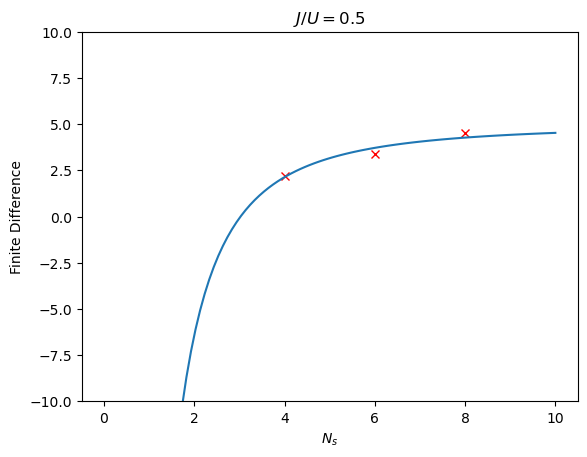

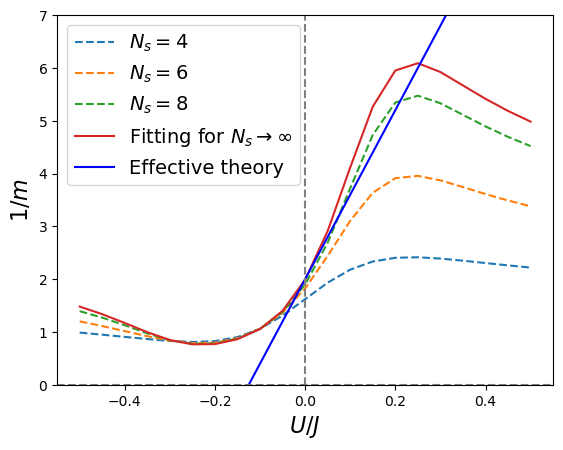

[1.40067282]
[1.99025569]
[2.91358293]
-0.04999999999999999


In [49]:


    
    
FD = np.array([plot_effective_mass[j,:,0,0]])    
    
second_derivative = np.zeros((len(ratios),len(Vs)))


for i in range(len(ratios)):
    for j in range(len(Vs)):
        fd = np.array([plot_effective_mass[0,i,j,0],plot_effective_mass[1,i,j,0],plot_effective_mass[2,i,j,0]])
        a , b = fit(fd,NS)
        
        plt.plot(NS,fd, "rx")
        plt.plot(np.linspace(0.01,10,100), fitting_second_derivative(np.linspace(0.01,10,100),a,b))
        plt.xlabel(r"$N_s$")
        plt.ylabel("Finite Difference")
        plt.title(r"$J/U = $"+str(ratios[i]))
        plt.ylim([-10,10])
        plt.show( )
        
        second_derivative[i,j] = a
        
        
for j in range(len(NS)):
    plt.plot(ratios,plot_effective_mass[j,:,0,0], label = r"$N_s = $"+str(NS[j]), ls = "--")    
plt.plot(ratios, second_derivative[:,0], label = r"Fitting for $N_s \rightarrow \infty$", ls = "-")
plt.plot(ratios,linear_mass_q0(ratios), color = "blue", ls = "-", label = "Effective theory")

plt.xlabel(r"$U/J$", fontsize = 16)
plt.ylabel(r"$1/m$", fontsize = 16)
plt.legend(fontsize = 14)
plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.ylim([0,7])
#plt.xlim([-0.05,0.05])
plt.show()
    
    
print(second_derivative[len(second_derivative)//2-1])
print(second_derivative[len(second_derivative)//2])
print(second_derivative[len(second_derivative)//2+1])
print(ratios[len(second_derivative)//2-1])

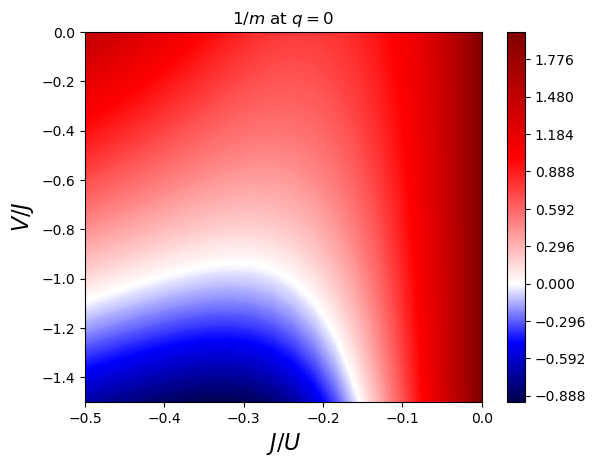

In [15]:
from matplotlib.colors import TwoSlopeNorm

plt.contourf(ratios,Vs,second_derivative.T,levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
#plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()

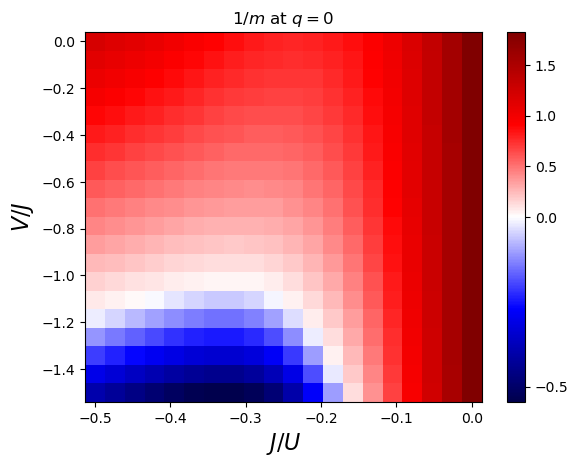

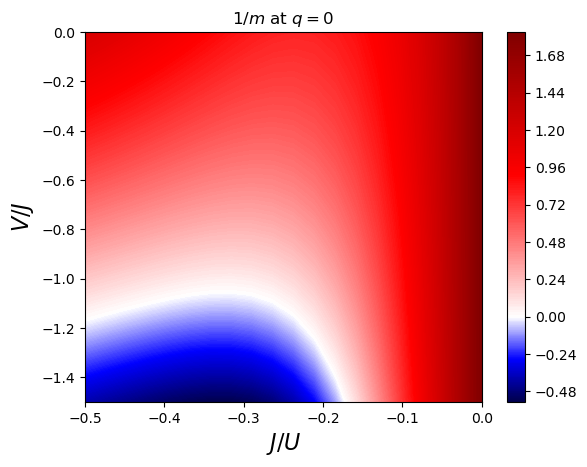

48.88184025453444
[5 5 5 6 6 6 6 6 6 6 5 4 2 0 0 0 0 0 0 0]


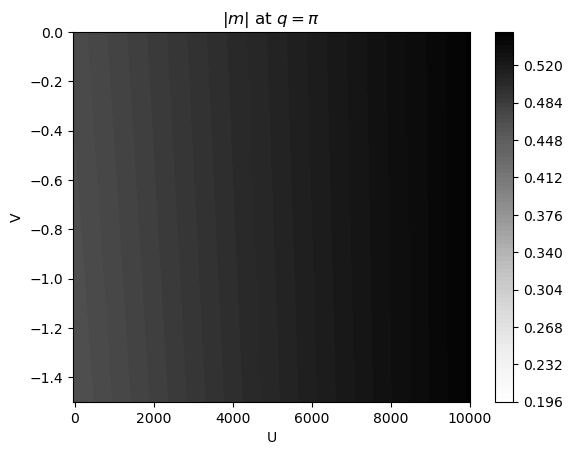

In [13]:
from matplotlib.colors import TwoSlopeNorm

#plt.contourf(ratios,Vs,(plot_effective_mass[0,:,:,0].T),levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()


plt.contourf(ratios,Vs,(plot_effective_mass[0,:,:,0].T),levels = 400, cmap = "seismic",norm=TwoSlopeNorm(0))
#plt.pcolormesh(ratios,Vs,(plot_effective_mass[0,:,:,0].T), cmap = "seismic",norm=TwoSlopeNorm(0))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.ylabel(r"$V/J$", fontsize = 16)
plt.colorbar()
plt.title(r"$1/m$ at $q = 0$")
#plt.xlim([-4,-1])
#plt.ylim([-1.5,-1])
plt.show()

#print(1/plot_effective_mass[0,20,20,0].T)
#print(Vs[20])
#print(Us[20])

print(np.max(1/plot_effective_mass[0,:,:,0].T))
print(np.argmax(1/plot_effective_mass[0,:,:,0].T, axis = 0))

plt.contourf(Us,Vs,1/np.abs(plot_effective_mass[0,:,:,1].T),levels = 100, cmap = "Greys")
plt.xlabel("U")
plt.ylabel("V")
plt.colorbar()
plt.title(r"$|m|$ at $q = \pi$")
plt.show()

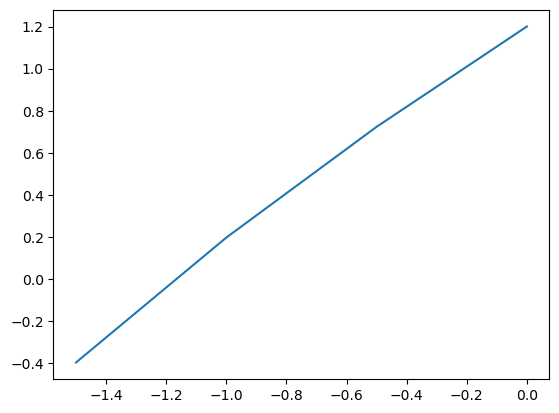

In [34]:
plt.plot(Vs,plot_effective_mass[0,0,:,0])

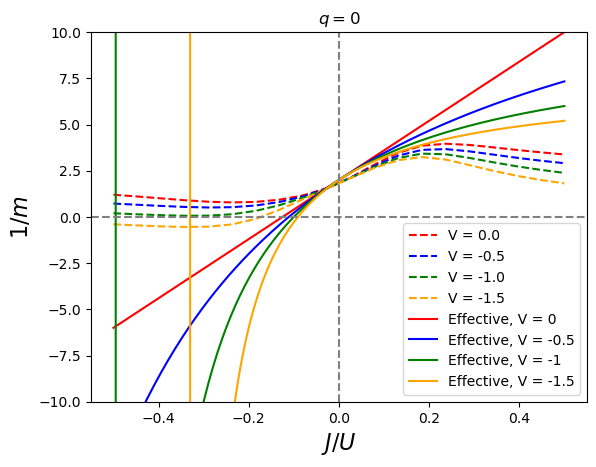

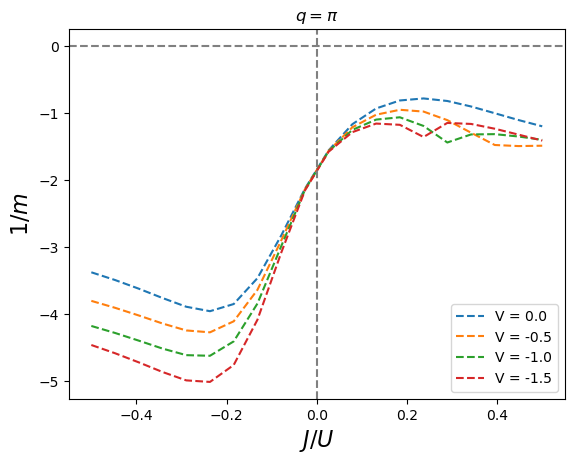

IndexError: index 25 is out of bounds for axis 0 with size 20

In [52]:
#plot_effective_mass[j,i,ik,0]

colors = ["red", "blue", "green", "orange"]
#plt.contourf(Us,Vs,plot_effective_mass[0,:,:,0].T,levels = 100, cmap = "Greys")
for i in range(len(Vs)):
        plt.plot(1/Us, plot_effective_mass[0,:,i,0], color = colors[i],ls = "--", label = "V = "+str(Vs[i]))
        
        
X = np.linspace(-0.5,0.5,200)
Us2 = 1/X

plt.plot(1/Us2,2+16/(Us2), "-", label = "Effective, V = 0", color = "red")
plt.plot(1/Us2,2+16/(Us2+1), "-", label = "Effective, V = -0.5", color = "blue")
plt.plot(1/Us2,2+16/(Us2+2+0.000001), "-", label = "Effective, V = -1", color = "green")

plt.plot(1/Us2,2+16/(Us2+3),label = "Effective, V = -1.5", color = "orange")
plt.xlabel(r"$J/U$", fontsize = 16)
#plt.ylabel(r"$V$", fontsize = 16)
#plt.xlim([0,4])
#plt.colorbar()
#plt.ylim([-1,4.5])
plt.ylim([-10,10])

plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.legend()
plt.ylabel(r"$1/m$", fontsize = 16)
plt.title(r"$q = 0$")
plt.show()

#plt.contourf(Us,Vs,plot_effective_mass[0,:,:,0].T,levels = 100, cmap = "Greys")
for i in range(len(Vs)):
    if (i <4):
        plt.plot(1/Us, plot_effective_mass[0,:,i,1], "--", label = "V = "+str(Vs[i]))
    else:
        plt.plot(1/Us, plot_effective_mass[0,:,i,1], "-", label = "V = "+str(Vs[i]))
plt.xlabel(r"$J/U$", fontsize = 16)
plt.axhline(y=0, color = "Gray", ls = "--")
plt.axvline(x=0, color = "Gray", ls = "--")
plt.ylabel(r"$1/m$", fontsize = 16)
#plt.ylabel(r"$V$", fontsize = 16)
#plt.xlim([0,4])
#plt.colorbar()
plt.legend()
plt.title(r"$q = \pi$")
plt.show()

print(Us[25])

The mass is:  3.098820159335037


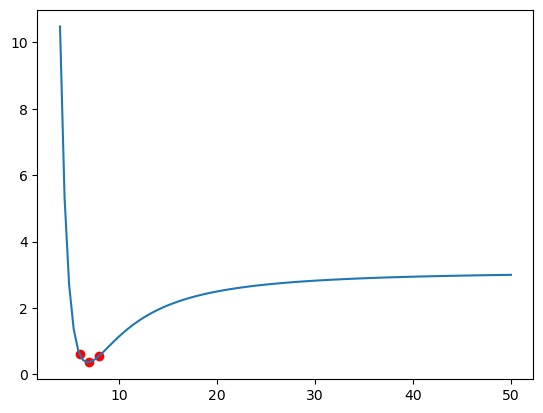

The mass is:  3.5009521951449303


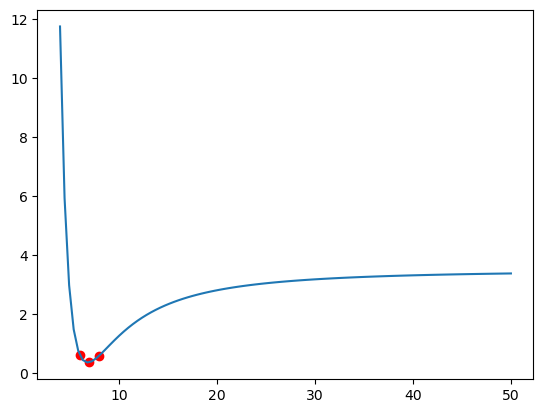

The mass is:  3.912675989633325


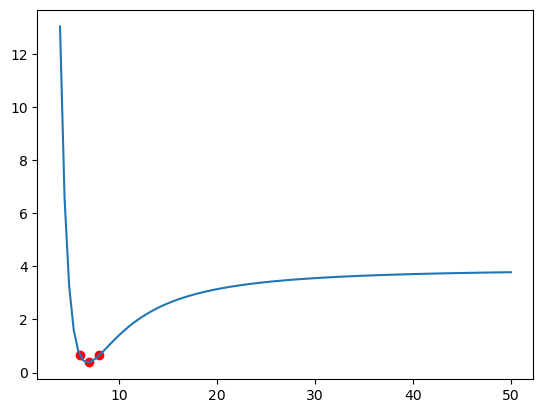

The mass is:  4.309013620341915


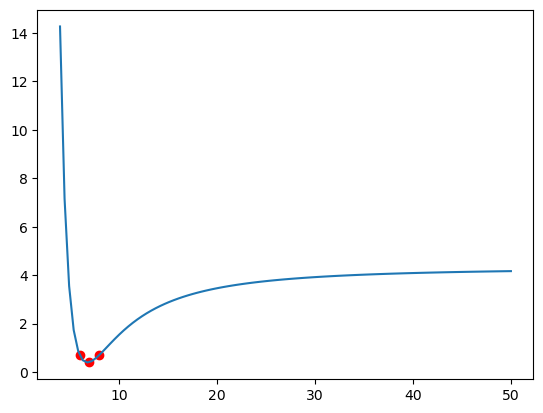

The mass is:  4.650481313975984


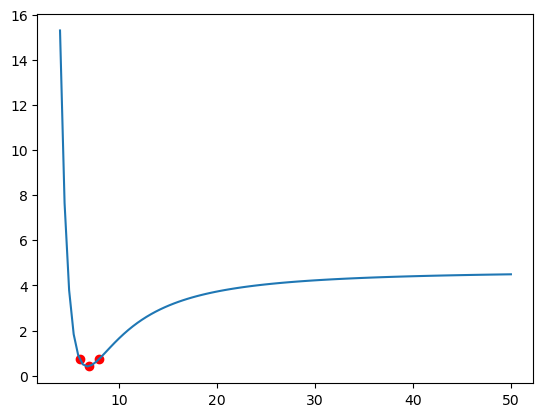

The mass is:  4.880856280198413


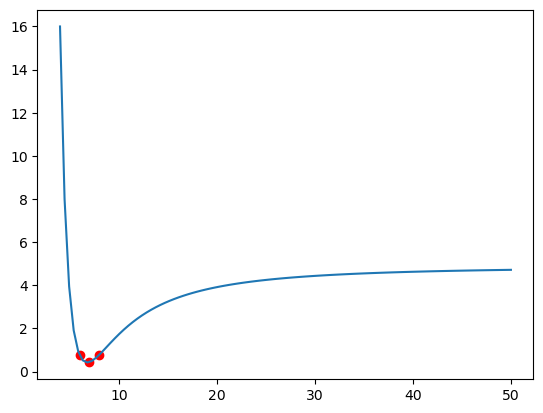

The mass is:  4.931968831164555


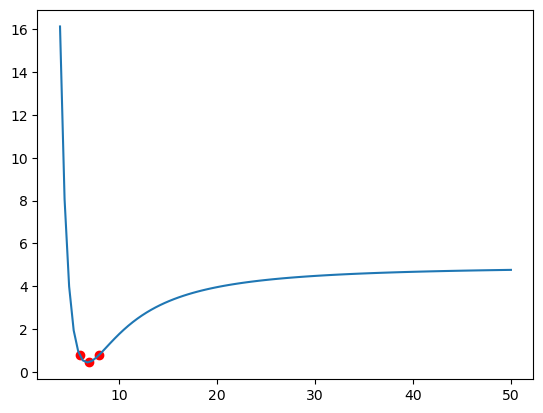

The mass is:  4.744084982534414


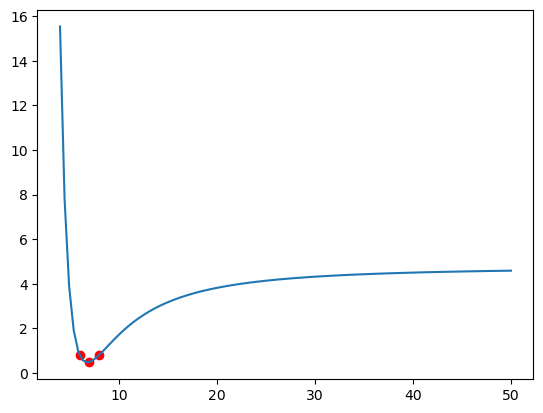

The mass is:  4.306104617582959


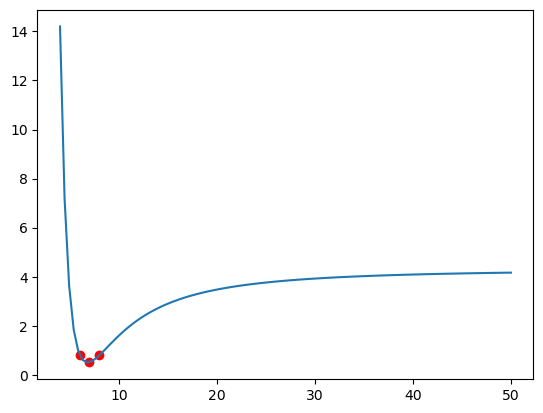

The mass is:  3.6971478562852953


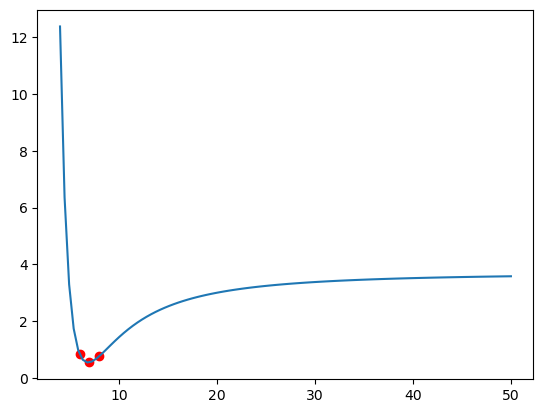

The mass is:  3.0815403449828414


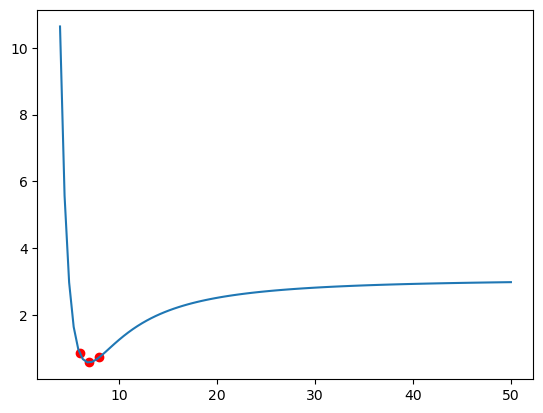

The mass is:  2.6266827242078974


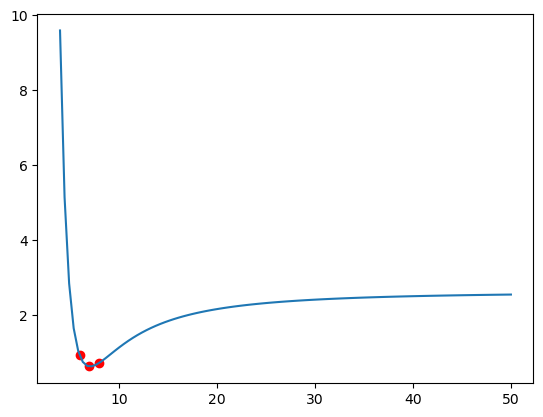

The mass is:  2.397834397337577


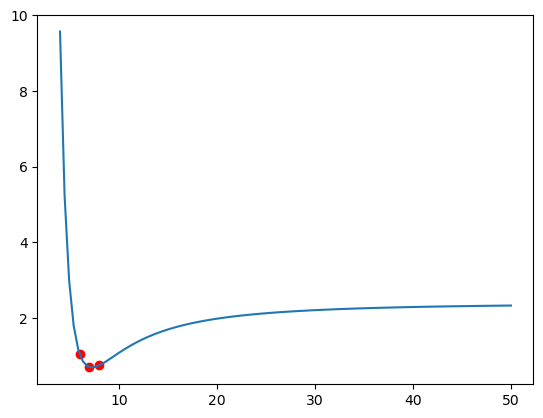

The mass is:  2.3195242257063406


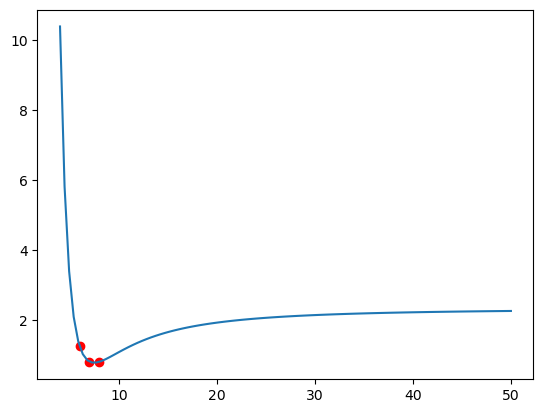

The mass is:  2.222070955367903


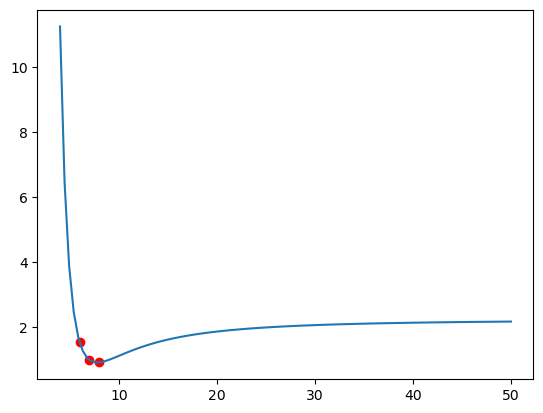

The mass is:  1.959377583553228


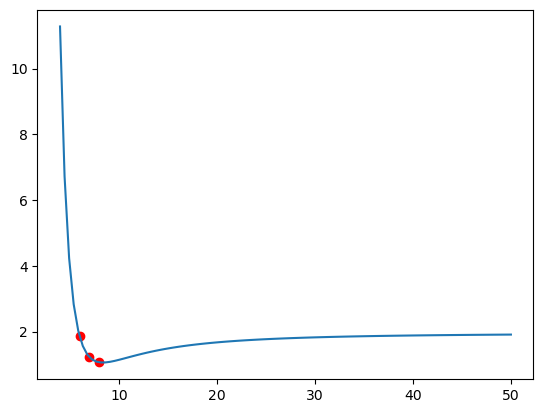

The mass is:  1.5471045938923262


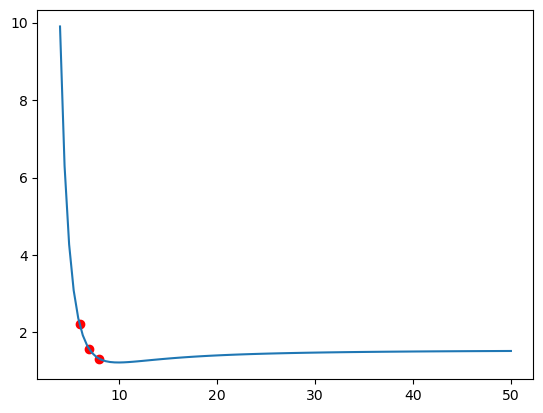

The mass is:  1.190778136675985


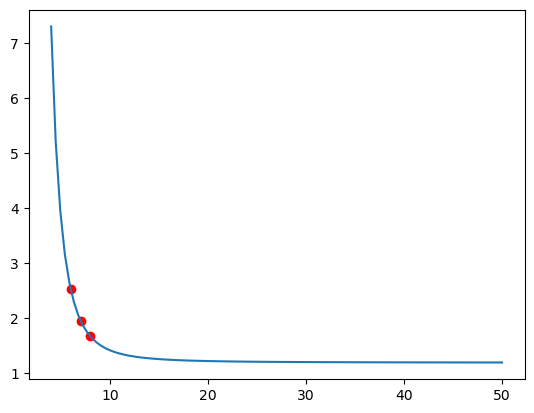

The mass is:  1.1694014127933885


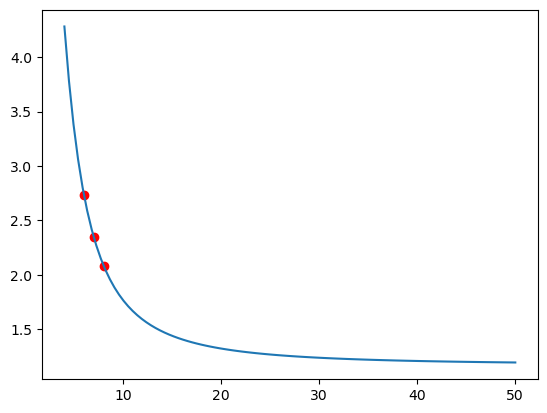

The mass is:  1.6688890385882489


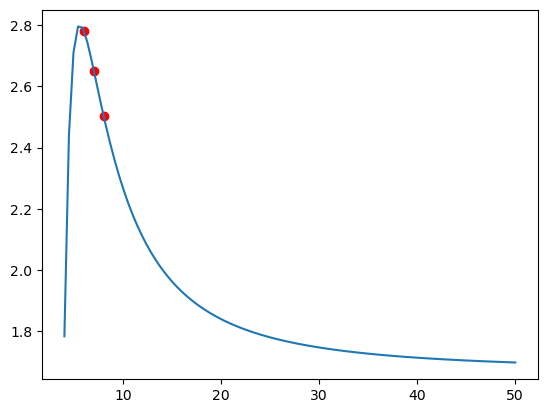

The mass is:  2.652635498831422


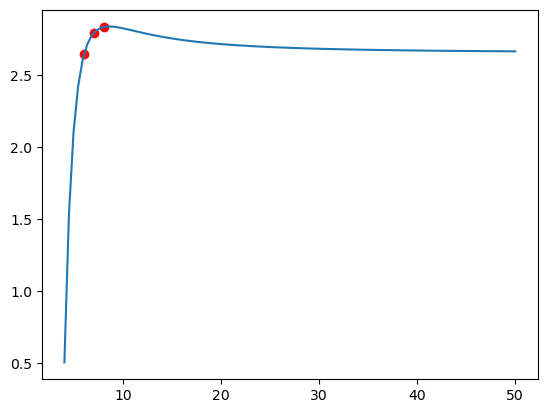

The mass is:  3.832796207802389


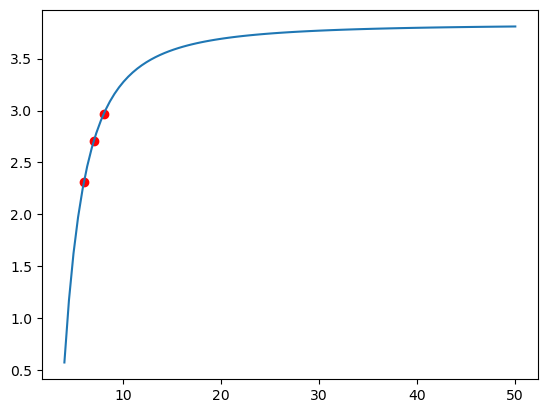

The mass is:  4.773577424855066


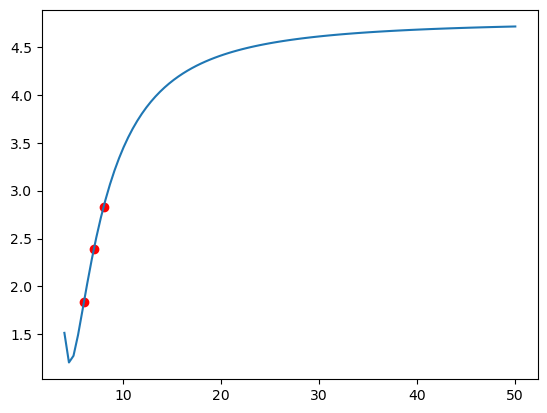

The mass is:  5.085562212768182


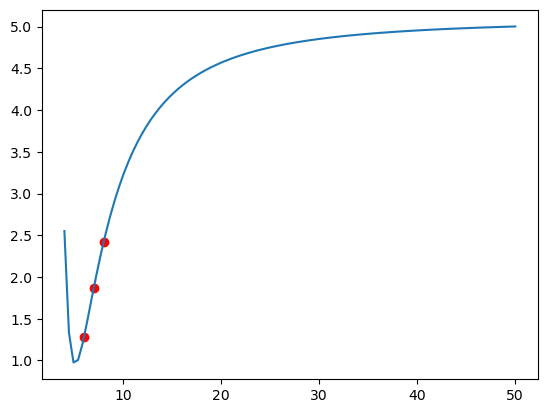

The mass is:  4.617113350802773


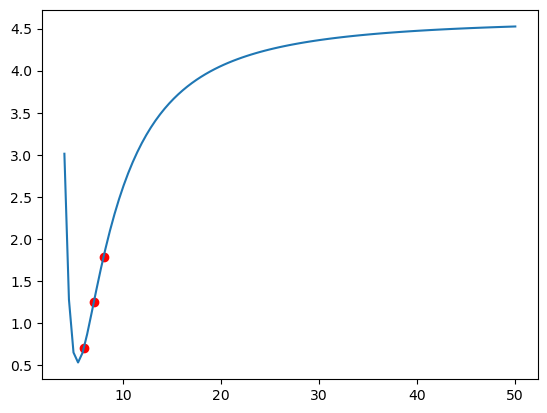

The mass is:  3.530163583219328


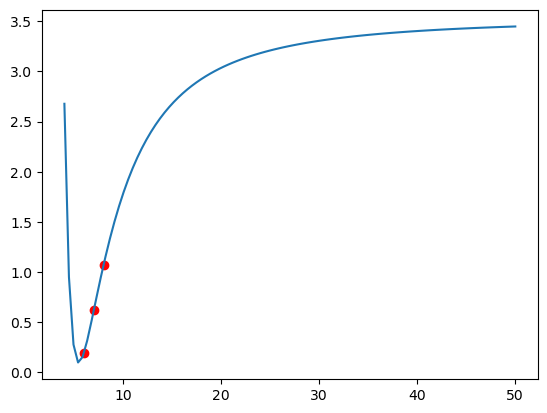

The mass is:  2.2005645737709063


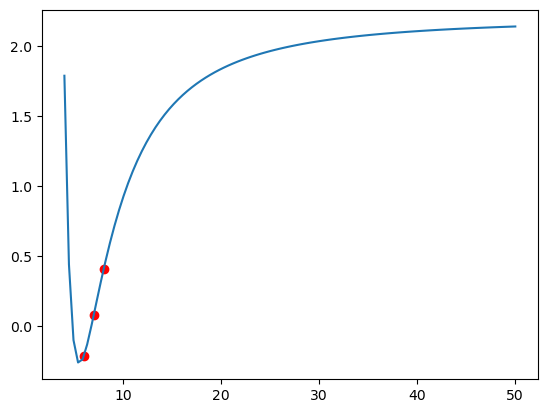

The mass is:  1.0126626354829569


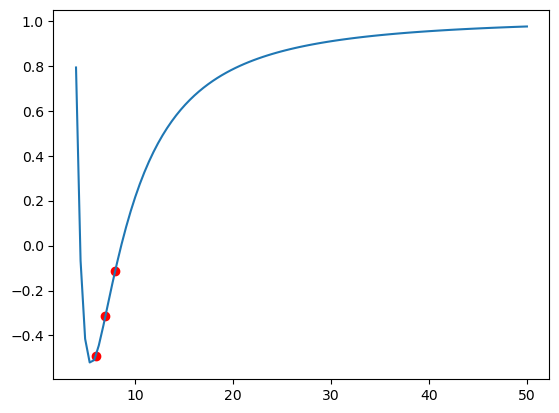

The mass is:  0.17640612951367415


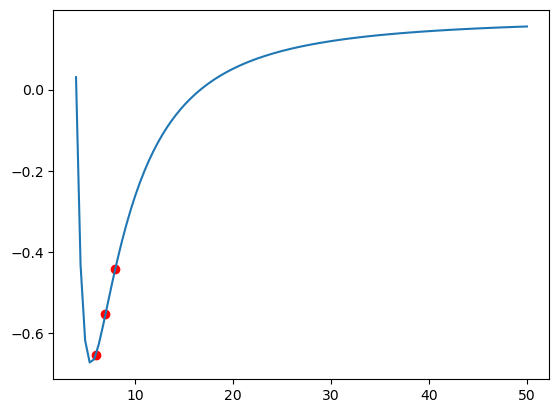

The mass is:  -0.3208877953625543


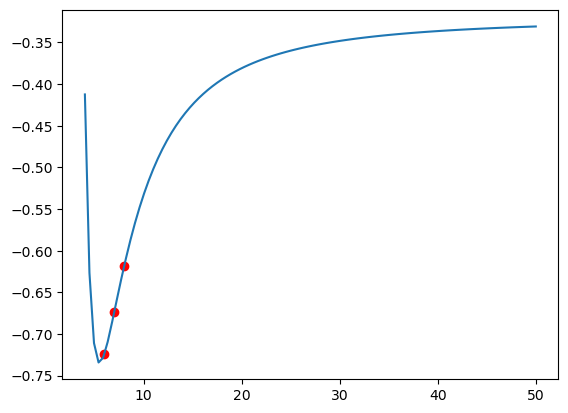

The mass is:  -0.5977910755747128


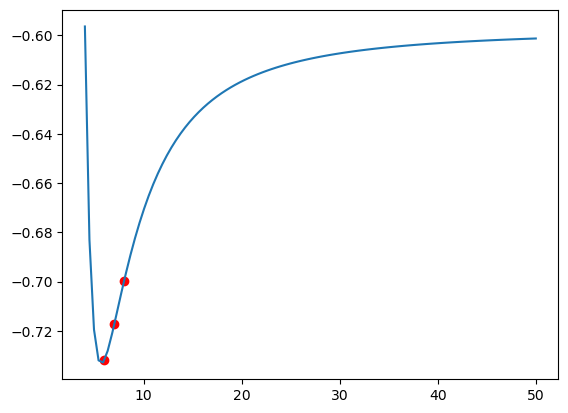

The mass is:  -0.7447181765445111


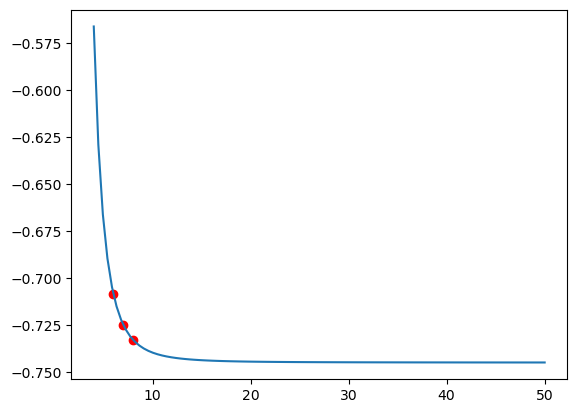

The mass is:  -0.8011086919068271


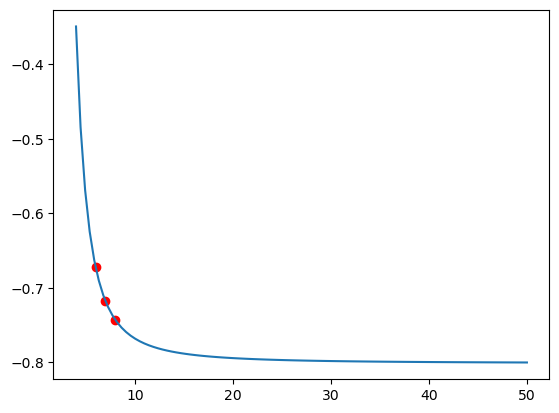

The mass is:  -0.7906031115616311


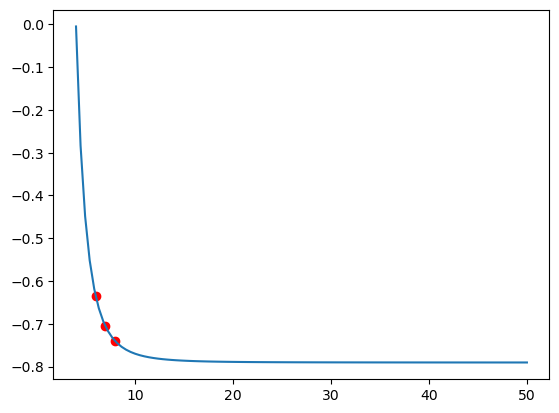

The mass is:  -0.7389969969894489


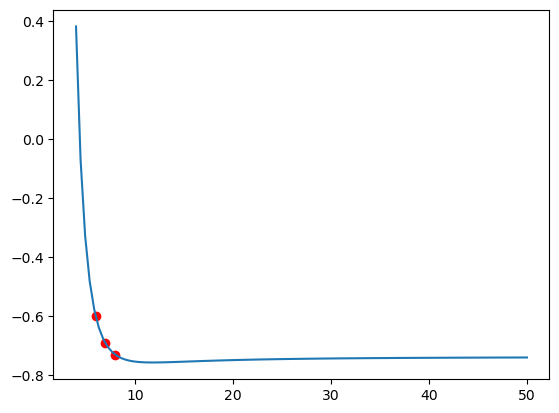

The mass is:  -0.6710191735686787


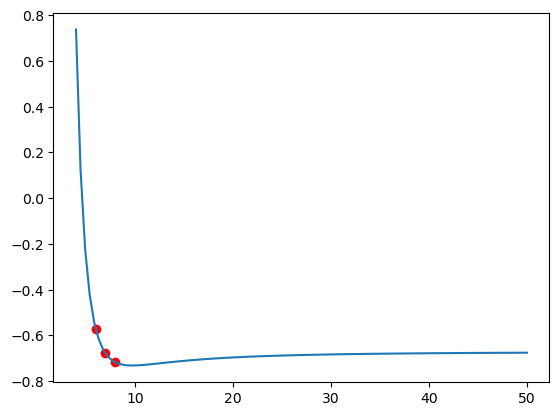

The mass is:  -0.6043846004300133


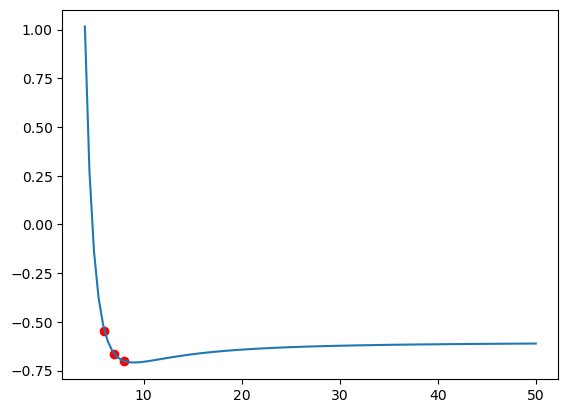

The mass is:  -0.5484473989562294


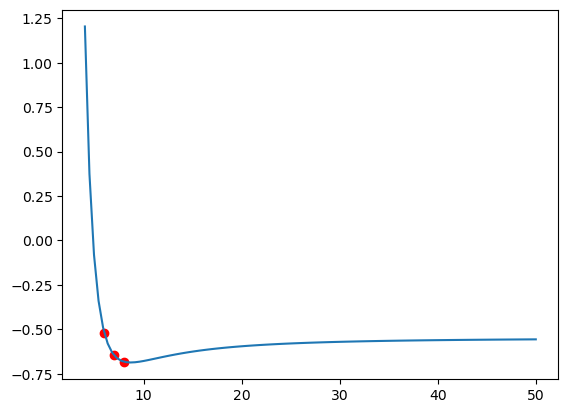

The mass is:  -0.5061781354834294


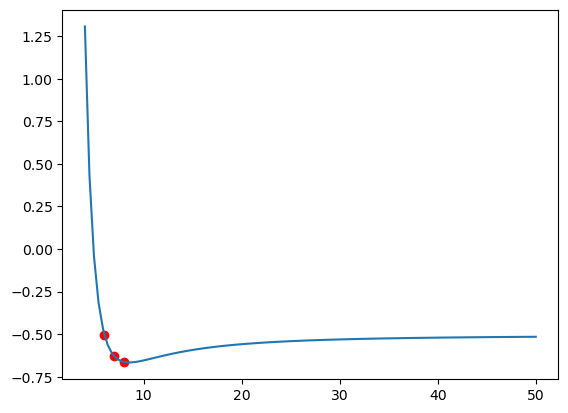

The mass is:  -0.4768811579306456


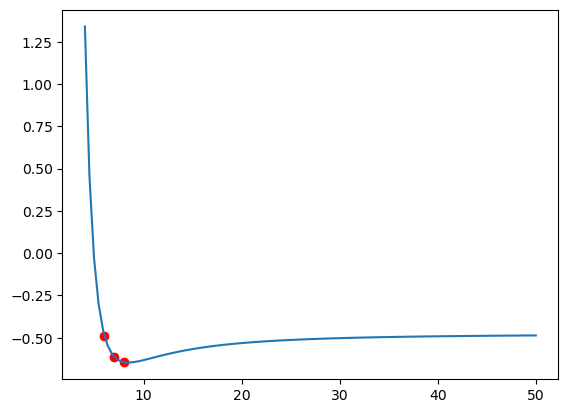

[ 3.09882016  3.5009522   3.91267599  4.30901362  4.65048131  4.88085628
  4.93196883  4.74408498  4.30610462  3.69714786  3.08154034  2.62668272
  2.3978344   2.31952423  2.22207096  1.95937758  1.54710459  1.19077814
  1.16940141  1.66888904  2.6526355   3.83279621  4.77357742  5.08556221
  4.61711335  3.53016358  2.20056457  1.01266264  0.17640613 -0.3208878
 -0.59779108 -0.74471818 -0.80110869 -0.79060311 -0.738997   -0.67101917
 -0.6043846  -0.5484474  -0.50617814 -0.47688116]


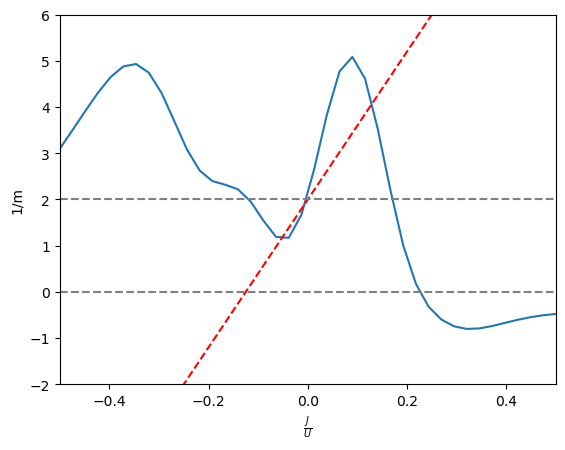

In [78]:
final_plot_masses = np.zeros((len(Us)))

for i in range(len(Us)):
    final_plot_masses[i] = inverse_mass_fitting_derivative(plot_last_try[:,i],NS)
    
    
print(final_plot_masses)
    
X = np.linspace(-20,20,100)    
plt.plot(1/Us,final_plot_masses,label = "mass with fitting")
plt.plot(X,linear_mass_q0(X), ls = "--", color = "red")
plt.axhline(y=0, ls = "--", color = "Gray")
plt.axhline(y=2, ls = "--", color = "Gray")
plt.xlabel(r"$\frac{J}{U}$")
plt.ylabel("1/m")
plt.xlim([-0.5,0.5])
plt.ylim([-2,6])
plt.show()

In [39]:
def fitting(Ns,a,b,c):
    return a + b/Ns**2 + c/Ns**4


def inverse_mass_fitting_derivative(vector_derivatives,vector_NS):
    g = [1,1,1]
    values, var = curve_fit(fitting,vector_NS,vector_derivatives, g,bounds=((-10,-np.inf,-np.inf), (10,np.inf,np.inf)))
    X = np.linspace(4,50,100)
    #print(values,np.sqrt(np.diag(var)))
    
    
    
    plt.plot(vector_NS,vector_derivatives, "ro")
    plt.plot(X,fitting(X,*(values)))
    
    
    
    print("The mass is: ", values[0])
    
    plt.show()
    return values[0]


#p = np.array([-0.3556970593107991,-0.2914549696554154,-0.23844610156367452])
#p2 = np.array([6,7,8])
#p = p*p2**2/(4*np.pi**2)
#def cosa(Ns,a,b,c):
#    return a/Ns**2 + b/Ns**4 + c/Ns**6



#values, var = curve_fit(cosa2, p2, p)


#X = np.linspace(4,50,100)
#print(values,np.sqrt(np.diag(var)))

#plt.plot(p2,p, "ro")
#plt.plot(X,cosa2(X,*(values)))



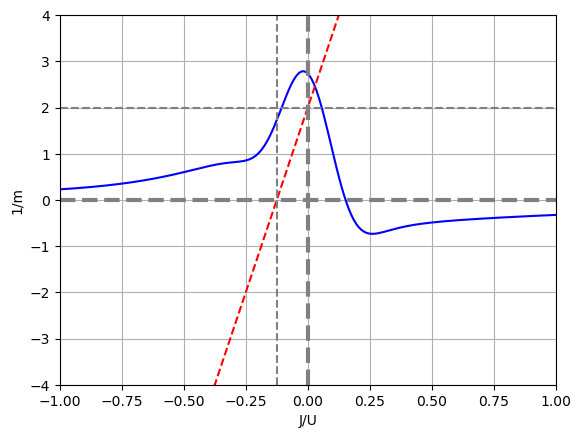

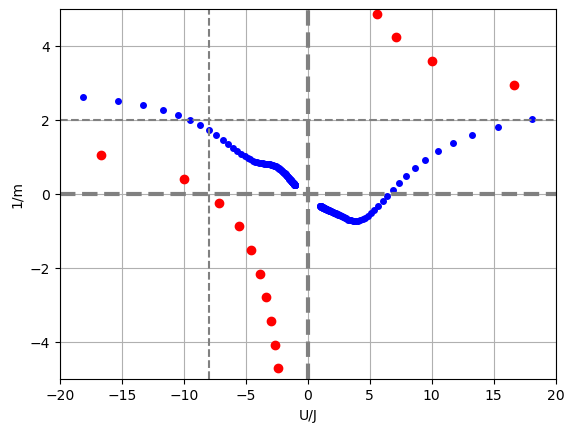

In [223]:
X = np.linspace(-100,100,5000)

for i in range(len(NS)):
    #i = 3
    plt.plot(ratios,plot_effective_mass_order5[i,:,0],ls = "-",markersize = 4,color = "blue", label = r"$N_s = $"+str(NS[i]))
    plt.plot(ratios,linear_mass_q0(ratios), ls = "--",color = "red", label = "H_eff")
    plt.axhline(y = 0, ls = "--", color = "Gray", lw = 3)
    plt.axhline(y = 2, ls = "--", color = "Gray")
    plt.axvline(x = 0, ls = "--", color = "Gray", lw = 3)
    plt.axvline(x = -1/8, ls = "--", color = "Gray")
    plt.xlabel("J/U")
    plt.ylabel("1/m")
    plt.xlim([-1,1])
    plt.ylim([-4,4])
    plt.grid("on")
    plt.show()
    
    plt.plot(Us,plot_effective_mass_order5[i,:,0],"o",markersize = 4,color = "blue", label = r"$N_s = $"+str(NS[i]))
    plt.plot(1/X,linear_mass_q0(X), "o" , color = "red", label = "H_eff")
    plt.axhline(y = 0, ls = "--", color = "Gray", lw = 3)
    plt.axhline(y = 2, ls = "--", color = "Gray")
    plt.axvline(x = 0, ls = "--", color = "Gray", lw = 3)
    plt.axvline(x = -8, ls = "--", color = "Gray")
    plt.xlabel("U/J")
    plt.ylabel("1/m")
    plt.xlim([-20,20])
    plt.ylim([-5,5])
    plt.grid("on")
    plt.show()
    

    

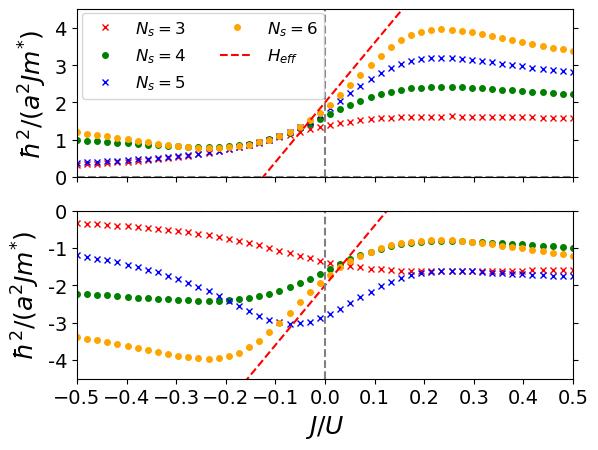

[ 0.95685309 -0.95685309]


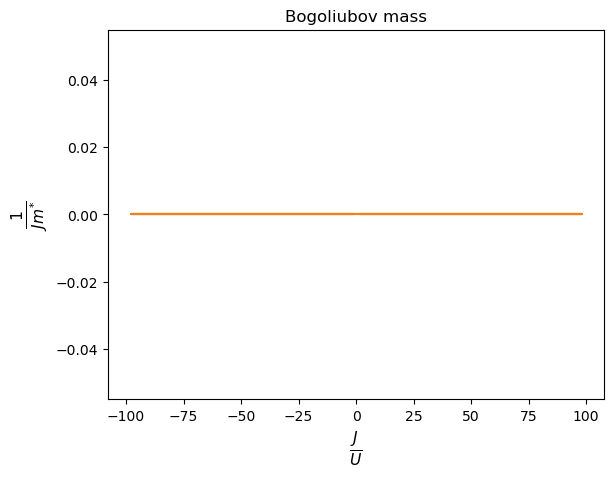

mass is inf
E2 is -4.4182180052109175


C:\Users\davri\AppData\Local\Temp\ipykernel_11272\1927589834.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  print("mass is",1/plot_eff_masses[0])


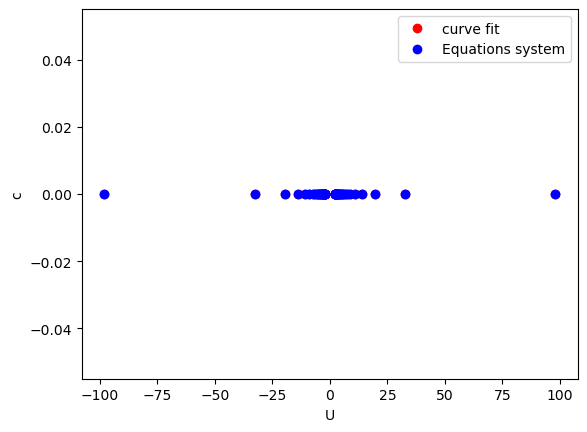

ValueError: x and y must have same first dimension, but have shapes (6,) and (3,)

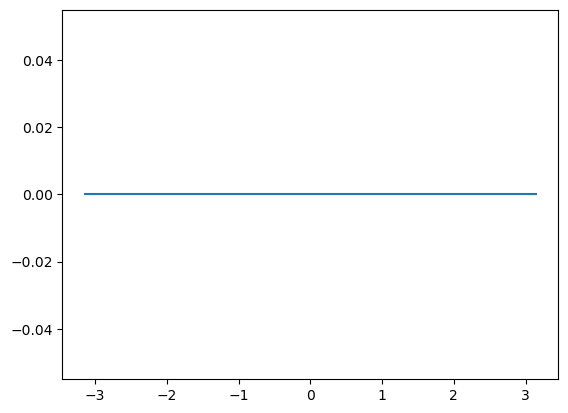

In [123]:
X = np.linspace(-1,1,600)


colors = ["red", "green", "blue", "orange"]

fig, axs = plt.subplots(2, sharex = True)
#fig, (ax1, ax2) = plt.subplots(2, sharex=True)


for i in range(len(NS)):
    #i = 3
    if (i%2 != 0):
        #axs[0].plot(ratios,plot_effective_mass_order5[i,:,0],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        #axs[0].plot(ratios[len(ratios)//2:],plot_effective_mass_order5[i,len(ratios)//2:,0],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        #axs[1].plot(ratios,plot_effective_mass_order5[i,:,1],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        
        
        axs[0].plot(ratios,plot_effective_mass[i,:,0],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
       
        axs[1].plot(ratios,plot_effective_mass[i,:,1],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        
        
    else:
        axs[0].plot(ratios,plot_effective_mass[i,:,0],"x",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        axs[1].plot(ratios,plot_effective_mass[i,:,1],"x",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        
        
        #axs[0].plot(ratios,plot_effective_mass_order5[i,:,0],"x",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        #axs[0].plot(ratios[len(ratios)//2:],plot_effective_mass_order5[i,len(ratios)//2:,0],"o",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
        #axs[1].plot(ratios,plot_effective_mass_order5[i,:,1],"x",markersize = 4,color = colors[i], label = r"$N_s = $"+str(NS[i]))
    
axs[0].plot(X,linear_mass_q0(X),ls = "--", color = "red",label = r"$H_{eff}$")
axs[1].plot(X,linear_mass_qpi(X), ls = "--", color = "red",label = r"$H_{eff}$")
    
    #if (NS[i]%2 == 0):
        #print(NS[i])
        #weird_values.append(plot_effective_mass[i,0] + (plot_effective_mass[i,-1] - plot_effective_mass[i,0])/2)
        #plt.axhline(y = plot_effective_mass[i,0] + (plot_effective_mass[i,-1] - plot_effective_mass[i,0])/2, ls = "--", color = colors[i])

plt.xlabel(r"$J/U$", fontsize = 18)
plt.xticks(np.arange(-0.5,0.6,0.1), fontsize = 14)
#plt.yticks(fontsize = 18)
axs[0].set_ylabel(r"$\hbar^2/(a^2J m^{*})$", fontsize = 18)
axs[1].set_ylabel(r"$\hbar^2/(a^2J m^{*})$", fontsize = 18)
axs[0].yaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')

#axs[0].yticks(fontsize = 16)
#axs[1].yticks(fontsize = 16)

#axs[1].ylabel(r"$\frac{1}{J m^{*}}$", fontsize = 16)
#plt.grid("on")
axs[0].axhline(y = 0, ls = "--", color = "Gray")
axs[1].axhline(y = 0, ls = "--", color = "Gray")
axs[0].axvline(x = 0, ls = "--", color = "Gray")
axs[1].axvline(x = 0, ls = "--", color = "Gray")
#ax1.xlim([-1,1])

axs[0].set_yticks(np.array([0,1,2,3,4]),["0","1","2","3","4"],fontsize = 14)
axs[1].set_yticks(np.array([-4,-3,-2,-1,0]),["-4","-3","-2","-1","0"],fontsize = 14)
plt.setp(axs[0], xlim = (-0.5,0.5), ylim = (0,4.5))
plt.setp(axs[1], xlim = (-0.5,0.5), ylim = (-4.5,0))


#plt.setp(axs[0], xlim = (-0.5,0.5), ylim = (0,5))
#plt.setp(axs[1], xlim = (-0.5,0.5), ylim = (-5,0))



#plt.setp(xlim = (-1,1))
#ax1.ylim([0,5])
#ax2.xlim([-1,1])
#ax2.ylim([0,5])

#plt.plot(X[:len(X)//2],linear_mass_qpi(X[:len(X)//2]), label = r"$H_{eff}, q = \pi$", color = "blue", ls = "--")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.12, 0.89), ncol = 2, fontsize = 12)


plt.show()


print(plot_effective_mass[0,0] + (plot_effective_mass[0,-1] - plot_effective_mass[0,0])/2)

plt.plot(Us, Inverse_masses[:,0], label = "Curve fit")
plt.plot(Us, Inverse_masses[:,1], label = "Equations system")
#plt.plot(X,linear_mass_q0(X), label = r"$H_{eff}, q = 0$", color = "red", ls = "--")
plt.title("Bogoliubov mass")
#plt.axhline(y = 1/2)
#plt.xlim([-2,2])
#plt.ylim([-2.5,2.5])
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
plt.ylabel(r"$\frac{1}{Jm^{*}}$", fontsize = 16)
plt.show() 


print("mass is",1/plot_eff_masses[0])

Q = np.linspace(-np.pi,np.pi,200)





if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-Ns//2, Ns//2,1)
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)

print("E2 is",E2)

plt.plot(Us, Sound_speeds[:,0],"ro", label = "curve fit")
plt.plot(Us, Sound_speeds[:,1], "bo" ,label = "Equations system")
plt.ylabel("c")
plt.xlabel("U")
plt.legend()
plt.show()



if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns  
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns





Q = np.linspace(-np.pi,np.pi,200)

for i in range(2):
    i = -i
    plt.plot(Q, bogoliubov_spectrum(Q, Sound_speeds[i,0], Inverse_masses[i,0], Shifts[i,0]), label =  "Curve fit")
    plt.plot(K1,plot_diff_NS[0][i][:,0], "ro", markersize = 10, label = "Simulation First band")
    plt.plot(K1,plot_diff_NS[0][i][:,1], "go", markersize = 10, label = "Simulation Second band")
    plt.plot(Q, bogoliubov_spectrum(Q, Sound_speeds[i,1], Inverse_masses[i,1], Shifts[i,1]), label = "Equations system")
    #plt.plot(Q,effective_dispersion_relation(Q,Us[0],Ns), label = "H_eff")
    plt.title("U = "+str(Us[i])+r",  $c_{fit} = $"+str(Sound_speeds[i,0])+ r", $c_{ES} = $"+str(Sound_speeds[i,1]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim([-11,-5])
    #plt.savefig('U'+str(Us[i])+'.png',bbox_inches = "tight")
    plt.show()

#print(plot_diff_NS[0][0][len(K1)//2-2,0] - plot_diff_NS[0][0][len(K1)//2,0])


#calculation_for_ns8 = plot_diff_NS.copy()
Us_eff = np.linspace(0.01,50,200)
for i in range(len(NS)):
    #print(plot_diff_NS[0][1][2,0])
    plt.plot(ratios, ((plot_diff_NS[i][:,NS[i]//2-2,0] + plot_diff_NS[i][:,NS[i]//2,0] - 2*plot_diff_NS[i][:,NS[i]//2-1,0])/(2*np.pi/NS[i])**2),"bo", label = r"Ns = "+str(NS[i]))
    #plt.plot(Us, (calculation_for_ns8[i][:,NS[i]//2-2,0] + calculation_for_ns8[i][:,NS[i]//2,0] - 2*calculation_for_ns8[i][:,NS[i]//2-1,0])/(2*np.pi/NS[i])**2, label = r"Ns = "+str(NS[i]))
    plt.plot(ratios, inverse_mass_q2pins(1,1/ratios,NS[i]),"ro", label = r"$H_{eff}, N_s = $"+str(NS[i]))
    
    #plt.plot(Us, plot_diff_NS[0][:,NS[0]//2,0],"-",color = "orange", label = "GS, Q = 0")

    #plt.plot(Us, plot_diff_NS[0][:,NS[0]//2-2,0]- plot_diff_NS[0][:,NS[0]//2,0], label = r"Gs, $Q = \frac{4\pi}{6}$")
    #plt.plot(Us, plot_diff_NS[0][:,NS[0]//2,2], label = "First excited")
    #plt.xlabel(r"$\frac{J}{U}$", fontsize = 15)
plt.xlabel("J/U", fontsize = 16)
#plt.ylabel(r"E''(q = 2pi/Ns)", fontsize = 16)
plt.ylabel("1/m")
plt.title(r"$Q = \frac{2\pi}{Ns}$", fontsize = 16)
plt.grid("on")
plt.xlim([-10,10])
plt.ylim([-2,2])
plt.legend()
plt.show()


print(plot_effective_mass_order5[0,0,0])

plt.plot(ratios,plot_effective_mass_order5[0,:,0],"bo")
plt.plot(X,linear_mass_q0(X), label = r"$H_{eff}, q = 0$", color = "red", ls = "--")
plt.plot()
#plt.xlim([-10,10])
plt.ylim([0,4])
plt.show()


[10.  9.  8.  7.  8.  9.]


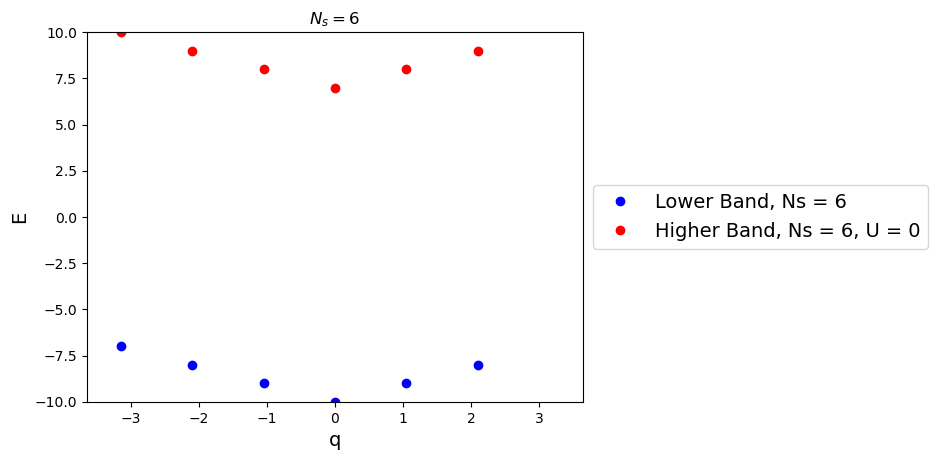

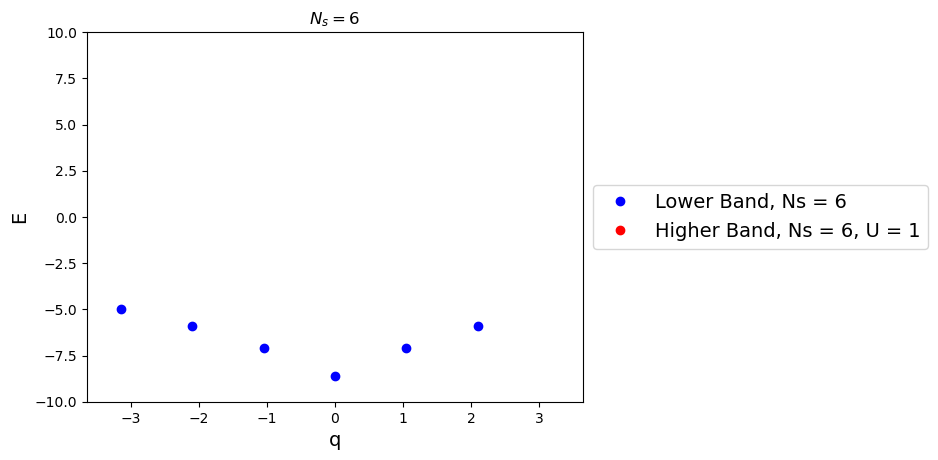

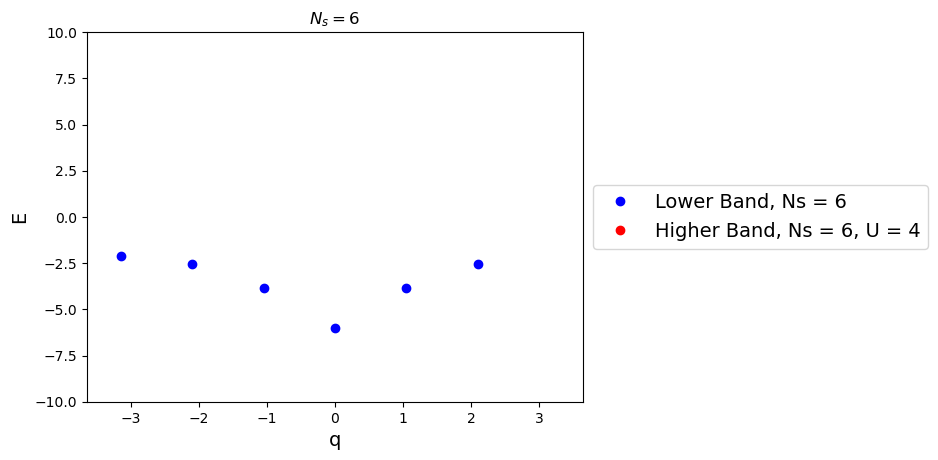

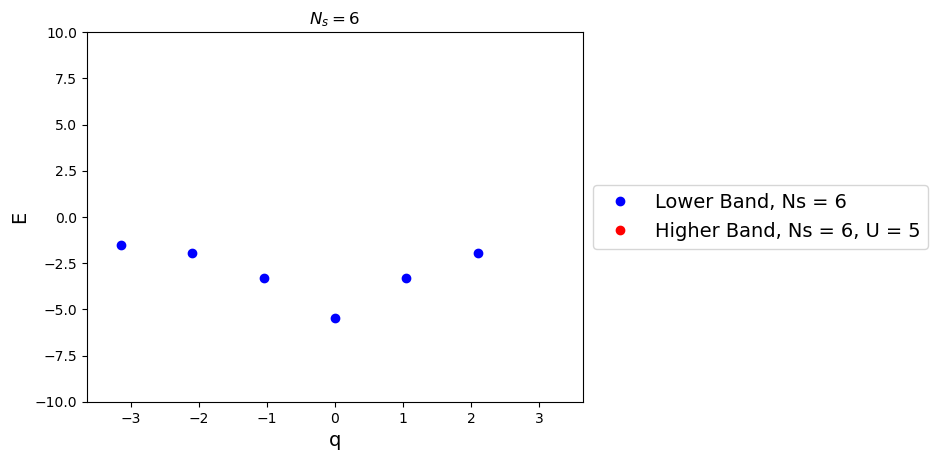

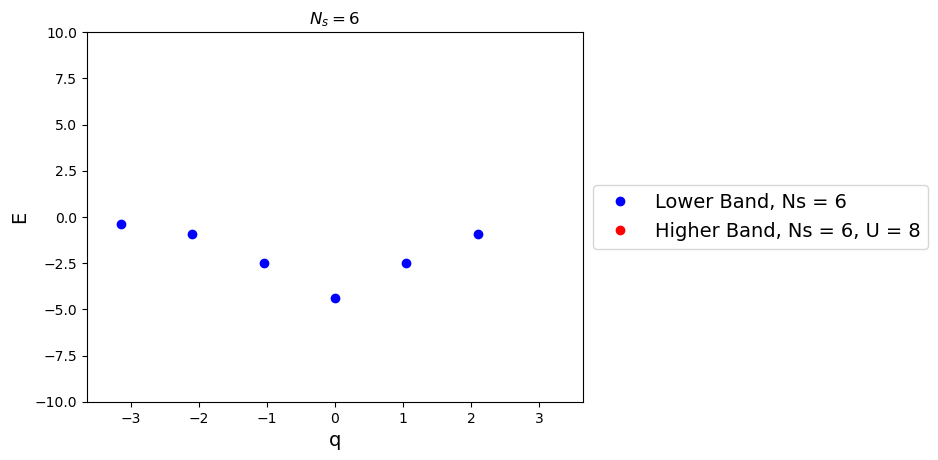

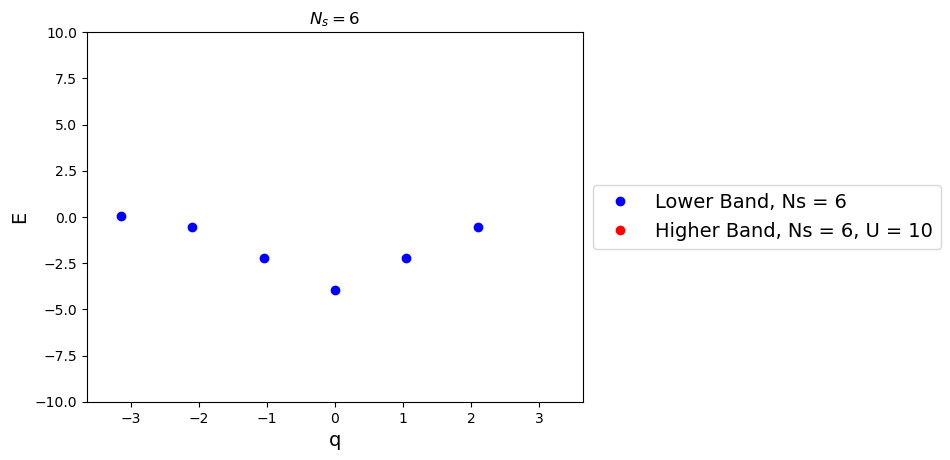

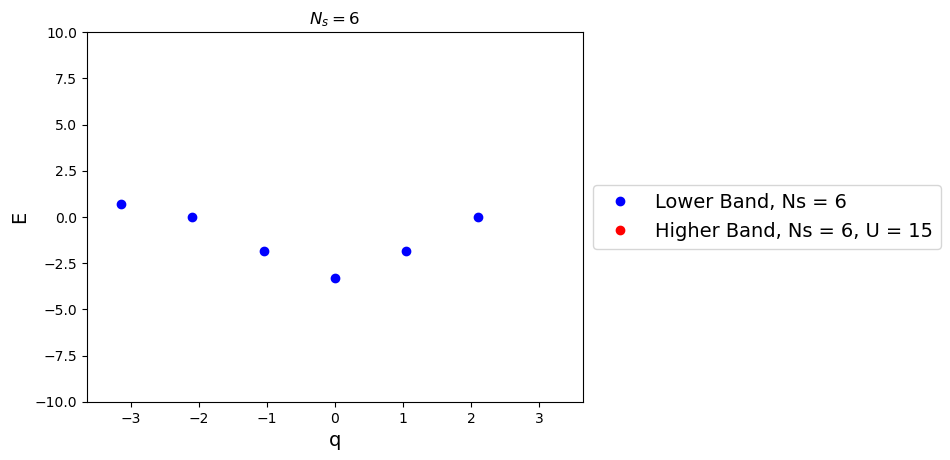

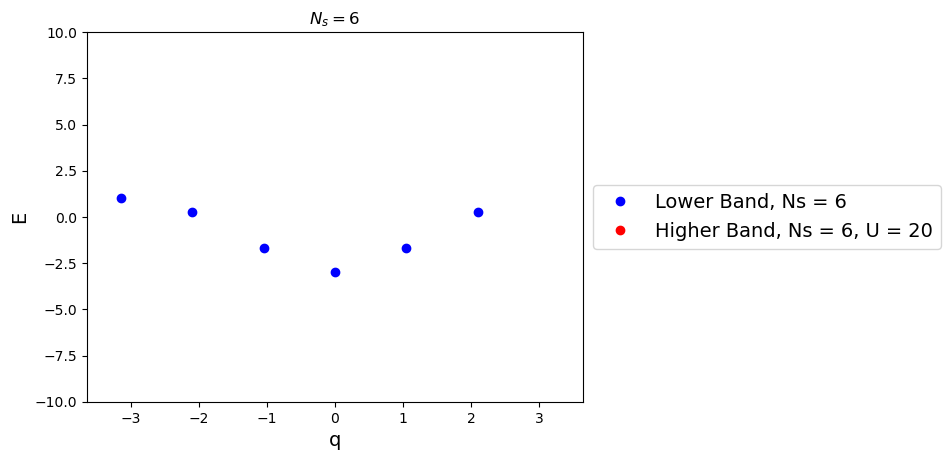

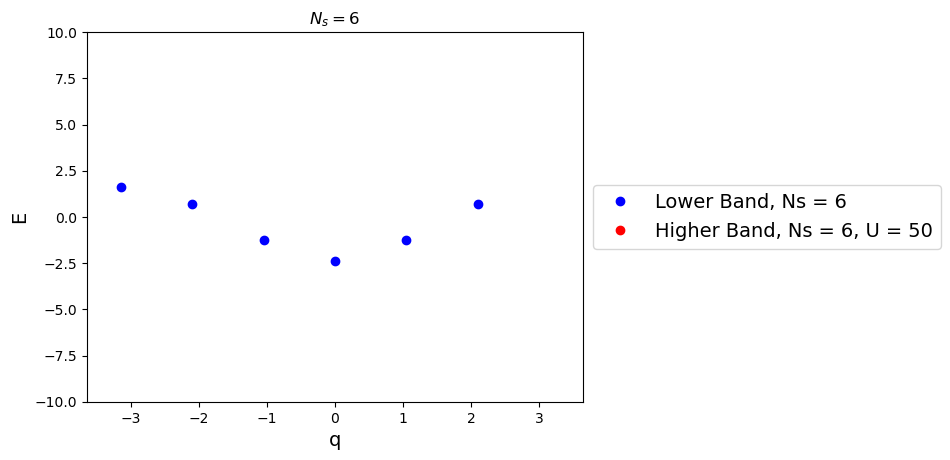

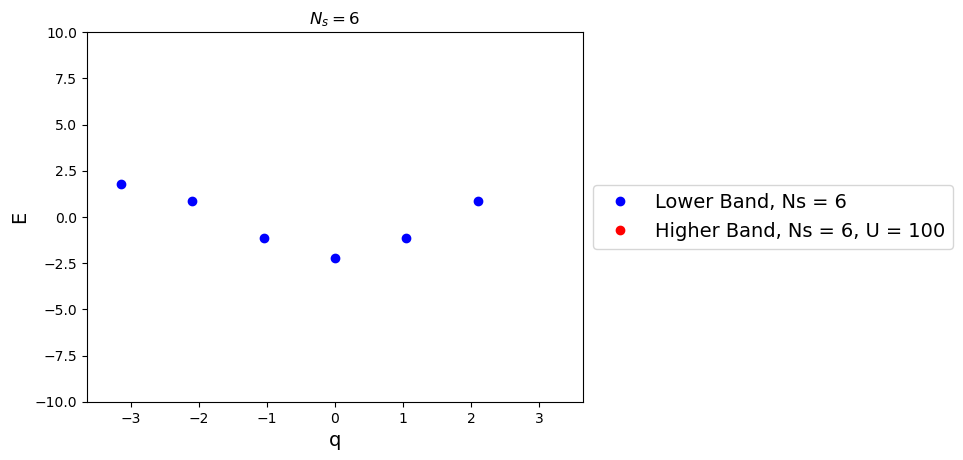

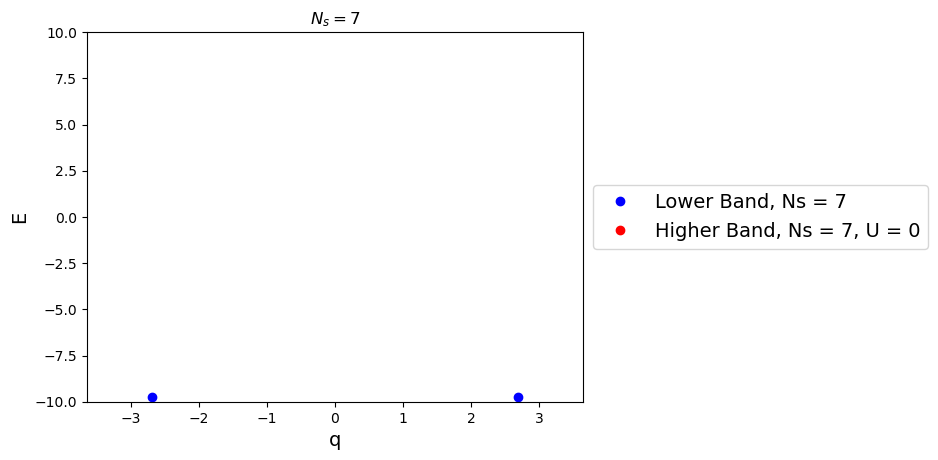

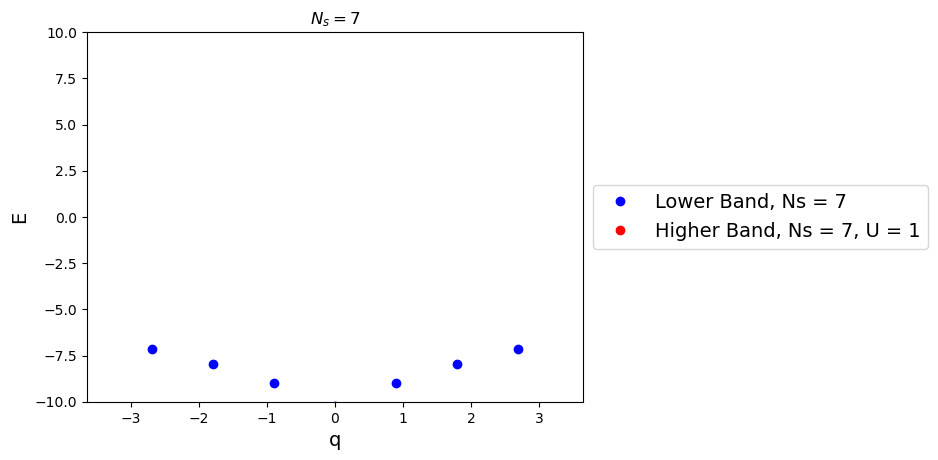

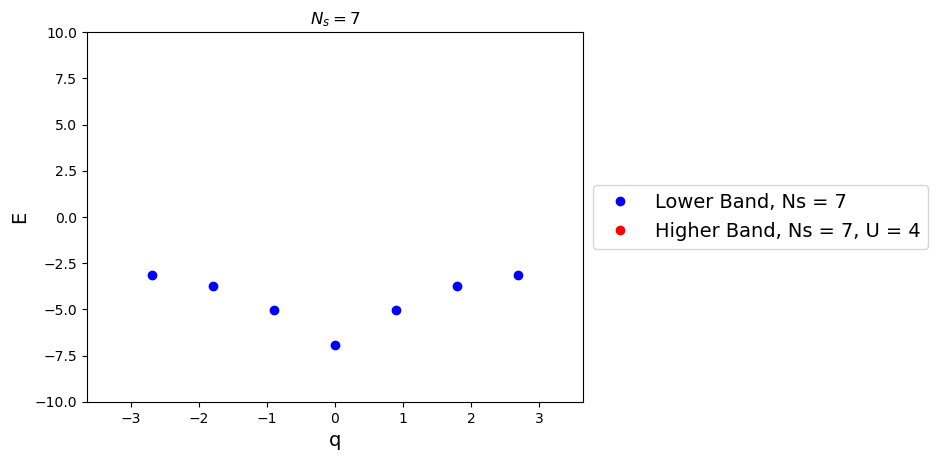

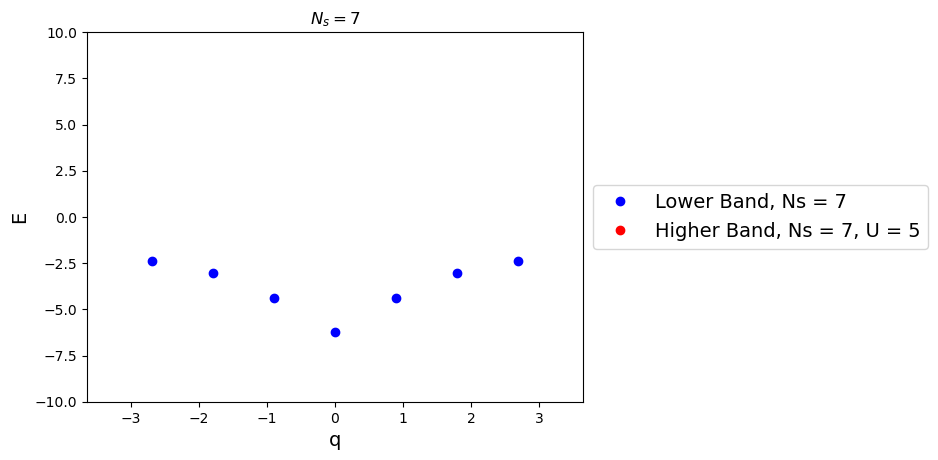

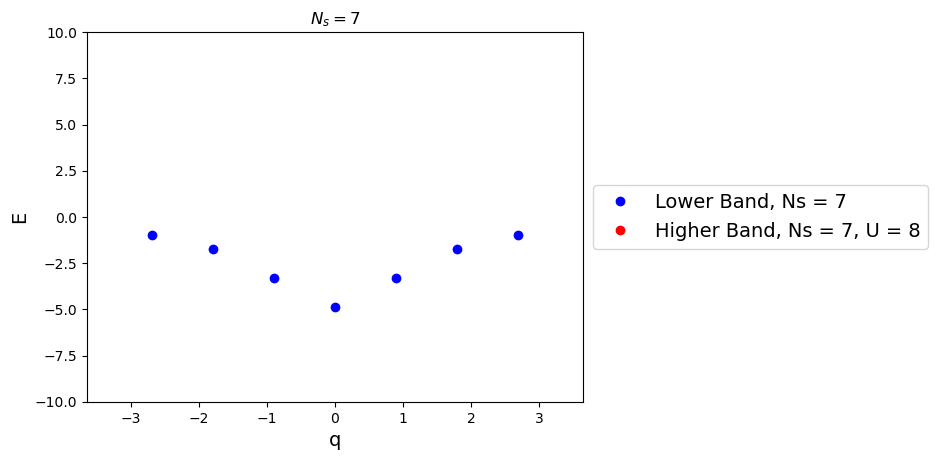

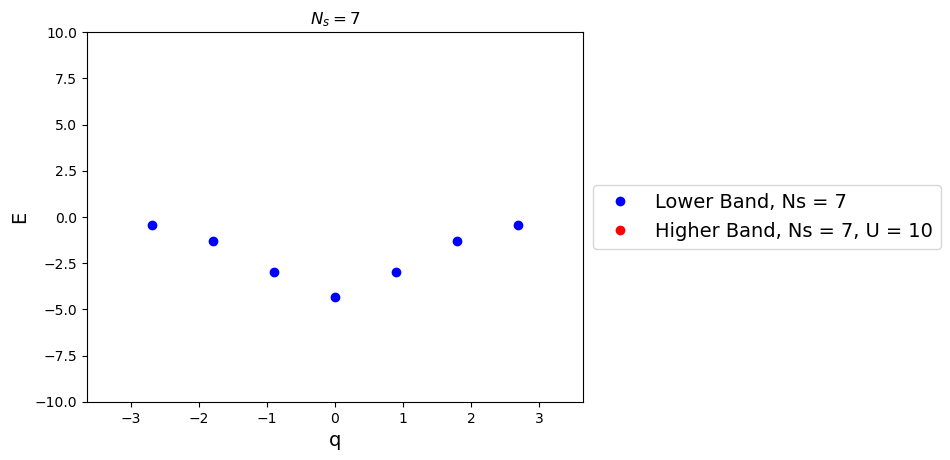

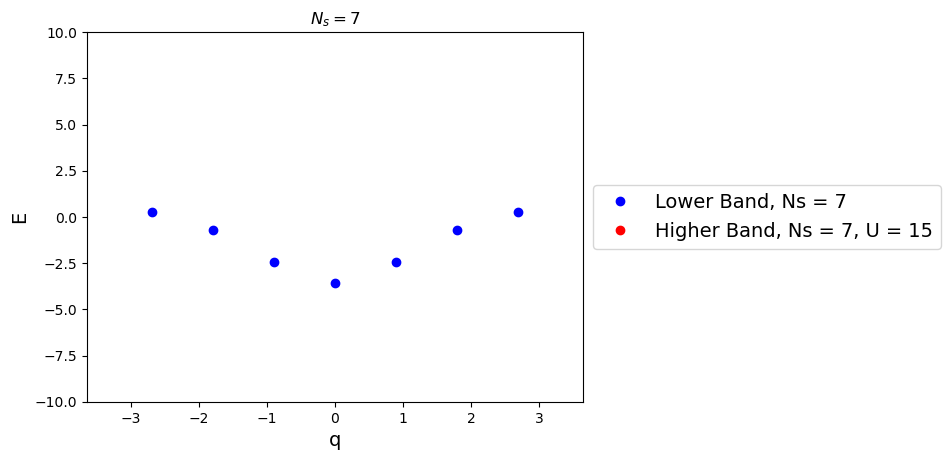

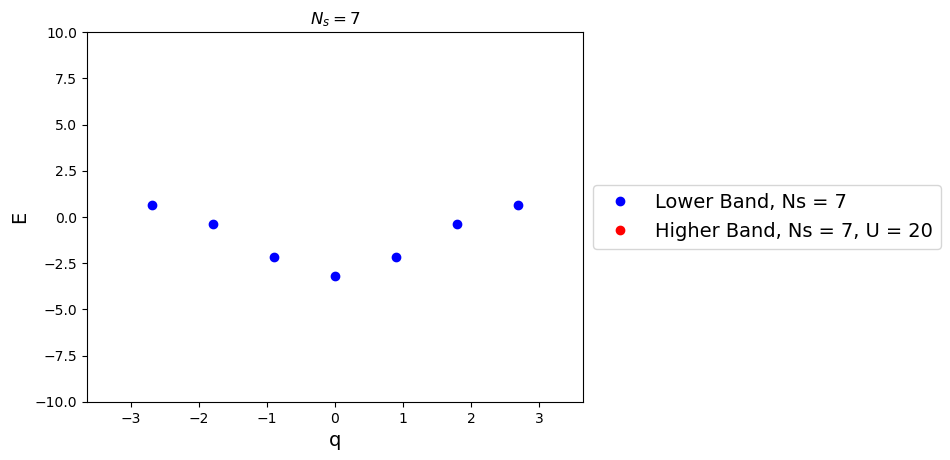

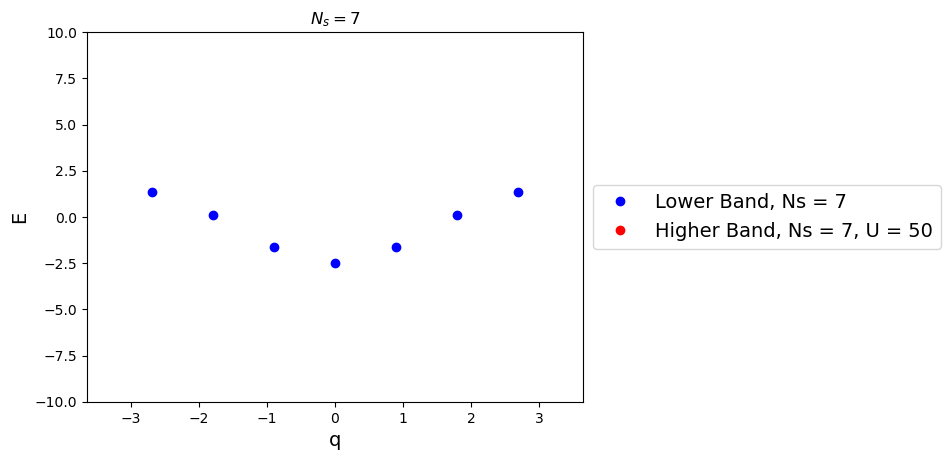

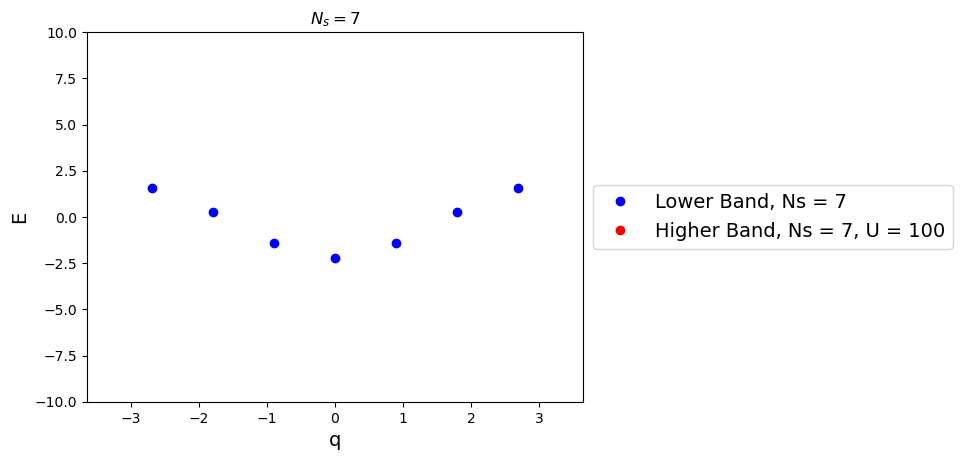

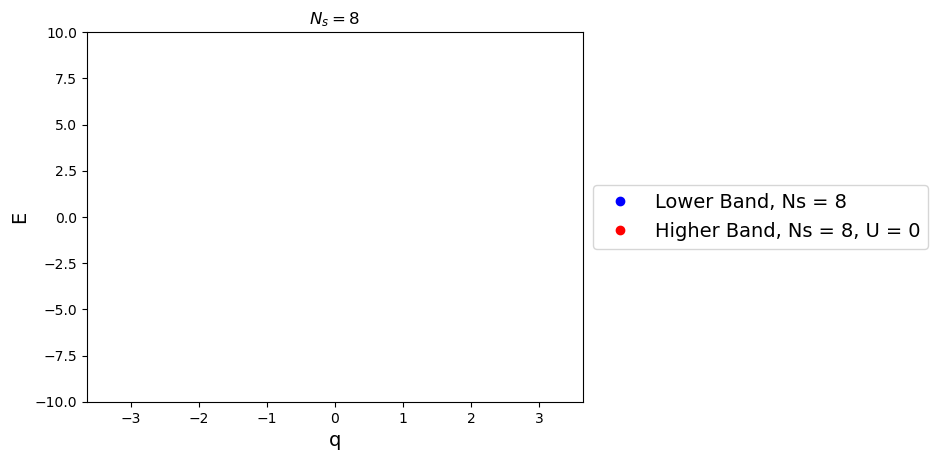

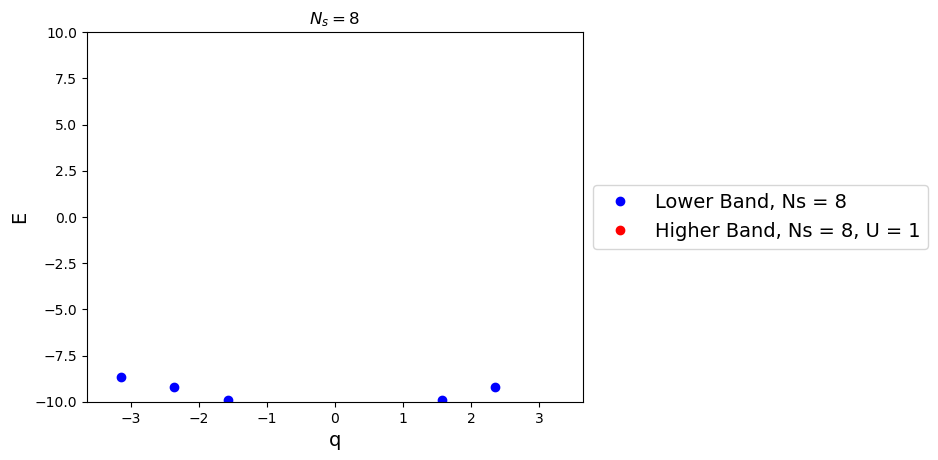

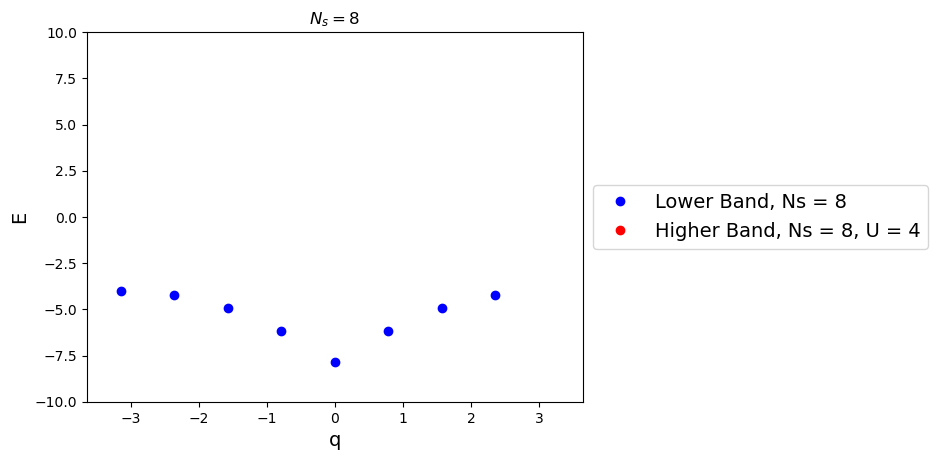

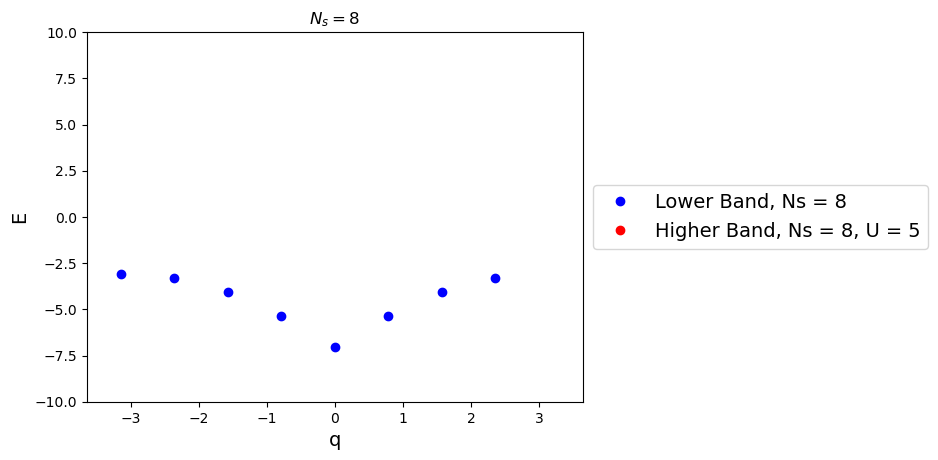

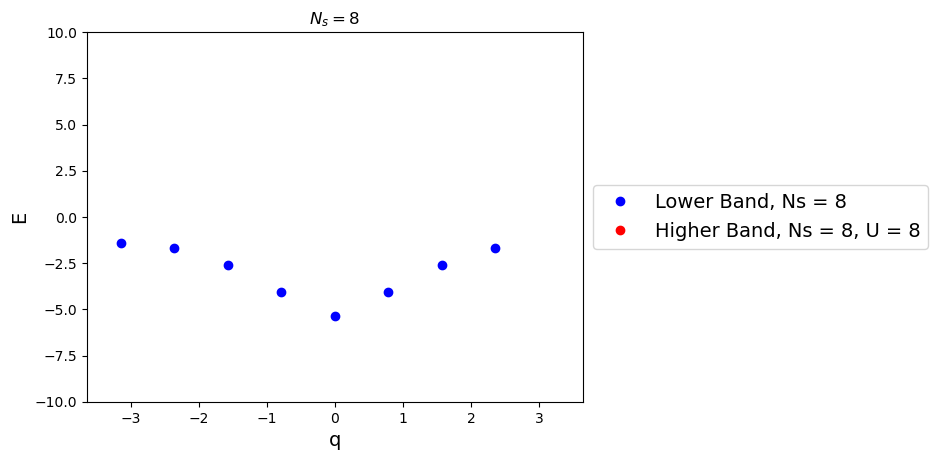

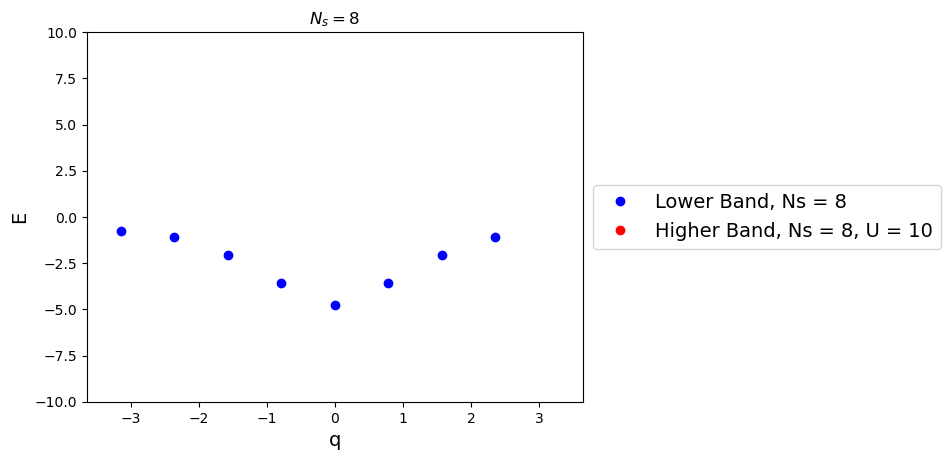

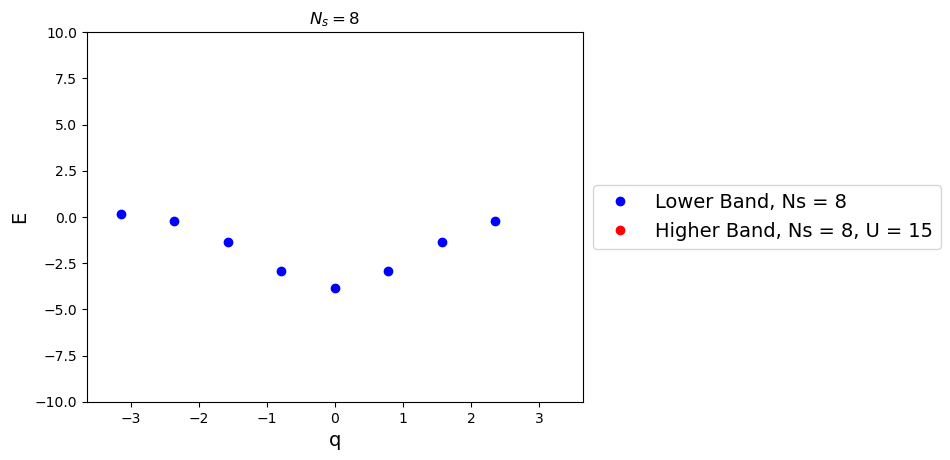

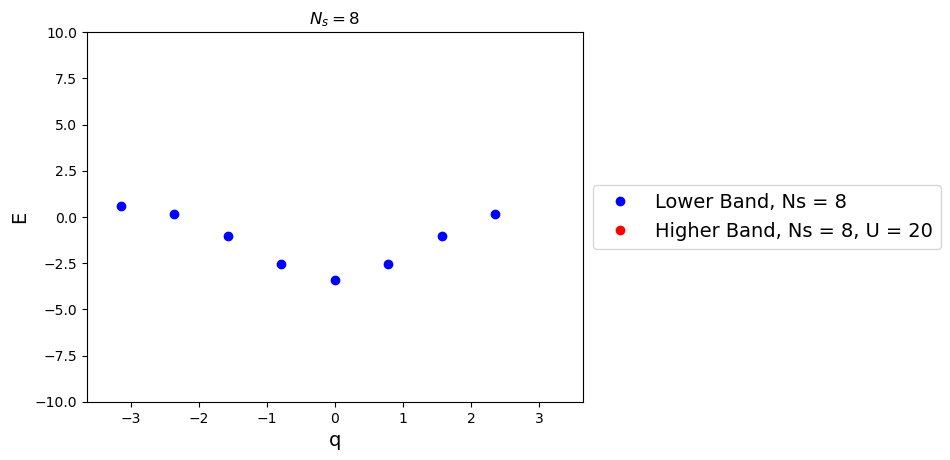

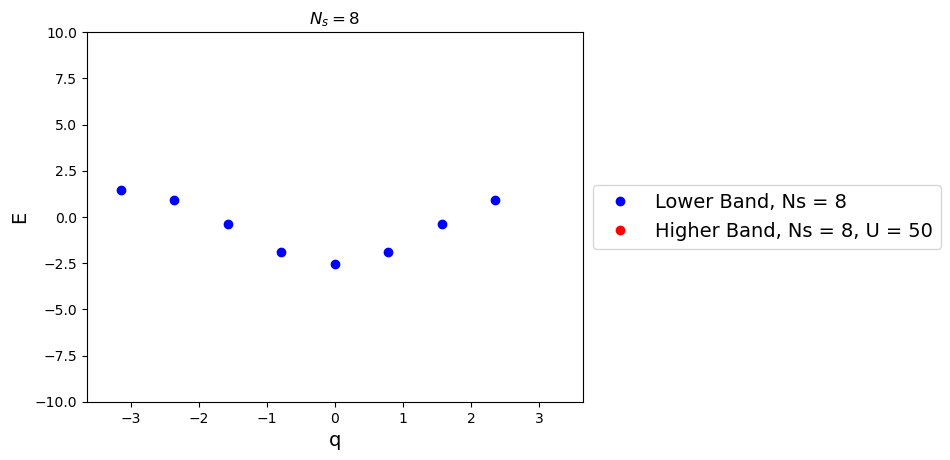

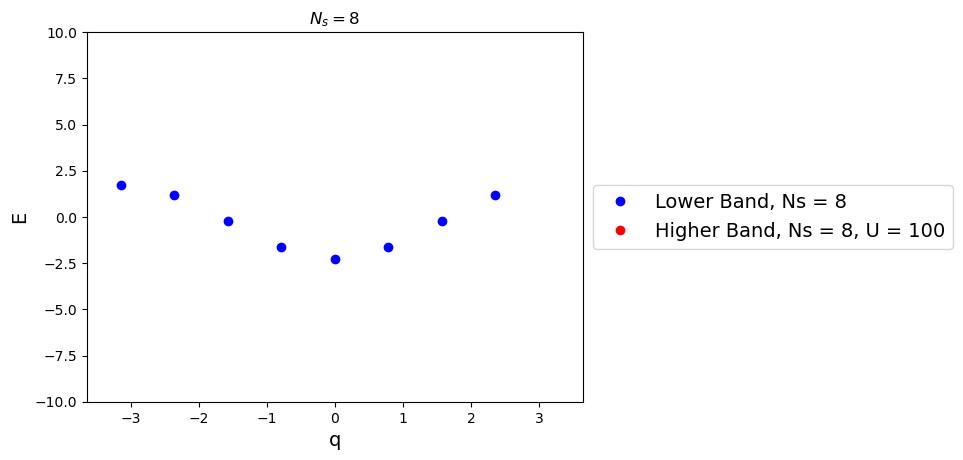

In [52]:
#import itertools
#markers = ["ro", "bo", "go", "yo"]


X = np.linspace(-np.pi,np.pi,201)


if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-Ns//2, Ns//2,1)
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)
    
    
    
'''
#K1 = np.linspace(-np.pi,np.pi,50)
#K2 = np.linspace(-np.pi,np.pi,50)

sumaKs = []
restaKs = []

for i in range(len(K1)):
    for j in range(len(K2)):
        sumaKs.append(K1[i] + K2[j])
        restaKs.append(K1[i] - K2[j])
        

sumaKs = np.array((sumaKs))
restaKs = np.array((restaKs))

#for i in range(len(sumaKs)):
    #sumaKs[i] = move_to_1bz(sumaKs[i])
    #restaKs[i] = move_to_1bz(restaKs[i])

    
#for plotting
sumaKs_1bz = np.zeros(len(sumaKs))
for i in range(len(sumaKs)):
    sumaKs_1bz[i] = move_to_1bz(sumaKs[i])'''
    
#print(Momenta[0])   
#print(Energy[0])
#cosa = np.array([0,249])
print(plot_diff_NS[0][0][:,1])

for ns in range(len(NS)):
    if (NS[ns]%2 == 0):
        K1 = np.arange(-NS[ns]//2, NS[ns]//2,1)*2*np.pi/NS[ns]
    if (NS[ns]%2 != 0):
        K1 = np.arange(-(NS[ns]-1)//2,(NS[ns]-1)//2+1,1)*2*np.pi/NS[ns]
    for i in range(len(Us)):

        #if (Us[i] == 0):
        #plt.plot(X, effective_dispersion_relation(X,Us[i],Ns), label = r"$-2Jcos(q)$")
        #plt.plot(sumaKs_1bz,funcion(sumaKs,restaKs), "bo",markersize = 10 ,label = r"$-2Jcos(k_1+k_2)/2...$", alpha = 1)
        #else:
        
        #plt.plot(X, effective_dispersion_relation(X,Us[i],Ns), label = r"$-2Jcos(q) - \frac{4J^2}{U}sin(2q) + \frac{4J^2}{U}(2 - N_s)$")
        #if (i%20 == 0):

        plt.plot(K1, plot_diff_NS[ns][i][:,0], "bo", label = "Lower Band, Ns = "+str(NS[ns]))
        plt.plot(K1, plot_diff_NS[ns][i][:,1], "ro", label = "Higher Band, Ns = "+str(NS[ns])+", U = "+str(Us[i]))


    #plt.plot(K1, plot_diff_NS[ns][200][:,0], "bo", label = "Lower Band, Ns = "+str(NS[ns]))
    #plt.plot(K1, plot_diff_NS[ns][200][:,1], "ro", label = "Higher Band, Ns = "+str(NS[ns]))
    #plt.plot(Momenta[i],Energy[i] ,label = "U = "+str(Us[i]))


        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
        #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),fontsize = 14)
        plt.xlabel("q", fontsize = 14)
        plt.ylabel("E", fontsize = 14)
        plt.xlim([-np.pi-0.5,np.pi+0.5])
        plt.title(r"$N_s = $"+str(NS[ns])+", U = "+str(Us[i]))
        plt.title(r"$N_s = $"+str(NS[ns]))
        plt.ylim([-10,10])
        plt.show()


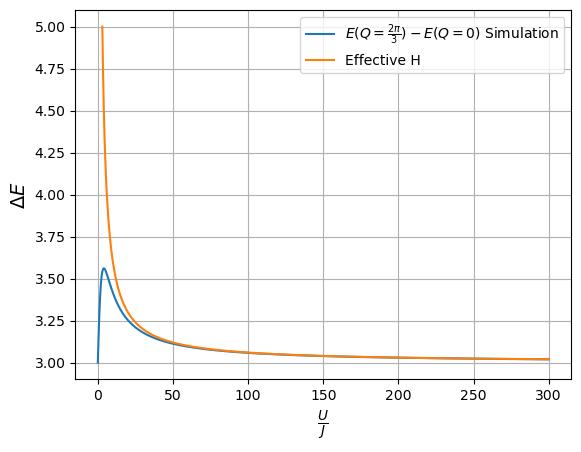

In [247]:
Us_eff = np.linspace(3,300,600)
plt.plot(Us, plot_differences, label = r"$E(Q = \frac{2\pi}{3}) - E(Q = 0)$ Simulation")
plt.plot(Us_eff, effective_dispersion_relation(2*np.pi/3,Us_eff,Ns)- effective_dispersion_relation(0,Us_eff,Ns), label = r"Effective H")
plt.legend()
plt.xlabel(r"$\frac{U}{J}$", fontsize = 14)
plt.ylabel(r"$\Delta E$", fontsize = 14)
plt.grid("on")
plt.show()

In [7]:
def funcion(suma,resta):
    return -4*np.cos(suma/2)*np.cos(resta/2)


def move_to_1bz(k):
    q = k.copy()
    while (q < -np.pi) or (q >= np.pi+0.01):
        #print(q)
        if (q < -(np.pi)):
            #print("hehe")
            q = q + (2*np.pi)
        else:
            q = q - 2*np.pi
            
        '''print("This can never be -3.141592: ", q)
        print("___")
        #if ((q + np.pi) < 1e-5):
        if (q == -np.pi):
            return q
        elif (q == np.pi):
            print(q)
            print("reach here")
            q = -np.pi
            return q'''
       
            
    if np.abs(q-np.pi) < 1e-6:
        q = -np.pi
            
  
    return q


def diagonalization_per_block(vector_of_q, H_Q):
    degeneracies = []
    energies = []
    #check = True
    deg = 1
    for i in range(1,len(vector_of_q)):
        #print(vector_of_q[i])
        if ((vector_of_q[i]  - vector_of_q[i-1]) < 1e-5):
            deg = deg + 1
            
            
        else:
            degeneracies.append(deg)
            deg = 1
            
            
    degeneracies.append(deg)
    
    degeneracies = np.array(degeneracies)
    #print(degeneracies)
    
    for i in range(len(degeneracies)):
        #my_new_matrix = np.zeros((degeneracies[i],degeneracies[i]), dtype = complex)
        my_new_matrix = lil_matrix((degeneracies[i],degeneracies[i]), dtype = complex)
        for j in range(degeneracies[i]):
            for k in range(degeneracies[i]):
                total_sum = 0
                for l in range(i):
                    total_sum = total_sum + degeneracies[l]
                my_new_matrix[j,k] = H_Q[j+total_sum,k+total_sum]
        if (degeneracies[i] > 2):        
            vaps_lower_band = eigs(my_new_matrix, k = 2, which='SR', return_eigenvectors = False)
            vaps_higher_band = eigs(my_new_matrix, k = 2, which='LR', return_eigenvectors = False)

            vaps_lower_band = np.sort(vaps_lower_band)
            vaps_higher_band = np.sort(vaps_higher_band)
        elif (degeneracies[i] == 1):
            vaps_lower_band = np.array([my_new_matrix[0,0]])
            vaps_higher_band = np.array([my_new_matrix[0,0]])
        elif (degeneracies[i] == 2):
            vaps, veps = LA.eigh(my_new_matrix.todense())
            vaps_lower_band = np.array([vaps[0]])
            vaps_higher_band = np.array([vaps[1]])
                
            
            
        '''
        vaps = eigs(my_new_matrix , k = 3, which = "SR", return_eigenvectors = False)
        vaps = np.sort(vaps)'''
        #vaps,veps = LA.eigh(my_new_matrix)
        
        #for m in range(len(vaps)):
        for m in range(degeneracies[i]):
            if (m < len(vaps_lower_band)):
                energies.append(np.real(vaps_lower_band[m]))
            elif (m > degeneracies[i] - len(vaps_higher_band) - 1):
                #print(m)
                energies.append(np.real(vaps_higher_band[m - degeneracies[i] + len(vaps_higher_band)]))
            else:
                energies.append(0)
        '''
        for m in range(degeneracies[i]):
            if m < len(vaps):
                energies.append(np.real(vaps[m]))
            else:
                energies.append(0)'''
    
    
    
    energies = np.array(energies)
    #print("energies", energies)
    
    return energies
    
    
def effective_dispersion_relation(q,U,Ns):
    #if (U != 0):
    return -2*np.cos(q) - 4/(U)*np.cos(2*q) + 8/U - 4/U*Ns
    #else:
     #   return -2*np.cos(q)

def effective_dispersion_relation_fermions(q,U,Ns):
    return 2*np.cos(q) - 4/(U)*np.cos(2*q) + 8/U - 4/U*Ns
    
    
def find_EQ1_EQ2(vector_q,vector_E, Ns):
    
    out = np.zeros((Ns,4))
    
    if (Ns%2 == 0):
        check = True
        for k in range(-Ns//2,Ns//2,1):
            q_check = k*2*np.pi/Ns
            check = True
            
            for i in range(len(vector_q)):
                if (i != len(vector_q) -1):
                    
                    if (np.abs(vector_q[i] - q_check) < 1e-6) and (check == True):
                        out[k+Ns//2,0] = vector_E[i]
                        out[k+Ns//2,2] = vector_E[i+1]
                        check = False
                        
                    if (check == False) and ((np.abs(vector_q[i] - vector_q[i+1]) > 1e-6)):
                        out[k+Ns//2,1] = vector_E[i]
                        out[k+Ns//2,3] = vector_E[i-1]
                        check = True
                else:
                    if (np.abs(vector_q[i] - q_check) < 1e-6):
                        out[k+Ns//2,1] = vector_E[i]
                        out[k+Ns//2,3] = vector_E[i-1]
                
    if (Ns%2 != 0):
        for k in range(-(Ns-1)//2,(Ns-1)//2+1,1):
            q_check = k*2*np.pi/Ns
            #print("check of q = ", q_check)
            check = True
            for i in range(len(vector_q)):
                #print("i = ", i)
                if (i != len(vector_q) - 1):
                    if (np.abs(vector_q[i] - q_check) < 1e-6) and (check == True):
                        #print("Lower level")
                        #print("before:",out[k+(Ns-1)//2,0])
                        out[k+(Ns-1)//2,0] = vector_E[i]
                        out[k+(Ns-1)//2,2] = vector_E[i+1]
                        #print("after:",out[k+(Ns-1)//2,0])
                        check = False
            
                    if (check == False) and ((np.abs(vector_q[i] - vector_q[i+1]) > 1e-3)):
                        
                        #print("Higher level")
                        #print("before",out[k+(Ns-1)//2,1])
                        out[k+(Ns-1)//2,1] = vector_E[i]
                        out[k+(Ns-1)//2,3] = vector_E[i-1]
                        #print("after",out[k+(Ns-1)//2,1])
                        check = True
    
                else:
                    if (np.abs(vector_q[i] - q_check) < 1e-6):
                        #print("Higher level")
                        #print("before",out[k+(Ns-1)//2,1])
                        out[k+(Ns-1)//2,1] = vector_E[i]
                        out[k+(Ns-1)//2,3] = vector_E[i-1]
                        #print("after",out[k+(Ns-1)//2,1])
            
            
            
            
            '''if (np.abs(vector_q[i]) < 1e-6) and (check1 == True):
                E_Q0 = vector_E[i]
                check1 = False
            if (np.abs(vector_q[i] - (2*np.pi/Ns)) < 1e-6) and (check2 == True):
                E_Q1 = vector_E[i]
                check2 = False'''
            
    return out




def bogoliubov_spectrum(q,a,m_inv,shift):
    #a = 0
    #return shift + np.sqrt((a**2)*4*np.sin(q/2)**2 + (1/m_inv*2*np.sin(q/2)**2)**2)
    return shift + np.sqrt(a**2*q**2 + (m_inv**2*4*np.sin(q/2)**4))
def parabolic_spectrum(q,m_inv):
    return m_inv*q**2/2
    
def curve_fit_bogoliubov(bands):
    Ns = len(bands)
    
    if (Ns%2 == 0):
        Q = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns
    if (Ns%2 != 0):
        Q = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns
    
    
    ydata0 = np.zeros(len(Q))
    ydata1 = np.zeros(len(Q))
    
    for i in range(len(ydata0)):
        #print(bands[i,0])
        
        ydata0[i] = bands[i,0]
        ydata1[i] = bands[i,1]
    
    g = [1, 2, 1]
    

    
    
    values, cov = curve_fit(bogoliubov_spectrum, Q, ydata0, g)#, bounds=((-0.001,-np.inf,-np.inf), (0.001,np.inf,np.inf)))
    
    a = values[0]
    
    m_inv = values[1]
    
    shift = values[2]
    
    #print("c varianice:", cov[0])
    #print("m varianice:", cov[1])
    #print("shift varianice:", cov[2])
    
    return m_inv, a, shift


def equation_system_ns6(E0,E1,E2):
    d1 = E1 - E0
    d2 = E2 - E0
    
    #first three states
    #m_inv = 1/(2/3*(d2)**2-2*d1**2)
    #c = 3/2*d1**2 - 1/6*d2**2
    
    
    #linear sound speed
    #m_inv = 4/5*d2**2 - 16/5*d1**2
    #c = (6/(4*np.pi))**2*(36/5*d1**2 - 4/5*d2**2)
    
    #frontier:
    m_inv = 4/5*d2**2 - 16/5*d1**2
    c = 9/5*d1**2 - 1/5*d2**2
    
    #print("m_inv = ", m_inv)
    #print("c = ", c)
    
    
    #return np.sqrt(np.abs(m_inv2)), np.sqrt(np.abs(c2))
    return np.sqrt(m_inv), np.sqrt(c)



def inverse_mass_q2pins(J,U,Ns):
    return 2*J*np.cos(2*np.pi/Ns) - 16*J**2/U*np.cos(4*np.pi/Ns)


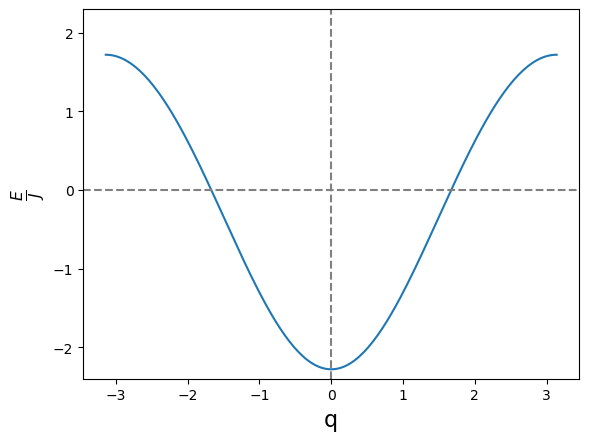

In [25]:
Q = np.linspace(-np.pi,np.pi,200)

#plt.plot(Q,effective_dispersion_relation_fermions(Q,100,8), label = "Fermions")
plt.plot(Q,effective_dispersion_relation(Q,100,8), label = "Hard core bosons")
plt.axhline(y = 0, ls = "--", color = "Gray")
plt.axvline(x = 0, ls = "--", color = "Gray")
plt.xlabel("q", fontsize = 16)
plt.ylabel(r"$\frac{E}{J}$", fontsize = 16)
#plt.legend(loc = "upper center", ncol = 2)
plt.ylim([-2.4,2.3])
plt.show()

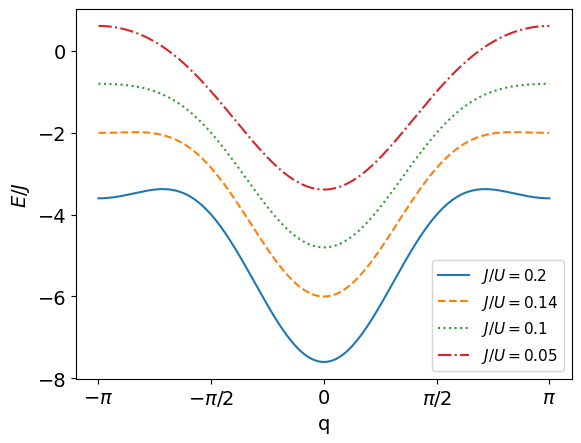

In [34]:
Us = np.array([5,7,10,20.20])
linesstyles = ["-", "--", ":", "-."]
for i in range(len(Us)):
    plt.plot(Q,effective_dispersion_relation(Q,Us[i],8),ls = linesstyles[i], label = r"$J/U = $"+str(round(1/Us[i],2)))

plt.xlabel("q", fontsize = 14)
plt.ylabel(r"$E/J$", fontsize = 14)
plt.xticks(np.array([-np.pi,-np.pi/2,0,np.pi/2,np.pi]),[r"$-\pi$",r"$-\pi/2}$","0",r"$\pi/2$",r"$\pi$"],fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol = 1, fontsize = 11)
#plt.ylim([-2.4,2.3])
plt.show()

In [ ]:
#p_unordered = vaps_q
p_unordered = vaps_q
p = vaps_q_1bz[order]

print(p)


print(diagonalization_per_block(p,H_Q1))







plt.plot(p,diagonalization_per_block(p,H_Q1), "ro", markersize = 10)
plt.show()

In [ ]:
if (Ns%2 == 0):
    K1 = np.arange(-Ns//2, Ns//2,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-Ns//2, Ns//2,1)
if (Ns%2 != 0):
    K1 = np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)*2*np.pi/Ns
    K2  = 2*np.pi/Ns*np.arange(-(Ns-1)//2,(Ns-1)//2+1,1)


print("K1",K1)


sumaKs = []
restaKs = []

for i in range(len(K1)):
    for j in range(len(K2)):
        sumaKs.append(K1[i] + K2[j])
        restaKs.append(K1[i] - K2[j])
        
      
sumaKs = np.array((sumaKs))
restaKs = np.array((restaKs))

    
plt.plot(sumaKs, funcion(sumaKs,restaKs), "ro", markersize = 13, label = "-2J(cos(k1)+cos(k2))")    
plt.plot(Momenta,vaps, "go", markersize = 5, label = "Expectation values of simulation")

plt.xlabel(r"$k_1 + k_2$")
plt.ylabel("E")
plt.grid("on")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [155]:
basis = create_whole_basis(2,0,3)

HJ = build_H_hopping(basis)
HU = build_H_contact(basis)

Js = np.linspace(0.001,0.5,100)

plot = np.zeros((len(basis), len(Js)))

for i in range(len(Js)):
    H = Js[i]*HJ + HU
    vaps, veps = LA.eigh(H)
    for _ in range(len(basis)):
        plot[_,i] = vaps[_]
        
        


In [146]:
def e0(J,U):
    return -2*J-8*J**2/U
def e12(J,U):
    return J - 2*J**2/U


def e34(J,U):
    return 2*J**2/U
def e5(J,U):
    return 8*J**2/U


In [ ]:
for i in range(1, len(basis)):
    plt.plot(Js,plot[i,:], ls = "--", color = "Gray")
    
    
plt.plot(Js,plot[0,:], ls = "--", color = "Gray", label = "Exact diagonalization, B-H Hamiltonian")
plt.plot(Js, e0(Js,1))
plt.plot(Js, e12(Js,1))
plt.plot(Js,  1 + e34(Js,1))
plt.plot(Js,  1 + e5(Js,1))

plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
plt.ylabel(r"$\frac{E}{U}$", fontsize = 16)
plt.legend()
#plt.xlim([0,0.5])
plt.show()
    

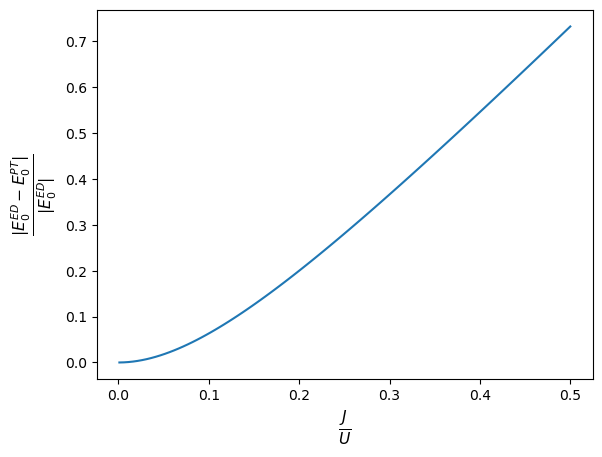

In [158]:
Js = np.linspace(0.001,0.5,100)
plt.plot(Js,np.abs(plot[0,:] - e0(Js,1))/np.abs(plot[0,:]))
plt.xlabel(r"$\frac{J}{U}$", fontsize = 16)
plt.ylabel(r"$\frac{|E_0^{ED} - E_0^{PT}|}{|E_0^{ED}|}$", fontsize = 16)


plt.show()
    

In [12]:
Ns = 4
Na = 3
Nb = 0


basis = create_whole_basis(Na,Nb,Ns)

HJ = build_H_hopping(basis)
HU = build_H_contact(basis)


#Js = np.linspace(-0.5,0.5,400)

ratios = np.linspace(-0.5,0.5,400)
Us = 1/ratios



print(Us)

plot_exact = np.zeros((len(Us),len(basis)))
plot_effective = np.zeros((len(Us), Ns))


for i in range(len(Us)):
    H_ex = HJ + Us[i]*HU
    H_eff = H_eff_mott(Ns,1,Us[i])
    
    vaps_ex, veps_ex = LA.eigh(H_ex)
    vaps_eff, veps_eff = LA.eigh(H_eff)
    
    for k in range(len(H_ex)):
        
        plot_exact[i,k] = vaps_ex[k]
    for k in range(len(H_eff)):
        plot_effective[i,k] = vaps_eff[k]
        

    

[  -2.           -2.01007557   -2.02025316   -2.03053435   -2.04092072
   -2.05141388   -2.0620155    -2.07272727   -2.08355091   -2.09448819
   -2.1055409    -2.11671088   -2.128        -2.13941019   -2.1509434
   -2.16260163   -2.17438692   -2.18630137   -2.19834711   -2.21052632
   -2.22284123   -2.23529412   -2.24788732   -2.26062323   -2.27350427
   -2.28653295   -2.29971182   -2.31304348   -2.32653061   -2.34017595
   -2.3539823    -2.36795252   -2.38208955   -2.3963964    -2.41087613
   -2.42553191   -2.44036697   -2.45538462   -2.47058824   -2.48598131
   -2.5015674    -2.51735016   -2.53333333   -2.54952077   -2.5659164
   -2.58252427   -2.59934853   -2.61639344   -2.63366337   -2.65116279
   -2.66889632   -2.68686869   -2.70508475   -2.72354949   -2.74226804
   -2.76124567   -2.7804878    -2.8          -2.81978799   -2.83985765
   -2.86021505   -2.88086643   -2.90181818   -2.92307692   -2.94464945
   -2.96654275   -2.98876404   -3.01132075   -3.03422053   -3.05747126
   -3.08

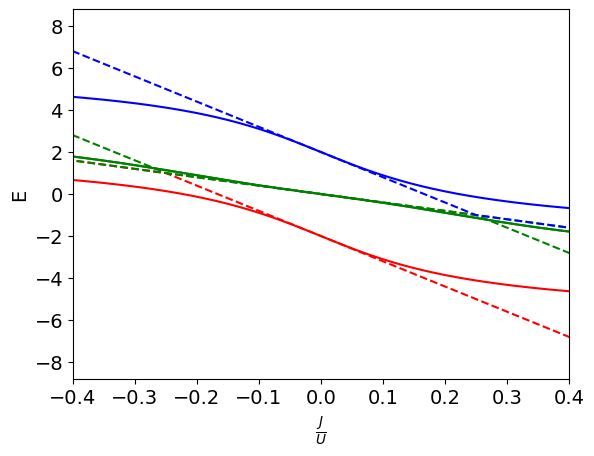

In [21]:
colors = ["red", "green", "green", "blue"]
colors2 = ["blue", "green", "green", "red"]

for i in range(4):
    #plt.plot(ratios[len(Us)//2:], plot_exact[len(Us)//2:,i]*ratios[len(Us)//2:], ls = "-", color = colors[i])
    #plt.plot(ratios[:len(Us)//2], plot_exact[:len(Us)//2,20-(i+1)]*ratios[:len(Us)//2], ls = "-", color = colors2[i])
    #plt.plot(ratios,plot_effective[:,i]*ratios, ls = "--" , color = colors[i], alpha = 1)
    
    
    plt.plot(ratios[len(Us)//2:], plot_exact[len(Us)//2:,i], ls = "-", color = colors[i])
    plt.plot(ratios[:len(Us)//2], plot_exact[:len(Us)//2,20-(i+1)], ls = "-", color = colors2[i])
    plt.plot(ratios,plot_effective[:,i], ls = "--" , color = colors[i], alpha = 1)
    
    
    
#plt.ylim([-1,0.15])
plt.xlim([-0.4,0.4])
plt.xlabel(r"$\frac{J}{U}$", fontsize = 14)
plt.ylabel(r"E", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.grid("on")
plt.show()